# Prepares data to go into SHETRAN and HIPIMS

### Notes
- This code relies on the following code
    1. `read_met_radar` - reads in 5-minute gridded (composite and processed C-band weather radar from the Met Office ftp server.
    2. `read_ea_gauges` - reads in 15-minute rain gauge data from the EA website API, and quality controls gauge data using intense-qc code.
    3. `read_cs_gauges` - reads in varying resolution rain gauge data from NGIF and UO API, quality controls gauge data using intense-qc code, and accumulates up to 15-minute resolution data.

### What does this code do?
1. Read in radar data (if exists)
    - Met Office radar data
    - Urban Observatory radar data (not including as not working)
2. Read in quality controlled rain gauge data (if exists)
    - Environment Agency rain gauges
    - Urban Observatory rain gauges
    - Citizen Science rain gauges
    - National Green Infrastructure Facility rain gauges
3. Grids rain gauge data (if exists)
    - Whatever data is available or just EA?
    
6. Saves data as input for models in correct format
    - SHETRAN input rainfall data
    - HIPIMS input rainfall data
    
### What does this code need to do?
4. Merges radar data (just MET for now) with rain gauge data
5. Goes through data and selects most appropriate to use 
    - SHETRAN input rainfall data
    - HIPIMS input rainfall data
    

### Priority list of data
(top = best)

#### SHETRAN
1. Merged rain gauges and Met Office radar data
2. Met Office radar data
3. Gridded gauges (as long as EA data exists)
4. Otherwise cannot run model as not enough data exists

#### HIPIMS
1. Merged Urban Observatory radar data and rain gauges, conditional on Met Office radar (this code doesn't exist as UO radar is currently not working - not possible in timeframe of project?).
2. Merged rain gauges and Met Office radar data
3. Met Office radar data
4. Gridded gauges (as long as EA data exists)
5. Otherwise cannot run model as not enough data exists

In [30]:
# Import relevent packages
from os.path import join, exists
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import wradlib.ipol as ipol
import gstools as gs

In [2]:
root_path = r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\PYRAMID\data\realtime"
static_path = join(root_path, "static")

output_shetran_path = join(root_path, "SHETRAN")
if not exists(output_shetran_path):
    os.mkdir(output_shetran_path)

output_hipims_path = join(root_path, "HIPIMS")
if not exists(output_hipims_path):
    os.mkdir(output_hipims_path)

In [3]:
##### Inputs to change
start_date = "2023-06-20"
end_date = "2023-06-30"

out_path = r"C:\Users\Amy\OneDrive - Newcastle University (1)\Documents\PYRAMID\data\realtime"

# Bounding box for data 
e_l, n_l, e_u, n_u = [355000, 534000, 440000, 609000]
bbox = [e_l, e_u, n_l, n_u]

full_timestamp = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(1, "d"), freq=str(15*60) + "s", tz="UTC")

xs = np.nan
ys = np.nan

In [4]:
# Set up a function that reads the header lines from a SHETRAN mask:
def read_ascii_header(file_path: str):

    header_dict = {}
    line=[]

    with open(file_path, 'r') as f:
        while True:
            line = f.readline()
            line = line.split()
            if len(line)>2: break
            header_dict[line[0]] = float(line[1])

    return header_dict
    
# path to SHETRAN mask (needs changing)
shetran_mask_path = join(static_path, "Tyne_at_Newcastle_Mask.asc")
mask = np.loadtxt(shetran_mask_path, skiprows=6)

# Get mask meta info
meta = read_ascii_header(shetran_mask_path)

# path to HIPIMS bbox file
hipims_bbox_path = join(static_path, "boundbox.shp")
bbox = gpd.read_file(hipims_bbox_path)

# Reproject bouninging box for data
bbox['geometry'] = bbox['geometry'].to_crs(epsg=27700)
min_x, min_y, max_x, max_y = bbox.bounds.loc[0]


# Clip rainfall data
new_xs = meta["xllcorner"] + (meta["cellsize"] / 2) + meta["cellsize"] * np.arange(meta["ncols"]) # don't think these need saving
new_ys = meta["yllcorner"] + (meta["cellsize"] / 2) + meta["cellsize"] * np.arange(meta["nrows"])

### Met Office radar data

In [25]:
### Inputs to change

# read in data
met_input_path = join(join(root_path, "MET"), "15min") # folder where rainfall data is saved
if exists(join(met_input_path, "arrays.npy")):

    # output data folders
    met_output_shetran_path = join(output_shetran_path, "MET")
    if not exists(met_output_shetran_path):
        os.mkdir(met_output_shetran_path)

    met_output_hipims_path = join(output_hipims_path, "MET")
    if not exists(met_output_hipims_path):
        os.mkdir(met_output_hipims_path)

    # Read in rainfall data
    arrs = np.load(join(met_input_path, "arrays.npy"))
    xs = pd.read_csv(join(met_input_path, "coords_x.csv"))["0"]
    ys = pd.read_csv(join(met_input_path, "coords_y.csv"))["0"]
    dates = pd.to_datetime(pd.read_csv(join(met_input_path, "timestamp.csv"))["0"])
    
    # Clip data for SHETRAN
    clipped_rainfall_shetran = pd.DataFrame((arrs[:, :, [x in new_xs for x in xs]][:, [y in new_ys for y in ys]][:, mask == 0]))

    # Save clipped rainfall
    clipped_rainfall_shetran.to_csv(join(met_output_shetran_path, "Tyne_at_Newcastle_Precip.csv"), index=False)

    # Clip data for HIPIMS
    x_cond = (xs >= min_x - 500) & (xs <= max_x + 500)
    y_cond = (ys >= min_y - 500) & (ys <= max_y + 500)
    clip_x = arrs[:, :, x_cond]
    clipped_rainfall = clip_x[:, y_cond[::-1], :]

    # Reformat to dataframe for input file
    clipped_rainfall_hipims = pd.DataFrame(clipped_rainfall.reshape(clipped_rainfall.shape[0], clipped_rainfall.shape[1] * clipped_rainfall.shape[2]), index=dates)

    # Save file
    clipped_rainfall_hipims.to_csv(join(met_output_hipims_path, "rain_source.txt"))

TypeError: index is not a valid DatetimeIndex or PeriodIndex

### QC'ed rain gauge data

In [6]:
gauge_check = False

# EA raing gauges
gauge_folders = ["EA", "UO", "CS", "NGIF"]
gauge_dfs = []

for gauge_source in gauge_folders:
    
    gauge_root_path = join(join(root_path, gauge_source), "qc")
    
    if exists(gauge_root_path):
        gauge_filenames = os.listdir(gauge_root_path)

        if gauge_source == "EA":
            if len(gauge_filenames) > 0:
                gauge_check = True

        for f in gauge_filenames:
            # station_id, easting, northing = f.split(".")[0].split("_")
            tab = pd.read_csv(join(gauge_root_path, f), index_col=0).iloc[:, 0]
            tab.index = pd.to_datetime(tab.index)
            tab.columns = [gauge_source + "_" + f.split(".")[0]]
            gauge_dfs.append(tab)
            
gauges = pd.DataFrame(index=full_timestamp)
g_x = np.empty(len(gauge_dfs))
g_y = np.empty(len(gauge_dfs))

source = np.full(len(gauge_dfs), "")
    
for i, tab in enumerate(gauge_dfs):
    col = tab.columns[0]
    
    g_x[i] = float(col.split("_")[-2])
    g_y[i] = float(col.split("_")[-1])
    source[i] = col.split("_")[0]
    
    gauges[col] = np.nan
    gauges.loc[tab.index, col] = tab.values

### Gridding gauge data

In [7]:
gridded = np.nan

if gauge_check:
    
    if not isinstance(xs, pd.Series):
        xs = np.arange(e_l, e_u, 1000) + 500
        ys = np.arange(n_l, n_u, 1000) + 500
        
    # Synthetic observations and source coordinates
    src = np.vstack([g_x, g_y]).transpose()

    # Target coordinates
    xtrg = xs
    ytrg = ys
    trg = np.meshgrid(xtrg, ytrg)
    trg = np.vstack((trg[0].ravel(), trg[1].ravel())).T

    # Interpolation objects
    ok = ipol.OrdinaryKriging(src, trg, remove_missing=True)
    ok1 = ipol.OrdinaryKriging(src[0:-1, :], trg, remove_missing=True)
    
    gridded = np.full((len(full_timestamp), len(ys), len(xs)), np.nan) # chekc dimensions correct way round

    for t in range(len(full_timestamp)):
        time = full_timestamp[t]
        vals = gauges.loc[time].values
        tot = np.nansum(vals)

        if not np.isnan(tot):
            if tot == 0:
                gridded[t] = 0
            else:
                try:
                    gridded[t] = np.flip(ok(vals).astype(float).reshape((len(ys), len(xs))), axis=0)
                except:
                    pass       
                
# Save gridded gauge rainfall data
gridded_gauges_outpath = join(root_path, "gauges")
if not exists(gridded_gauges_outpath):
    os.mkdir(gridded_gauges_outpath)
    
np.save(join(gridded_gauges_outpath, "gridded.npy"), gridded)
pd.Series(xs).astype(float).to_csv(join(gridded_gauges_outpath, "coords_x.csv"))
pd.Series(ys).astype(float).to_csv(join(gridded_gauges_outpath, "coords_y.csv"))
pd.Series(full_timestamp).to_csv(join(gridded_gauges_outpath, "timestamp.csv"))

In [9]:
# output data folders
gauge_output_shetran_path = join(output_shetran_path, "gauges")
if not exists(gauge_output_shetran_path):
    os.mkdir(gauge_output_shetran_path)

gauge_output_hipims_path = join(output_hipims_path, "gauges")
if not exists(gauge_output_hipims_path):
    os.mkdir(gauge_output_hipims_path)

# Clip data for SHETRAN
clipped_rainfall_gauges_shetran = pd.DataFrame((gridded[:, :, [x in new_xs for x in xs]][:, [y in new_ys for y in ys]][:, mask == 0]))

# Save clipped rainfall
clipped_rainfall_gauges_shetran.to_csv(join(gauge_output_shetran_path, "Tyne_at_Newcastle_Precip.csv"), index=False)

# Clip data for HIPIMS
x_cond = (xs >= min_x - 500) & (xs <= max_x + 500)
y_cond = (ys >= min_y - 500) & (ys <= max_y + 500)
clip_x = arrs[:, :, x_cond]
clipped_rainfall = clip_x[:, y_cond[::-1], :]

# Reformat to dataframe for input file
clipped_rainfall_gauges_hipims = pd.DataFrame(clipped_rainfall.reshape(clipped_rainfall.shape[0], clipped_rainfall.shape[1] * clipped_rainfall.shape[2]), index=dates)

# Save file
clipped_rainfall_gauges_hipims.to_csv(join(gauge_output_hipims_path, "rain_source.txt"))

In [35]:
bin_center, gamma = gs.vario_estimate((g_x,g_y), np.array(gauges))

models = {
    "Gaussian": gs.Gaussian,
    "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    "Stable": gs.Stable,
    "Rational": gs.Rational,
    "Circular": gs.Circular,
    "Spherical": gs.Spherical,
    "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=40, ax=ax)
    scores[model] = r2

C:\Users\Amy\anaconda3\envs\wradlib\lib\site-packages\gstools\covmodel\plot.py:114: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(389250.0, 606250.0) (389500.0, 606500.0)
(405850.0, 602050.0) (405500.0, 602500.0)
(423550.0, 605950.0) (423500.0, 605500.0)
(430550.0, 586850.0) (430500.0, 586500.0)
(403650.0, 584450.0) (403500.0, 584500.0)
(397550.0, 590350.0) (397500.0, 590500.0)
(405250.0, 593750.0) (405500.0, 593500.0)
(402050.0, 571050.0) (402500.0, 571500.0)
(429550.0, 582150.0) (429500.0, 582500.0)
(365750.0, 595850.0) (365500.0, 595500.0)
(376150.0, 583250.0) (376500.0, 583500.0)
(374950.0, 603050.0) (374500.0, 603500.0)
(375750.0, 538650.0) (375500.0, 538500.0)
(366850.0, 542350.0) (366500.0, 542500.0)
(371450.0, 547350.0) (371500.0, 547500.0)
(366550.0, 553050.0) (366500.0, 553500.0)
(368050.0, 564050.0) (368500.0, 564500.0)
(394650.0, 568450.0) (394500.0, 568500.0)
(385850.0, 545550.0) (385500.0, 545500.0)
(389850.0, 562850.0) (389500.0, 562500.0)
(407650.0, 569450.0) (407500.0, 569500.0)
(420250.0, 567350.0) (420500.0, 567500.0)
(421250.0, 551850.0) (421500.0, 551500.0)
(424750.0, 571050.0) (424500.0, 57

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.5104166666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0729166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4479166666666667, 0.03125, 0.09375, 0.0, 0.0, 0.0, 0.07291666666666667, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.5625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8333333333333334, 0.19791666666666666, 0.14583333333333334, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 0.0, 0.6979166666666666, 0.11458333333333333, 0.23958333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.5833333333333333, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.125, 0.65625, 0.13541666666666666, 0.21875, 0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.9166666666666666, 0.3333333333333333, 0.0, 0.6145833333333334, 0.11458333333333333, 0.9895833333333334, 0.125, 0.22916666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.4895833333333333, 0.2708333333333333, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.6041666666666666, 1.2291666666666667, 0.3125, 0.5625, 0.6875, 0.0, 0.08333333333333333, 0.0, 0.0, 0.16666666666666666, 0.0625, 0.0625, 0.0, 0.10416666666666667, 1.4791666666666667, 0.5416666666666666, 0.0, 0.59375, 0.20833333333333334, 0.7604166666666666, 0.28125, 0.28125, 0.0625], [0.0, 0.0, 0.0, 0.0, 0.0, 0.4895833333333333, 0.0, 0.19791666666666666, 0.0, 0.16666666666666666, 0.17708333333333334, 1.1354166666666667, 0.3333333333333333, 0.84375, 0.3125, 0.4479166666666667, 0.3541666666666667, 0.0, 0.25, 0.125, 0.0, 0.22916666666666666, 0.0625, 0.0, 0.0, 0.23958333333333334, 1.5208333333333333, 0.53125, 0.0, 0.4583333333333333, 0.375, 0.9166666666666666, 0.3541666666666667, 0.3541666666666667, 0.16666666666666666], [0.21875, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3541666666666667, 0.0, 0.2604166666666667, 0.3645833333333333, 1.5104166666666667, 0.25, 0.4583333333333333, 0.2708333333333333, 2.0, 0.46875, 0.40625, 0.5833333333333334, 0.5208333333333334, 0.4791666666666667, 0.14583333333333334, 0.0, 0.010416666666666666, 0.0, 0.20833333333333334, 0.6041666666666666, 0.21875, 0.0, 1.03125, 0.4895833333333333, 3.0, 5.708333333333333, 0.07291666666666667, 0.125], [0.3854166666666667, 0.10416666666666667, 0.21875, 0.0, 0.46875, 1.5520833333333333, 0.59375, 0.17708333333333334, 0.0, 0.19791666666666666, 0.3229166666666667, 1.15625, 0.22916666666666666, 0.625, 0.21875, 0.16666666666666666, 0.3958333333333333, 0.3958333333333333, 0.16666666666666666, 0.28125, 0.17708333333333334, 0.0, 0.71875, 0.0, 0.08333333333333333, 0.22916666666666666, 0.14583333333333334, 0.08333333333333333, 0.0, 0.9270833333333334, 0.65625, 0.7291666666666666, 2.59375, 0.16666666666666666, 0.09375], [0.53125, 0.375, 0.25, 0.0, 0.3541666666666667, 1.46875, 0.6875, 0.0, 0.0, 0.3541666666666667, 0.625, 1.1354166666666667, 0.4479166666666667, 0.9479166666666666, 0.3958333333333333, 0.28125, 0.20833333333333334, 0.0, 0.16666666666666666, 0.20833333333333334, 0.0625, 0.125, 1.8958333333333333, 0.020833333333333332, 0.3854166666666667, 0.4166666666666667, 0.34375, 0.14583333333333334, 0.4166666666666667, 0.6354166666666666, 0.6354166666666666, 0.65625, 0.875, 1.8020833333333333, 0.11458333333333333], [1.8020833333333333, 0.3645833333333333, 0.0625, 0.020833333333333332, 0.5208333333333334, 1.4479166666666667, 0.6145833333333334, 0.0, 0.052083333333333336, 0.4791666666666667, 0.2604166666666667, 0.7395833333333334, 2.5, 1.2708333333333333, 0.5208333333333334, 0.5416666666666666, 0.6458333333333334, 0.0, 0.4583333333333333, 0.10416666666666667, 0.0, 0.17708333333333334, 0.2708333333333333, 0.10416666666666667, 0.59375, 0.6145833333333334, 1.0729166666666667, 0.9270833333333334, 0.22916666666666666, 1.6354166666666667, 0.2708333333333333, 0.8854166666666666, 0.9166666666666666, 3.8125, 0.08333333333333333], [0.3958333333333333, 0.5, 0.21875, 0.1875, 0.65625, 1.6979166666666667, 1.0416666666666667, 0.28125, 0.3229166666666667, 0.625, 0.3854166666666667, 0.59375, 1.2916666666666667, 2.2291666666666665, 1.6875, 1.0520833333333333, 1.2083333333333333, 0.34375, 0.8854166666666666, 0.65625, 0.2916666666666667, 0.84375, 0.625, 0.5520833333333334, 0.8020833333333334, 1.6458333333333333, 1.2291666666666667, 0.4791666666666667, 0.625, 1.4479166666666667, 0.3125, 1.0416666666666667, 1.4166666666666667, 0.78125, 0.78125], [1.65625, 0.90625, 0.3541666666666667, 1.4791666666666667, 0.34375, 2.125, 1.09375, 0.9479166666666666, 2.0729166666666665, 0.8541666666666666, 0.5729166666666666, 0.4166666666666667, 1.2291666666666667, 2.5625, 1.4375, 1.2395833333333333, 1.1770833333333333, 2.5729166666666665, 1.1875, 1.2916666666666667, 1.2395833333333333, 0.8958333333333334, 1.09375, 1.4895833333333333, 3.71875, 2.6041666666666665, 2.6354166666666665, 0.8125, 1.15625, 1.625, 1.6041666666666667, 3.1354166666666665, 1.7604166666666667, 1.9583333333333333, 0.8854166666666666], [1.6666666666666667, 0.3645833333333333, 0.2916666666666667, 2.125, 1.0625, 2.6041666666666665, 1.5, 1.5104166666666667, 2.6875, 0.9895833333333334, 0.9479166666666666, 1.21875, 1.21875, 1.7604166666666667, 0.9583333333333334, 0.8958333333333334, 1.1145833333333333, 2.4375, 1.84375, 1.1145833333333333, 1.8854166666666667, 1.8541666666666667, 2.1041666666666665, 1.3020833333333333, 1.28125, 4.447916666666667, 2.6458333333333335, 1.2291666666666667, 2.3958333333333335, 1.5625, 1.65625, 1.5104166666666667, 1.34375, 1.625, 0.7291666666666666], [0.9166666666666666, 1.6875, 0.9479166666666666, 2.875, 1.78125, 3.59375, 2.03125, 1.1458333333333333, 1.7083333333333333, 1.2083333333333333, 2.7291666666666665, 1.9895833333333333, 6.333333333333333, 2.8333333333333335, 0.90625, 1.375, 1.2395833333333333, 1.3645833333333333, 2.1145833333333335, 1.4791666666666667, 1.9791666666666667, 2.25, 2.46875, 1.84375, 1.3958333333333333, 3.6979166666666665, 4.802083333333333, 2.0104166666666665, 1.9166666666666667, 2.4375, 2.1354166666666665, 1.59375, 1.4166666666666667, 1.28125, 2.0520833333333335], [2.1770833333333335, 1.6145833333333333, 1.59375, 1.8020833333333333, 1.09375, 3.4479166666666665, 1.9895833333333333, 2.3541666666666665, 2.4166666666666665, 1.7604166666666667, 1.5104166666666667, 1.9583333333333333, 1.1770833333333333, 4.3125, 1.8229166666666667, 2.0833333333333335, 1.5520833333333333, 1.90625, 2.3229166666666665, 1.5625, 2.9583333333333335, 3.1875, 3.40625, 2.5520833333333335, 2.625, 2.6875, 5.604166666666667, 2.875, 2.0833333333333335, 0.96875, 1.09375, 1.4479166666666667, 1.6875, 0.8958333333333334, 1.9583333333333333], [2.9270833333333335, 1.53125, 4.802083333333333, 2.9270833333333335, 2.0, 3.5625, 2.03125, 4.53125, 2.2916666666666665, 1.40625, 1.3333333333333333, 2.71875, 0.1875, 0.7083333333333334, 0.11458333333333333, 0.9583333333333334, 1.0520833333333333, 4.5625, 0.8645833333333334, 2.4583333333333335, 7.427083333333333, 4.3125, 2.6770833333333335, 3.15625, 1.8854166666666667, 0.3645833333333333, 5.947916666666667, 4.177083333333333, 2.2083333333333335, 0.3958333333333333, 1.1979166666666667, 1.6666666666666667, 0.375, 0.9479166666666666, 2.6041666666666665], [1.65625, 1.7395833333333333, 4.09375, 2.6145833333333335, 5.520833333333333, 5.59375, 2.8125, 7.96875, 2.5, 1.125, 1.0416666666666667, 2.0416666666666665, 0.03125, 0.010416666666666666, 0.0625, 0.11458333333333333, 0.5520833333333334, 7.520833333333333, 0.14583333333333334, 2.65625, 5.28125, 3.3333333333333335, 5.3125, 2.8854166666666665, 1.8854166666666667, 0.125, 3.0729166666666665, 3.1770833333333335, 1.9583333333333333, 0.08333333333333333, 0.7708333333333334, 0.59375, 0.1875, 0.9375, 3.34375], [2.6770833333333335, 5.458333333333333, 4.385416666666667, 2.2604166666666665, 13.53125, 13.15625, 11.4375, 4.260416666666667, 3.6666666666666665, 0.9375, 0.25, 1.71875, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 1.7395833333333333, 0.0, 0.14583333333333334, 4.104166666666667, 10.541666666666666, 6.458333333333333, 7.645833333333333, 0.6145833333333334, 0.010416666666666666, 2.3958333333333335, 5.145833333333333, 3.0104166666666665, 0.0, 0.3958333333333333, 0.4166666666666667, 0.052083333333333336, 0.0625, 5.854166666666667], [2.3125, 7.020833333333333, 2.90625, 5.3125, 2.28125, 1.8958333333333333, 6.791666666666667, 1.8125, 4.510416666666667, 0.3020833333333333, 0.17708333333333334, 0.9375, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.90625, 0.08333333333333333, 0.020833333333333332, 4.479166666666667, 6.625, 3.09375, 6.802083333333333, 2.4270833333333335, 0.03125, 2.1041666666666665, 1.3020833333333333, 2.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 4.15625], [0.96875, 1.8645833333333333, 7.072916666666667, 4.572916666666667, 2.6041666666666665, 0.3645833333333333, 1.5729166666666667, 2.6041666666666665, 5.03125, 0.13541666666666666, 0.020833333333333332, 0.8229166666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.5729166666666666, 0.16666666666666666, 0.2604166666666667, 3.8854166666666665, 3.6979166666666665, 5.229166666666667, 3.3854166666666665, 2.84375, 0.17708333333333334, 1.9791666666666667, 1.03125, 2.5208333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5], [0.22916666666666666, 3.1145833333333335, 7.833333333333333, 2.53125, 2.0, 0.3854166666666667, 2.6354166666666665, 1.0104166666666667, 3.5729166666666665, 0.0, 0.0, 0.2708333333333333, 0.16666666666666666, 0.0, 0.0625, 0.0, 0.0, 0.4583333333333333, 0.21875, 0.34375, 2.2604166666666665, 3.2291666666666665, 3.6354166666666665, 3.625, 2.0833333333333335, 0.4166666666666667, 0.625, 2.125, 5.010416666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0], [0.40625, 1.7395833333333333, 2.5520833333333335, 4.03125, 0.40625, 0.5, 1.03125, 0.22916666666666666, 2.8541666666666665, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.13541666666666666, 0.0, 0.0, 0.375, 0.8125, 0.23958333333333334, 0.3333333333333333, 4.71875, 3.3541666666666665, 4.104166666666667, 1.25, 0.8125, 1.7916666666666667, 1.3958333333333333, 2.78125, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4479166666666665], [0.3020833333333333, 0.625, 2.9375, 1.6979166666666667, 0.28125, 1.71875, 0.6666666666666666, 0.7916666666666666, 2.2291666666666665, 0.0, 0.041666666666666664, 0.0, 0.5208333333333334, 0.0, 0.08333333333333333, 0.0, 0.020833333333333332, 0.4166666666666667, 0.19791666666666666, 0.3645833333333333, 0.20833333333333334, 3.96875, 4.177083333333333, 2.625, 5.385416666666667, 0.53125, 3.4791666666666665, 4.416666666666667, 3.2708333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2083333333333335], [0.19791666666666666, 0.3645833333333333, 2.8229166666666665, 2.8645833333333335, 0.23958333333333334, 2.0625, 0.4895833333333333, 0.4895833333333333, 3.7604166666666665, 0.0, 0.11458333333333333, 0.0, 0.3541666666666667, 0.9583333333333334, 0.11458333333333333, 0.0, 0.0, 1.0625, 0.6666666666666666, 0.6875, 0.7083333333333334, 4.333333333333333, 3.7083333333333335, 4.729166666666667, 5.34375, 0.7395833333333334, 3.1354166666666665, 2.8333333333333335, 7.510416666666667, 0.15625, 0.0, 0.0, 0.17708333333333334, 0.0, 4.0625], [0.10416666666666667, 0.21875, 3.2291666666666665, 4.302083333333333, 0.3020833333333333, 2.2604166666666665, 0.65625, 2.2083333333333335, 3.71875, 0.0, 0.052083333333333336, 0.08333333333333333, 0.11458333333333333, 0.10416666666666667, 0.34375, 0.07291666666666667, 0.23958333333333334, 1.5, 0.71875, 0.90625, 3.3645833333333335, 3.8020833333333335, 3.8020833333333335, 2.71875, 3.6145833333333335, 1.125, 5.020833333333333, 1.9583333333333333, 4.135416666666667, 0.25, 0.0, 0.0, 0.3125, 0.0, 2.4375], [0.0625, 0.5833333333333334, 1.3020833333333333, 3.8125, 3.53125, 2.5625, 1.625, 5.020833333333333, 2.9895833333333335, 0.0, 0.7083333333333334, 0.0, 1.125, 1.28125, 0.11458333333333333, 0.0625, 0.13541666666666666, 4.6875, 0.3645833333333333, 0.6666666666666666, 4.229166666666667, 4.791666666666667, 1.875, 2.8020833333333335, 3.1145833333333335, 0.4166666666666667, 3.8229166666666665, 1.7708333333333333, 2.5416666666666665, 0.2604166666666667, 0.14583333333333334, 0.3229166666666667, 0.03125, 0.13541666666666666, 3.84375], [0.22916666666666666, 2.9270833333333335, 5.010416666666667, 4.0625, 4.479166666666667, 5.71875, 4.979166666666667, 3.6666666666666665, 5.5, 0.03125, 0.5625, 0.0, 0.13541666666666666, 0.8541666666666666, 0.25, 0.5208333333333334, 0.2916666666666667, 1.3229166666666667, 0.65625, 0.6354166666666666, 4.0625, 2.1979166666666665, 5.552083333333333, 2.9895833333333335, 4.885416666666667, 0.6666666666666666, 2.625, 2.8958333333333335, 4.927083333333333, 0.6875, 0.13541666666666666, 0.020833333333333332, 0.2604166666666667, 0.03125, 3.03125], [1.1354166666666667, 5.5625, 5.447916666666667, 3.5729166666666665, 5.083333333333333, 5.114583333333333, 5.0, 4.791666666666667, 4.427083333333333, 0.08333333333333333, 0.3020833333333333, 0.5416666666666666, 0.0, 0.6041666666666666, 0.10416666666666667, 0.13541666666666666, 0.28125, 4.84375, 0.4166666666666667, 1.4583333333333333, 4.875, 4.145833333333333, 3.8958333333333335, 5.739583333333333, 4.572916666666667, 0.90625, 1.9270833333333333, 1.96875, 6.552083333333333, 0.20833333333333334, 0.16666666666666666, 0.8645833333333334, 0.0625, 0.041666666666666664, 5.385416666666667], [0.9791666666666666, 2.96875, 2.25, 5.114583333333333, 4.895833333333333, 4.916666666666667, 4.5, 4.1875, 8.145833333333334, 0.0, 0.34375, 0.020833333333333332, 0.7083333333333334, 0.7291666666666666, 0.13541666666666666, 0.3854166666666667, 0.14583333333333334, 2.15625, 1.0104166666666667, 2.2083333333333335, 2.75, 5.395833333333333, 2.0, 4.229166666666667, 2.7916666666666665, 1.28125, 0.71875, 2.1979166666666665, 4.0625, 0.010416666666666666, 0.1875, 0.6041666666666666, 0.0, 0.2916666666666667, 3.09375], [2.5520833333333335, 4.520833333333333, 4.416666666666667, 6.09375, 3.6041666666666665, 4.364583333333333, 6.34375, 3.3958333333333335, 5.947916666666667, 0.09375, 0.22916666666666666, 0.8229166666666666, 0.9583333333333334, 0.0625, 0.22916666666666666, 0.21875, 0.03125, 1.9791666666666667, 0.8333333333333334, 1.8125, 1.0104166666666667, 4.104166666666667, 0.8333333333333334, 4.5625, 1.2916666666666667, 0.84375, 0.13541666666666666, 0.4791666666666667, 1.3541666666666667, 0.2708333333333333, 0.46875, 0.08333333333333333, 0.0, 0.11458333333333333, 2.34375], [3.1458333333333335, 2.8854166666666665, 5.052083333333333, 3.25, 3.3958333333333335, 3.1666666666666665, 2.9791666666666665, 2.1875, 2.5625, 0.11458333333333333, 0.10416666666666667, 6.4375, 0.28125, 0.6354166666666666, 0.8229166666666666, 0.020833333333333332, 0.2708333333333333, 2.6875, 0.3645833333333333, 0.8333333333333334, 1.1979166666666667, 0.7604166666666666, 0.3854166666666667, 1.875, 1.1145833333333333, 0.16666666666666666, 0.052083333333333336, 0.125, 0.5520833333333334, 0.22916666666666666, 0.16666666666666666, 0.4583333333333333, 0.0, 0.09375, 0.7708333333333334], [1.0208333333333333, 1.875, 2.34375, 2.5625, 2.3541666666666665, 3.0833333333333335, 2.8854166666666665, 1.1145833333333333, 1.8125, 0.2604166666666667, 0.15625, 0.875, 0.08333333333333333, 0.34375, 0.4166666666666667, 0.34375, 0.1875, 1.2708333333333333, 0.6145833333333334, 1.3958333333333333, 0.16666666666666666, 0.65625, 0.6666666666666666, 0.34375, 0.6041666666666666, 0.2708333333333333, 0.020833333333333332, 0.020833333333333332, 0.16666666666666666, 0.40625, 0.07291666666666667, 0.3645833333333333, 0.052083333333333336, 0.19791666666666666, 0.22916666666666666], [0.40625, 2.71875, 1.0416666666666667, 0.5833333333333334, 0.9895833333333334, 2.4895833333333335, 1.6041666666666667, 0.2604166666666667, 0.75, 2.7708333333333335, 0.21875, 0.5833333333333334, 0.5208333333333334, 0.20833333333333334, 0.15625, 0.15625, 0.4270833333333333, 1.8645833333333333, 0.1875, 1.0729166666666667, 0.020833333333333332, 0.5416666666666666, 0.4375, 0.125, 0.5, 0.11458333333333333, 0.0, 0.010416666666666666, 0.13541666666666666, 0.4895833333333333, 0.34375, 0.052083333333333336, 0.1875, 0.11458333333333333, 0.0625], [0.14583333333333334, 1.7291666666666667, 0.40625, 0.3854166666666667, 0.53125, 2.59375, 0.9270833333333334, 0.3541666666666667, 0.25, 3.9583333333333335, 0.09375, 1.0625, 0.3333333333333333, 0.40625, 0.5104166666666666, 0.13541666666666666, 0.3854166666666667, 0.5729166666666666, 0.13541666666666666, 0.6979166666666666, 0.2916666666666667, 0.08333333333333333, 0.3645833333333333, 0.3020833333333333, 0.2708333333333333, 0.10416666666666667, 0.0, 0.0, 0.041666666666666664, 0.8645833333333334, 0.125, 0.8125, 0.11458333333333333, 0.11458333333333333, 0.17708333333333334], [0.0, 0.9895833333333334, 0.11458333333333333, 0.15625, 0.65625, 2.28125, 1.0104166666666667, 0.4895833333333333, 0.17708333333333334, 3.6666666666666665, 0.11458333333333333, 0.5, 1.1875, 0.20833333333333334, 0.3125, 0.20833333333333334, 0.2916666666666667, 0.6666666666666666, 0.07291666666666667, 0.14583333333333334, 0.19791666666666666, 0.0, 0.09375, 0.3541666666666667, 0.16666666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.4166666666666667, 0.28125, 1.9375, 0.16666666666666666, 0.2916666666666667, 0.3125], [0.07291666666666667, 1.9479166666666667, 0.052083333333333336, 0.20833333333333334, 1.0520833333333333, 1.9375, 1.1354166666666667, 0.6875, 0.2604166666666667, 3.78125, 0.34375, 0.1875, 0.3854166666666667, 0.19791666666666666, 0.10416666666666667, 0.10416666666666667, 0.625, 0.2916666666666667, 0.16666666666666666, 0.625, 0.2604166666666667, 0.010416666666666666, 0.0, 0.28125, 0.052083333333333336, 0.07291666666666667, 0.0, 0.0, 0.0, 0.78125, 0.28125, 1.34375, 0.0, 0.1875, 0.3958333333333333], [0.08333333333333333, 0.625, 0.0, 0.08333333333333333, 0.4791666666666667, 1.9375, 1.2083333333333333, 0.125, 0.11458333333333333, 2.6354166666666665, 0.10416666666666667, 0.3958333333333333, 0.10416666666666667, 0.09375, 0.10416666666666667, 0.13541666666666666, 0.2916666666666667, 0.4479166666666667, 0.14583333333333334, 0.17708333333333334, 0.10416666666666667, 0.0, 0.0, 0.041666666666666664, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.3645833333333333, 0.5833333333333334, 0.78125, 0.3229166666666667, 0.17708333333333334, 0.052083333333333336], [0.46875, 0.3541666666666667, 0.0, 0.0, 0.2708333333333333, 2.0729166666666665, 0.9166666666666666, 0.0, 0.0, 2.5, 0.5104166666666666, 1.6458333333333333, 0.041666666666666664, 0.020833333333333332, 0.03125, 0.041666666666666664, 0.08333333333333333, 0.2604166666666667, 0.15625, 0.22916666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.3645833333333333, 0.3125, 0.25, 0.16666666666666666, 0.125, 0.0], [0.7083333333333334, 0.17708333333333334, 0.0, 0.0, 0.03125, 1.46875, 0.5416666666666666, 0.0, 0.0, 0.7395833333333334, 0.2708333333333333, 1.6041666666666667, 0.16666666666666666, 0.07291666666666667, 0.4583333333333333, 0.2604166666666667, 0.5833333333333334, 0.10416666666666667, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.041666666666666664, 0.5208333333333334, 0.4270833333333333, 0.052083333333333336, 0.13541666666666666, 0.0], [0.5520833333333334, 0.22916666666666666, 0.0, 0.0, 0.0, 0.75, 0.20833333333333334, 0.0, 0.0, 0.5208333333333334, 0.3125, 2.5833333333333335, 0.041666666666666664, 0.010416666666666666, 0.020833333333333332, 0.15625, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.8333333333333334, 0.16666666666666666, 0.0, 0.15625, 0.0], [0.15625, 0.13541666666666666, 0.0, 0.0, 0.0, 0.65625, 0.0, 0.0, 0.0, 0.3645833333333333, 0.8958333333333334, 1.125, 0.0, 0.0, 0.0, 0.0, 0.5, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0], [0.9791666666666666, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 0.0, 0.22916666666666666, 0.2708333333333333, 0.4895833333333333, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0], [0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.22916666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9270833333333334, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1770833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.09375, 0.0, 0.0, 1.3541666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.802083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.59375, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.8125, 2.0625, 0.7708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6770833333333334, 0.0, 0.3958333333333333, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 5.09375, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 4.15625, 0.0, 0.052083333333333336, 0.020833333333333332, 1.2604166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.010416666666666666, 4.020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.11458333333333333, 0.0, 0.11458333333333333, 0.0, 1.7291666666666667, 0.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.19791666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.125, 0.0, 0.0, 1.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.53125, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667], [0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.4895833333333333, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.3541666666666667, 2.8854166666666665, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.1875, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.4583333333333333, 0.0, 0.03125, 0.10416666666666667, 0.0, 0.13541666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 1.6979166666666667, 0.052083333333333336, 0.5208333333333334, 0.5104166666666666, 3.5625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.041666666666666664, 0.07291666666666667, 0.08333333333333333, 0.0, 0.125, 0.09375, 0.2916666666666667, 0.71875, 0.0, 0.0, 0.23958333333333334, 0.0, 0.10416666666666667, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7395833333333335, 0.17708333333333334, 0.0, 0.4479166666666667, 3.5208333333333335, 0.0], [0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.14583333333333334, 0.0, 0.5, 0.16666666666666666, 0.15625, 0.041666666666666664, 0.15625, 1.7916666666666667, 0.5208333333333334, 1.0104166666666667, 0.0, 0.0625, 0.3229166666666667, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6979166666666665, 1.21875, 0.3541666666666667, 0.375, 2.7291666666666665, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.7604166666666666, 0.13541666666666666, 0.5, 0.041666666666666664, 0.19791666666666666, 2.5520833333333335, 0.3854166666666667, 1.0520833333333333, 0.0, 0.07291666666666667, 0.4583333333333333, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 2.5833333333333335, 1.6666666666666667, 0.8020833333333334, 0.20833333333333334, 3.09375, 0.0], [0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.3229166666666667, 0.20833333333333334, 0.11458333333333333, 0.0, 0.6666666666666666, 0.052083333333333336, 1.1041666666666667, 0.3541666666666667, 0.041666666666666664, 1.6666666666666667, 0.07291666666666667, 0.8333333333333334, 0.0, 0.10416666666666667, 0.5520833333333334, 0.0, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.8229166666666666, 1.7395833333333333, 0.4895833333333333, 0.0, 3.5729166666666665, 0.0], [0.15625, 0.09375, 0.0, 0.0, 0.0, 0.2604166666666667, 0.16666666666666666, 0.5104166666666666, 0.0, 0.19791666666666666, 0.34375, 0.9895833333333334, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.21875, 0.125, 0.09375, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.03125, 0.0, 0.0, 1.2604166666666667, 0.0, 0.0, 0.0, 0.0], [0.052083333333333336, 0.15625, 0.09375, 0.0, 0.0625, 0.17708333333333334, 0.2604166666666667, 0.0, 0.0, 0.3854166666666667, 0.14583333333333334, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.25, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.14583333333333334, 0.3020833333333333, 0.0, 0.0, 0.20833333333333334, 0.2604166666666667, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4791666666666667, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3125, 0.3020833333333333, 0.0, 0.0, 0.0, 0.11458333333333333, 0.03125, 0.09375, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.041666666666666664, 0.0, 2.59375, 0.0, 0.0, 0.0, 0.0, 0.0], [0.23958333333333334, 0.14583333333333334, 0.0, 0.0, 0.0, 0.13541666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0625, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.020833333333333332, 0.16666666666666666, 0.0, 2.96875, 0.0, 0.0, 0.5208333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.19791666666666666, 1.8854166666666667, 0.14583333333333334, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.041666666666666664, 0.0, 2.8645833333333335, 0.0, 0.0, 0.375, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0625, 2.7395833333333335, 0.07291666666666667, 0.010416666666666666, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.020833333333333332, 0.0, 0.0, 2.5416666666666665, 0.0, 0.0625, 0.16666666666666666, 1.2291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.125, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3125, 1.8645833333333333, 0.07291666666666667, 0.3645833333333333, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.17708333333333334, 0.08333333333333333, 0.08333333333333333, 0.0, 1.5520833333333333, 0.5520833333333334, 0.0, 0.125, 1.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0625, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.16666666666666666, 0.2916666666666667, 0.8958333333333334, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.13541666666666666, 0.21875, 0.22916666666666666, 0.0, 1.5520833333333333, 0.15625, 0.20833333333333334, 0.15625, 1.2708333333333333, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.22916666666666666, 0.2916666666666667, 0.0, 0.0, 0.09375, 0.14583333333333334, 0.0, 0.125, 0.15625, 0.08333333333333333, 0.125, 1.2395833333333333, 0.0, 0.14583333333333334, 0.0625, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.125, 0.11458333333333333, 0.28125, 0.0, 0.5833333333333334, 0.3229166666666667, 0.15625, 0.21875, 1.3541666666666667, 0.0], [0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.46875, 0.5, 0.010416666666666666, 0.0, 0.08333333333333333, 0.20833333333333334, 0.14583333333333334, 0.14583333333333334, 0.5520833333333334, 1.7395833333333333, 0.23958333333333334, 0.17708333333333334, 0.03125, 0.041666666666666664, 0.21875, 0.03125, 0.0, 0.3854166666666667, 0.0, 0.0, 0.041666666666666664, 0.4583333333333333, 0.15625, 0.0, 0.75, 0.6041666666666666, 0.5625, 0.3958333333333333, 1.3541666666666667, 0.0], [0.3229166666666667, 0.4791666666666667, 0.020833333333333332, 0.03125, 0.125, 1.09375, 0.9166666666666666, 0.20833333333333334, 0.010416666666666666, 0.1875, 0.21875, 0.0, 0.375, 0.75, 0.3229166666666667, 0.20833333333333334, 0.3229166666666667, 0.10416666666666667, 0.28125, 0.34375, 0.20833333333333334, 0.052083333333333336, 0.2604166666666667, 0.010416666666666666, 0.0, 0.09375, 0.08333333333333333, 0.14583333333333334, 0.020833333333333332, 0.5416666666666666, 0.40625, 0.5729166666666666, 0.20833333333333334, 2.0520833333333335, 0.0], [0.3229166666666667, 0.53125, 0.07291666666666667, 0.0625, 0.59375, 0.8541666666666666, 1.28125, 0.20833333333333334, 0.010416666666666666, 0.17708333333333334, 0.23958333333333334, 0.0, 0.4270833333333333, 0.4895833333333333, 0.3125, 0.11458333333333333, 0.125, 0.7395833333333334, 0.28125, 0.34375, 0.19791666666666666, 0.0625, 0.22916666666666666, 0.010416666666666666, 0.07291666666666667, 0.3645833333333333, 0.15625, 0.10416666666666667, 0.19791666666666666, 0.3020833333333333, 0.5729166666666666, 0.2604166666666667, 0.3020833333333333, 0.8020833333333334, 0.010416666666666666], [0.03125, 0.7916666666666666, 0.13541666666666666, 0.17708333333333334, 0.3229166666666667, 0.6770833333333334, 0.6145833333333334, 0.13541666666666666, 0.08333333333333333, 0.22916666666666666, 0.041666666666666664, 1.0416666666666667, 0.041666666666666664, 0.07291666666666667, 0.10416666666666667, 0.041666666666666664, 0.07291666666666667, 0.22916666666666666, 0.125, 0.3125, 0.25, 0.625, 0.14583333333333334, 0.20833333333333334, 0.010416666666666666, 0.11458333333333333, 0.3333333333333333, 0.13541666666666666, 0.010416666666666666, 0.010416666666666666, 0.041666666666666664, 0.03125, 0.3229166666666667, 0.0, 0.3125], [0.4895833333333333, 0.4583333333333333, 0.3125, 0.2916666666666667, 0.03125, 0.17708333333333334, 0.2916666666666667, 0.11458333333333333, 0.2916666666666667, 0.0, 0.0, 0.375, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.07291666666666667, 0.0, 0.041666666666666664, 0.09375, 0.375, 0.4791666666666667, 0.3854166666666667, 0.14583333333333334, 0.0, 0.19791666666666666, 0.15625, 0.19791666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4270833333333333], [0.6458333333333334, 0.052083333333333336, 0.3333333333333333, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.9479166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.3229166666666667, 0.041666666666666664, 0.3645833333333333, 0.0, 0.052083333333333336, 0.22916666666666666, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667], [0.2708333333333333, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.15625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.3333333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.020833333333333332, 0.03125, 0.0, 0.4791666666666667, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4479166666666667, 0.20833333333333334, 0.0, 0.3125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.2604166666666667, 0.0, 0.4270833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.125, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.28125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.015625, 0.0, 0.046875, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.15625, 0.3020833333333333, 0.1875, 2.15625, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.052083333333333336, 0.0, 0.3020833333333333, 0.03125, 0.010416666666666666, 0.03125, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.2916666666666667, 0.3333333333333333, 0.0, 0.2708333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.22916666666666666, 0.22916666666666666, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.3020833333333333, 0.041666666666666664, 0.0, 0.3229166666666667, 0.4166666666666667, 0.0, 0.0, 0.0, 1.15625, 0.0, 0.010416666666666666, 0.125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 1.4166666666666667, 0.041666666666666664, 0.0, 1.875, 0.19791666666666666, 0.07291666666666667, 0.09375, 0.041666666666666664, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.0, 0.9270833333333334, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.5520833333333334, 0.9895833333333334, 0.14583333333333334, 0.03125, 0.0625, 0.8541666666666666, 0.052083333333333336, 0.0, 0.4166666666666667, 0.08333333333333333, 0.08333333333333333, 0.0, 0.0, 0.23958333333333334, 3.3229166666666665, 0.34375, 0.0, 2.03125, 0.03125, 0.5833333333333334, 0.3020833333333333, 0.9270833333333334, 1.2916666666666667], [1.1770833333333333, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.7395833333333334, 0.71875, 0.5, 0.14583333333333334, 0.09375, 0.0, 0.10416666666666667, 0.0, 0.041666666666666664, 0.9166666666666666, 0.4791666666666667, 1.3125, 0.0, 0.1875, 3.7395833333333335, 1.34375, 0.3020833333333333, 1.9270833333333333, 0.1875, 0.14583333333333334, 1.1354166666666667, 0.2708333333333333, 2.6145833333333335], [1.1875, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.041666666666666664, 0.020833333333333332, 0.6666666666666666, 0.3020833333333333, 0.03125, 0.03125, 0.7083333333333334, 0.6875, 0.3645833333333333, 0.16666666666666666, 0.16666666666666666, 0.020833333333333332, 0.25, 0.13541666666666666, 0.07291666666666667, 0.46875, 3.3645833333333335, 1.0416666666666667, 0.20833333333333334, 0.7916666666666666, 2.375, 0.7083333333333334, 0.5625, 2.875, 0.19791666666666666, 0.8541666666666666, 0.75, 0.25, 0.90625], [1.4270833333333333, 0.1875, 0.0, 0.03125, 0.020833333333333332, 0.6041666666666666, 0.03125, 0.78125, 0.5208333333333334, 0.15625, 0.010416666666666666, 0.08333333333333333, 0.9166666666666666, 1.2083333333333333, 0.3125, 0.09375, 0.19791666666666666, 1.4791666666666667, 0.20833333333333334, 0.13541666666666666, 0.16666666666666666, 0.4166666666666667, 3.3333333333333335, 0.40625, 0.46875, 0.59375, 1.1041666666666667, 0.5104166666666666, 3.8125, 2.2395833333333335, 0.3541666666666667, 0.3958333333333333, 0.3645833333333333, 0.4270833333333333, 1.5833333333333333], [0.2708333333333333, 0.40625, 0.020833333333333332, 0.13541666666666666, 0.052083333333333336, 0.4166666666666667, 0.125, 0.6458333333333334, 0.052083333333333336, 0.5833333333333334, 0.125, 0.1875, 0.6458333333333334, 0.4375, 0.2708333333333333, 0.07291666666666667, 0.2604166666666667, 0.3854166666666667, 0.22916666666666666, 0.19791666666666666, 0.7708333333333334, 1.2916666666666667, 3.34375, 0.53125, 2.90625, 0.5, 0.9270833333333334, 0.8541666666666666, 4.552083333333333, 0.6458333333333334, 0.5520833333333334, 0.4583333333333333, 0.3333333333333333, 2.7083333333333335, 2.2291666666666665], [0.40625, 0.22916666666666666, 0.10416666666666667, 0.25, 0.15625, 0.5208333333333334, 0.10416666666666667, 0.96875, 0.020833333333333332, 1.375, 0.19791666666666666, 0.13541666666666666, 0.7708333333333334, 0.15625, 0.59375, 0.3645833333333333, 0.19791666666666666, 0.3125, 0.21875, 0.2708333333333333, 1.71875, 1.6979166666666667, 2.5416666666666665, 0.3125, 3.53125, 0.34375, 0.53125, 0.53125, 1.1875, 1.2083333333333333, 0.65625, 0.17708333333333334, 0.84375, 1.3333333333333333, 3.1875], [0.53125, 0.3854166666666667, 0.13541666666666666, 0.3125, 0.3125, 0.375, 0.07291666666666667, 0.3541666666666667, 0.25, 3.2083333333333335, 0.09375, 0.6458333333333334, 0.375, 0.125, 0.17708333333333334, 0.13541666666666666, 0.3645833333333333, 0.3229166666666667, 0.125, 0.09375, 0.46875, 1.2395833333333333, 3.5625, 0.5833333333333334, 1.6875, 0.17708333333333334, 0.17708333333333334, 0.3541666666666667, 2.125, 2.875, 0.052083333333333336, 0.09375, 0.5729166666666666, 0.625, 0.6666666666666666], [1.40625, 0.90625, 0.13541666666666666, 0.21875, 0.2708333333333333, 0.34375, 0.14583333333333334, 0.2604166666666667, 0.10416666666666667, 2.5208333333333335, 0.020833333333333332, 2.2083333333333335, 0.20833333333333334, 0.4479166666666667, 2.7916666666666665, 0.09375, 0.2916666666666667, 0.5520833333333334, 0.14583333333333334, 0.13541666666666666, 0.65625, 1.6666666666666667, 2.7083333333333335, 0.3645833333333333, 3.28125, 0.052083333333333336, 0.5520833333333334, 0.07291666666666667, 2.4583333333333335, 3.4375, 0.7916666666666666, 0.3125, 0.46875, 1.4270833333333333, 0.96875], [1.0833333333333333, 2.0729166666666665, 0.375, 0.3958333333333333, 0.125, 0.21875, 0.3020833333333333, 0.5104166666666666, 0.1875, 0.4270833333333333, 0.11458333333333333, 1.9791666666666667, 0.21875, 0.5, 0.3541666666666667, 0.19791666666666666, 0.3125, 0.5416666666666666, 0.16666666666666666, 0.20833333333333334, 0.5729166666666666, 1.5208333333333333, 0.3020833333333333, 0.6770833333333334, 1.7395833333333333, 0.08333333333333333, 0.2916666666666667, 0.07291666666666667, 0.8645833333333334, 0.84375, 0.3229166666666667, 0.4479166666666667, 0.22916666666666666, 0.3645833333333333, 0.6354166666666666], [0.20833333333333334, 0.4583333333333333, 1.0208333333333333, 0.34375, 0.10416666666666667, 0.19791666666666666, 0.23958333333333334, 0.4479166666666667, 0.23958333333333334, 0.22916666666666666, 0.052083333333333336, 0.14583333333333334, 0.17708333333333334, 0.7291666666666666, 0.17708333333333334, 0.15625, 0.041666666666666664, 0.8854166666666666, 0.020833333333333332, 0.14583333333333334, 0.4895833333333333, 1.0208333333333333, 0.19791666666666666, 0.3854166666666667, 0.23958333333333334, 0.0625, 0.2916666666666667, 0.23958333333333334, 0.28125, 0.0, 0.14583333333333334, 0.5729166666666666, 0.0, 1.0, 0.2916666666666667], [0.08333333333333333, 0.22916666666666666, 0.6458333333333334, 0.7395833333333334, 0.11458333333333333, 0.0, 0.0625, 0.17708333333333334, 0.1875, 0.6666666666666666, 0.09375, 0.3020833333333333, 0.052083333333333336, 0.0, 0.020833333333333332, 0.0, 0.0, 0.46875, 0.0, 0.3229166666666667, 0.20833333333333334, 0.7708333333333334, 1.3125, 0.28125, 0.84375, 0.010416666666666666, 0.0, 0.0625, 2.8854166666666665, 0.0, 0.5208333333333334, 0.21875, 0.0, 2.5416666666666665, 0.4895833333333333], [0.4166666666666667, 0.09375, 0.2604166666666667, 0.1875, 0.03125, 0.5, 0.041666666666666664, 0.1875, 0.09375, 0.2708333333333333, 0.11458333333333333, 0.875, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.4270833333333333, 0.0, 0.09375, 0.09375, 0.6145833333333334, 0.5416666666666666, 0.17708333333333334, 1.3333333333333333, 0.0, 0.28125, 0.0, 0.9166666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.40625], [1.3854166666666667, 0.7291666666666666, 0.10416666666666667, 0.0, 0.125, 0.6145833333333334, 0.14583333333333334, 0.10416666666666667, 0.0, 0.3229166666666667, 0.0, 0.3229166666666667, 0.625, 0.4791666666666667, 0.20833333333333334, 0.041666666666666664, 0.0, 0.0625, 0.0, 0.0, 0.08333333333333333, 0.052083333333333336, 0.041666666666666664, 0.052083333333333336, 0.3541666666666667, 0.11458333333333333, 0.3125, 0.0, 0.0625, 0.5625, 0.020833333333333332, 0.2916666666666667, 0.3854166666666667, 0.5, 0.11458333333333333], [0.19791666666666666, 0.6979166666666666, 0.625, 0.03125, 0.03125, 0.4270833333333333, 0.125, 0.0, 0.010416666666666666, 0.11458333333333333, 0.010416666666666666, 0.4479166666666667, 0.22916666666666666, 0.052083333333333336, 0.041666666666666664, 0.03125, 0.13541666666666666, 0.03125, 0.08333333333333333, 0.0, 0.03125, 0.17708333333333334, 0.19791666666666666, 0.09375, 0.052083333333333336, 0.40625, 0.0, 0.0, 0.0, 0.020833333333333332, 0.052083333333333336, 0.4270833333333333, 0.0, 1.09375, 0.14583333333333334], [0.5416666666666666, 0.13541666666666666, 0.96875, 0.041666666666666664, 0.0, 0.20833333333333334, 0.03125, 0.0, 0.0, 0.9375, 0.09375, 0.0, 0.09375, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.28125, 0.0625, 0.0625, 0.0, 0.14583333333333334, 0.0, 0.2916666666666667, 0.0, 0.4583333333333333, 0.0, 0.010416666666666666], [1.2083333333333333, 0.34375, 0.3020833333333333, 0.0, 0.0, 0.0625, 0.13541666666666666, 0.0, 0.0, 0.19791666666666666, 0.0, 0.7395833333333334, 0.8541666666666666, 1.0520833333333333, 0.6354166666666666, 0.041666666666666664, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.15625, 0.0, 0.010416666666666666, 0.03125, 0.5833333333333334, 0.0, 0.052083333333333336, 0.3125, 1.0520833333333333, 0.0], [0.6875, 0.22916666666666666, 0.5833333333333334, 0.0, 0.0, 0.2916666666666667, 0.0625, 0.0, 0.0, 0.5104166666666666, 0.0, 0.03125, 0.7916666666666666, 0.34375, 0.375, 0.125, 0.07291666666666667, 0.0, 0.3854166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.6979166666666666, 0.0, 0.0, 0.0, 1.0104166666666667, 0.0625, 0.2708333333333333, 0.0625, 0.625, 0.0], [0.0, 0.0, 0.59375, 0.10416666666666667, 0.0, 0.0, 0.010416666666666666, 0.0, 0.11458333333333333, 0.7916666666666666, 0.10416666666666667, 0.17708333333333334, 0.0625, 0.010416666666666666, 0.07291666666666667, 0.23958333333333334, 0.020833333333333332, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.14583333333333334, 0.0, 0.0, 0.0, 0.052083333333333336, 0.46875, 0.052083333333333336, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.010416666666666666, 0.34375, 0.020833333333333332, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.125, 0.0625, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.16666666666666666, 0.041666666666666664, 0.0625, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 0.03125, 0.0625, 1.0208333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.03125, 0.28125, 0.20833333333333334, 0.19791666666666666, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.16666666666666666, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.03125, 0.0, 0.0625, 0.0, 0.0, 0.052083333333333336, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.20833333333333334, 0.20833333333333334, 0.13541666666666666, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.10416666666666667, 0.07291666666666667, 0.2708333333333333, 0.0], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.11458333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.5, 0.03125, 0.10416666666666667, 0.0], [0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.125, 0.010416666666666666, 0.16666666666666666, 0.16666666666666666, 0.052083333333333336, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.375, 0.0, 0.5625, 0.0], [0.03125, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.15625, 0.09375, 0.21875, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.3229166666666667, 0.0, 0.96875, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.11458333333333333, 0.0, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.14583333333333334, 0.0, 0.7708333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.2708333333333333, 0.0, 0.4479166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.10416666666666667, 0.010416666666666666, 1.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.3854166666666667, 0.15625, 0.19791666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.20833333333333334, 0.4270833333333333, 0.07291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.3125, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3333333333333333, 0.0, 0.4270833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.2916666666666667, 0.0, 0.59375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.25, 0.0, 0.16666666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.15625, 0.041666666666666664, 1.7395833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3645833333333333, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.125, 1.125, 1.5104166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.09375, 0.10416666666666667, 0.8645833333333334, 0.6041666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.13541666666666666, 0.8541666666666666, 0.8645833333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.020833333333333332, 0.2604166666666667, 0.3229166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.09375, 0.15625, 0.09375, 0.0, 0.041666666666666664, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.010416666666666666, 0.09375, 0.03125, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.4270833333333333, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0625, 0.010416666666666666, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.90625, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.16666666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.14583333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2291666666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3125, 0.15625, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9583333333333334, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.17708333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.8645833333333334, 0.0], [1.2916666666666667, 0.0, 0.0, 0.0, 0.11458333333333333, 0.3020833333333333, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664, 0.07291666666666667, 0.125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 1.3229166666666667, 0.0], [0.3020833333333333, 1.3125, 0.0, 0.0, 1.375, 0.13541666666666666, 2.6979166666666665, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3125, 0.21875, 0.010416666666666666, 0.041666666666666664, 0.0, 0.09375, 0.020833333333333332, 1.84375, 0.20833333333333334, 0.0625, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 6.3125, 0.0, 1.40625, 0.0, 0.0, 0.9375, 0.6666666666666666, 0.0], [1.3645833333333333, 23.979166666666668, 0.0, 0.0, 0.0, 0.5833333333333334, 0.19791666666666666, 0.0, 0.0, 0.8125, 0.4479166666666667, 0.0, 0.375, 2.15625, 0.13541666666666666, 0.6354166666666666, 0.3125, 0.0, 0.0, 0.0625, 0.0, 1.4270833333333333, 0.2916666666666667, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 1.4375, 0.03125, 0.5, 1.875, 0.3333333333333333, 0.0], [1.9791666666666667, 0.0, 0.1875, 0.20833333333333334, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.625, 0.03125, 0.0, 0.46875, 0.875, 0.5520833333333334, 0.6041666666666666, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.4375, 3.6979166666666665, 0.5625, 0.0, 0.0, 0.0, 0.0, 19.052083333333332, 0.75, 0.4479166666666667, 1.2291666666666667, 1.2083333333333333, 0.11458333333333333, 3.6666666666666665], [0.0, 0.0, 5.010416666666667, 26.65625, 0.0, 0.0, 0.0, 0.0, 10.34375, 0.90625, 0.3541666666666667, 0.1875, 1.125, 2.3541666666666665, 1.1145833333333333, 1.3854166666666667, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 7.15625, 0.11458333333333333, 2.21875, 0.09375, 0.0, 0.0, 0.0, 0.20833333333333334, 3.1041666666666665, 0.6354166666666666, 0.6770833333333334, 2.0520833333333335, 0.0, 0.5104166666666666], [0.0, 0.0, 0.14583333333333334, 1.6875, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.22916666666666666, 0.90625, 1.0, 2.2708333333333335, 3.4375, 4.239583333333333, 2.6979166666666665, 1.0104166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 3.2083333333333335, 0.0, 0.0, 0.0, 0.010416666666666666, 1.6770833333333333, 0.59375, 1.4583333333333333, 1.34375, 0.23958333333333334, 0.052083333333333336], [0.03125, 0.0, 1.2604166666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 1.1458333333333333, 1.7395833333333333, 0.8020833333333334, 7.84375, 5.65625, 3.65625, 3.78125, 2.3229166666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.0, 6.510416666666667, 0.9375, 0.7604166666666666, 1.4166666666666667, 0.08333333333333333, 0.0], [0.08333333333333333, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7916666666666666, 2.28125, 1.7083333333333333, 2.0833333333333335, 3.4583333333333335, 5.125, 1.5416666666666667, 2.1875, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.3020833333333333, 0.0, 0.0, 0.0, 7.635416666666667, 2.6666666666666665, 2.375, 2.3958333333333335, 1.0520833333333333, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.0, 0.19791666666666666, 0.041666666666666664, 1.5625, 3.28125, 2.3020833333333335, 9.979166666666666, 1.9791666666666667, 3.5208333333333335, 1.7395833333333333, 1.5208333333333333, 0.34375, 0.46875, 0.3958333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 1.6145833333333333, 0.0, 0.041666666666666664, 0.0, 9.9375, 2.1666666666666665, 1.5520833333333333, 4.65625, 1.6458333333333333, 0.0], [0.052083333333333336, 0.010416666666666666, 0.0, 0.041666666666666664, 0.22916666666666666, 0.5, 0.10416666666666667, 0.2604166666666667, 0.020833333333333332, 0.78125, 2.8645833333333335, 2.8958333333333335, 5.864583333333333, 12.125, 2.2291666666666665, 5.145833333333333, 1.8125, 0.8645833333333334, 3.8229166666666665, 0.9479166666666666, 0.22916666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 6.0, 0.041666666666666664, 0.0, 0.0, 6.145833333333333, 1.9375, 2.8854166666666665, 7.229166666666667, 3.3645833333333335, 0.0], [6.864583333333333, 0.2604166666666667, 0.0, 0.03125, 0.25, 0.4895833333333333, 0.21875, 0.5, 0.0, 2.4583333333333335, 2.0729166666666665, 2.4791666666666665, 2.84375, 1.0, 2.1979166666666665, 1.2708333333333333, 2.8125, 3.8125, 3.3541666666666665, 3.625, 0.15625, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 3.8229166666666665, 0.6041666666666666, 0.10416666666666667, 0.0, 6.625, 4.28125, 5.583333333333333, 2.6979166666666665, 6.125, 0.010416666666666666], [2.5104166666666665, 1.4479166666666667, 0.0, 0.010416666666666666, 0.4270833333333333, 0.90625, 0.59375, 1.125, 0.15625, 8.447916666666666, 4.416666666666667, 3.2708333333333335, 6.114583333333333, 5.354166666666667, 9.145833333333334, 1.6041666666666667, 1.7083333333333333, 4.729166666666667, 0.6458333333333334, 4.020833333333333, 0.17708333333333334, 0.0, 0.125, 0.0, 0.052083333333333336, 3.9270833333333335, 1.1770833333333333, 0.17708333333333334, 0.6770833333333334, 10.458333333333334, 2.75, 0.8125, 2.125, 4.572916666666667, 0.0], [5.0625, 1.0729166666666667, 0.0, 0.08333333333333333, 2.6979166666666665, 3.5416666666666665, 0.5833333333333334, 2.1041666666666665, 0.0625, 2.0416666666666665, 1.2083333333333333, 2.5, 6.395833333333333, 1.7291666666666667, 5.177083333333333, 2.5416666666666665, 2.9791666666666665, 3.3333333333333335, 8.114583333333334, 2.25, 1.4270833333333333, 0.22916666666666666, 0.3229166666666667, 0.020833333333333332, 0.3958333333333333, 6.083333333333333, 0.07291666666666667, 0.2604166666666667, 0.3958333333333333, 3.3541666666666665, 2.6875, 1.71875, 1.2916666666666667, 1.9375, 0.16666666666666666], [4.8125, 4.291666666666667, 0.0, 0.010416666666666666, 1.9166666666666667, 1.5416666666666667, 13.270833333333334, 1.90625, 0.14583333333333334, 2.6666666666666665, 4.666666666666667, 1.3854166666666667, 2.34375, 1.0625, 2.5104166666666665, 0.1875, 2.4479166666666665, 2.78125, 2.3541666666666665, 2.9270833333333335, 0.34375, 0.03125, 0.125, 0.052083333333333336, 0.22916666666666666, 2.6666666666666665, 0.9166666666666666, 0.13541666666666666, 0.4895833333333333, 1.3958333333333333, 6.96875, 1.28125, 0.0625, 1.5833333333333333, 0.0625], [3.6770833333333335, 16.53125, 0.5520833333333334, 0.7395833333333334, 7.28125, 0.96875, 1.1041666666666667, 0.6979166666666666, 0.75, 3.6354166666666665, 9.71875, 5.15625, 0.19791666666666666, 0.020833333333333332, 1.4166666666666667, 0.11458333333333333, 0.3333333333333333, 1.7604166666666667, 1.1979166666666667, 0.6979166666666666, 0.4791666666666667, 0.020833333333333332, 0.6354166666666666, 0.03125, 0.28125, 1.125, 3.3020833333333335, 2.34375, 0.8645833333333334, 0.0, 1.4791666666666667, 0.09375, 0.0, 0.010416666666666666, 0.13541666666666666], [2.4270833333333335, 2.3958333333333335, 30.395833333333332, 8.46875, 0.53125, 0.46875, 0.6354166666666666, 1.6354166666666667, 0.3333333333333333, 0.10416666666666667, 0.7395833333333334, 6.697916666666667, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 1.3125, 0.8125, 1.3229166666666667, 2.1666666666666665, 0.96875, 2.3020833333333335, 0.7604166666666666, 0.010416666666666666, 0.4375, 6.072916666666667, 5.3125, 0.03125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 1.1770833333333333], [2.9791666666666665, 1.1979166666666667, 0.8020833333333334, 0.2604166666666667, 3.03125, 1.3020833333333333, 2.8854166666666665, 4.572916666666667, 0.0625, 0.0, 0.052083333333333336, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9270833333333335, 0.020833333333333332, 1.0208333333333333, 6.208333333333333, 2.9583333333333335, 3.5729166666666665, 1.1666666666666667, 0.03125, 0.0, 6.78125, 6.75, 0.6770833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3229166666666665], [1.9270833333333333, 6.21875, 2.7395833333333335, 0.9270833333333334, 6.333333333333333, 4.90625, 6.479166666666667, 4.729166666666667, 1.0520833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4791666666666667, 0.0, 0.0, 6.59375, 5.354166666666667, 4.697916666666667, 2.5104166666666665, 0.16666666666666666, 0.0, 1.8333333333333333, 4.78125, 2.25, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5104166666666665], [0.4791666666666667, 6.927083333333333, 5.302083333333333, 3.7083333333333335, 3.4895833333333335, 1.71875, 7.895833333333333, 0.4895833333333333, 4.927083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6458333333333334, 0.0, 0.0, 3.3958333333333335, 4.697916666666667, 3.7291666666666665, 4.864583333333333, 4.885416666666667, 0.0, 0.0625, 0.9479166666666666, 5.583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 5.447916666666667], [0.0, 1.21875, 4.9375, 6.125, 0.6458333333333334, 0.14583333333333334, 1.5729166666666667, 0.125, 6.177083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.7083333333333334, 0.4791666666666667, 3.0520833333333335, 3.1458333333333335, 0.0, 0.0, 0.0, 2.4583333333333335, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 1.4583333333333333], [0.0, 0.11458333333333333, 3.1770833333333335, 2.8333333333333335, 0.0, 0.0, 0.052083333333333336, 0.0, 1.8645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.2604166666666667, 3.0208333333333335, 0.0, 0.0, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25], [0.0, 0.0, 1.21875, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.875, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.46875, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.7604166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.22916666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.84375, 5.114583333333333, 3.28125, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6354166666666667, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.010416666666666666, 0.1875, 0.8541666666666666, 1.6666666666666667, 1.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.583333333333333, 0.041666666666666664, 0.0, 0.78125, 2.8541666666666665, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6979166666666666, 0.0, 2.6041666666666665, 9.5625, 1.5, 3.3125, 1.09375, 0.010416666666666666, 0.0, 1.9479166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0, 5.510416666666667, 2.3229166666666665, 0.0, 3.6145833333333335, 1.9166666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8854166666666666, 0.4791666666666667, 1.9895833333333333, 3.9375, 2.0, 3.1458333333333335, 0.7604166666666666, 0.0, 14.135416666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1041666666666667, 0.0, 0.0, 0.0, 8.416666666666666, 1.8854166666666667, 0.34375, 4.520833333333333, 1.2291666666666667, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59375, 0.22916666666666666, 2.90625, 2.8020833333333335, 4.1875, 2.75, 1.8541666666666667, 0.0, 0.46875, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6145833333333334, 0.020833333333333332, 0.0, 0.0, 5.395833333333333, 0.6875, 0.9791666666666666, 1.15625, 1.9375, 0.0], [0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.125, 0.0, 0.0, 0.20833333333333334, 0.0, 1.0, 0.4375, 1.0729166666666667, 0.375, 0.8020833333333334, 0.4479166666666667, 0.3958333333333333, 0.22916666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667, 0.041666666666666664, 0.11458333333333333, 0.0, 0.3125, 0.6145833333333334, 2.8125, 1.1875, 0.21875, 0.0], [0.11458333333333333, 0.0, 0.0, 0.0, 0.052083333333333336, 0.3333333333333333, 0.0, 0.10416666666666667, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 1.6979166666666667, 0.3854166666666667, 0.3333333333333333, 1.3958333333333333, 1.4583333333333333, 0.0, 0.09375, 0.0, 0.0, 0.010416666666666666, 1.0833333333333333, 0.020833333333333332, 0.0, 0.0, 0.21875, 0.15625, 0.3020833333333333, 1.59375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7708333333333334, 0.6041666666666666, 0.020833333333333332, 0.6875, 0.03125, 0.6041666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.11458333333333333, 0.13541666666666666, 0.0, 0.0, 0.15625, 0.020833333333333332, 0.0, 0.0, 3.34375], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.010416666666666666, 0.125, 0.03125, 2.4895833333333335, 0.0, 0.7604166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.4895833333333333], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1041666666666667, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 1.6979166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.08333333333333333, 0.0], [0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.03125, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5729166666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 2.6354166666666665, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.19791666666666666, 5.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.875, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8958333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.020833333333333332, 0.6770833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 1.4270833333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.010416666666666666, 0.6354166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6354166666666667, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.010416666666666666, 1.0833333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5208333333333334, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3541666666666667, 0.2604166666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.10416666666666667, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4375, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.125, 0.14583333333333334], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.3125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 1.5208333333333333, 0.0, 0.3854166666666667, 0.0, 0.07291666666666667], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.03125, 0.0, 0.0, 0.08333333333333333, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.4270833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4479166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.15625, 0.0, 0.0, 0.0, 0.0, 0.78125, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125], [0.0, 0.0, 0.0, 0.0, 0.0, 1.2395833333333333, 3.2604166666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.5208333333333334, 1.53125, 0.3645833333333333, 0.020833333333333332, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.6770833333333334, 0.0, 0.3333333333333333, 0.0625, 0.5729166666666666, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.875, 0.0], [0.0, 0.0, 0.0, 0.625, 0.0, 0.6875, 0.0, 0.0, 1.0416666666666667, 0.0, 0.10416666666666667, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.0, 0.0, 0.0], [0.0, 0.34375, 0.0, 0.5104166666666666, 0.0, 1.0208333333333333, 0.0, 0.0, 0.20833333333333334, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.125, 0.0], [0.0, 0.53125, 0.020833333333333332, 0.0, 0.052083333333333336, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0, 0.0, 7.760416666666667, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2395833333333333, 0.71875, 0.0, 2.59375, 0.0], [0.0, 0.0, 0.4375, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.6041666666666666, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4791666666666667, 0.5104166666666666, 0.0, 3.4791666666666665, 0.0], [0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.3541666666666667, 0.0, 0.2916666666666667, 0.0], [0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.17708333333333334, 0.0, 0.07291666666666667, 0.0], [0.2604166666666667, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 1.0104166666666667, 0.0], [0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.17708333333333334, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667, 0.052083333333333336, 0.0, 0.0, 0.0], [0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0729166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.010416666666666666, 0.375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.03125, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.03125, 0.4270833333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.75, 0.0, 0.0], [0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.15625, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.625, 0.03125, 0.0625, 0.0, 0.0, 0.0, 0.8958333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.020833333333333332, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0], [0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0], [0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0], [0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.07291666666666667, 0.23958333333333334, 0.34375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0208333333333333, 0.0, 0.0, 0.19791666666666666, 3.3020833333333335, 0.0], [0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.3125, 0.0, 0.0, 0.010416666666666666, 0.1875, 0.3333333333333333, 0.5, 1.0729166666666667, 0.0, 0.21875, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 1.5520833333333333, 0.5, 0.0, 0.25, 1.9166666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.11458333333333333, 0.0, 0.0, 0.5625, 0.3333333333333333, 0.0, 0.5, 0.5, 0.6458333333333334, 0.5, 1.1354166666666667, 0.0, 0.20833333333333334, 0.2604166666666667, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.11458333333333333, 0.052083333333333336, 0.0, 0.0, 1.4375, 0.4583333333333333, 0.17708333333333334, 0.21875, 0.7916666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84375, 0.5, 0.08333333333333333, 0.4583333333333333, 0.5208333333333334, 0.3229166666666667, 0.3229166666666667, 0.78125, 0.0, 0.3333333333333333, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.17708333333333334, 0.052083333333333336, 0.0, 2.25, 0.13541666666666666, 0.9583333333333334, 1.03125, 0.5833333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.041666666666666664, 0.0, 0.0, 0.5729166666666666, 0.2708333333333333, 0.2604166666666667, 1.09375, 1.5104166666666667, 1.03125, 0.9375, 0.8541666666666666, 0.020833333333333332, 0.3645833333333333, 0.4270833333333333, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.5729166666666666, 0.375, 0.21875, 0.0, 2.71875, 0.4895833333333333, 0.5104166666666666, 0.375, 0.6041666666666666, 0.0], [0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.010416666666666666, 0.0, 0.5520833333333334, 0.19791666666666666, 0.13541666666666666, 0.8854166666666666, 1.0208333333333333, 0.2916666666666667, 0.4166666666666667, 0.7916666666666666, 0.17708333333333334, 0.7916666666666666, 0.3541666666666667, 0.010416666666666666, 0.0, 0.28125, 0.0, 0.0, 1.6875, 0.3854166666666667, 0.40625, 0.0, 2.96875, 0.28125, 0.4270833333333333, 1.4583333333333333, 1.4166666666666667, 0.0], [0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.020833333333333332, 0.0, 0.3333333333333333, 0.3125, 0.2916666666666667, 1.21875, 0.5625, 0.5104166666666666, 0.5104166666666666, 0.3020833333333333, 0.17708333333333334, 0.40625, 0.3854166666666667, 0.010416666666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.4479166666666667, 0.625, 0.15625, 0.0, 2.03125, 0.28125, 0.16666666666666666, 0.7291666666666666, 0.34375, 0.0], [0.10416666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.15625, 0.052083333333333336, 0.09375, 0.0, 0.3333333333333333, 0.22916666666666666, 0.17708333333333334, 0.5833333333333334, 0.5625, 0.21875, 0.1875, 0.16666666666666666, 0.3229166666666667, 0.23958333333333334, 0.17708333333333334, 0.08333333333333333, 0.0, 0.08333333333333333, 0.0, 0.0, 0.59375, 0.8333333333333334, 0.21875, 0.0, 2.0833333333333335, 0.19791666666666666, 0.1875, 0.9166666666666666, 0.3020833333333333, 0.0], [0.17708333333333334, 0.0, 0.0, 0.0, 0.07291666666666667, 0.5, 0.11458333333333333, 0.125, 0.0, 0.4479166666666667, 0.4583333333333333, 0.5520833333333334, 0.6145833333333334, 0.4583333333333333, 0.2916666666666667, 0.25, 0.11458333333333333, 0.1875, 0.08333333333333333, 0.19791666666666666, 0.08333333333333333, 0.0, 0.03125, 0.0, 0.0, 0.4270833333333333, 0.3645833333333333, 0.125, 0.0, 1.7291666666666667, 0.2916666666666667, 0.14583333333333334, 0.4166666666666667, 0.4791666666666667, 0.0], [0.11458333333333333, 0.020833333333333332, 0.0, 0.0, 0.125, 1.09375, 0.3854166666666667, 0.23958333333333334, 0.0, 0.875, 0.65625, 0.19791666666666666, 0.375, 0.19791666666666666, 0.875, 0.08333333333333333, 0.11458333333333333, 0.28125, 0.125, 0.13541666666666666, 0.16666666666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.34375, 0.3020833333333333, 0.14583333333333334, 0.0, 0.75, 0.6041666666666666, 0.07291666666666667, 0.17708333333333334, 2.71875, 0.0], [0.125, 0.10416666666666667, 0.0, 0.0, 0.20833333333333334, 0.2708333333333333, 0.3229166666666667, 0.20833333333333334, 0.0, 0.2916666666666667, 0.5625, 0.09375, 0.10416666666666667, 0.09375, 2.34375, 0.17708333333333334, 0.22916666666666666, 0.90625, 0.07291666666666667, 0.3229166666666667, 0.3229166666666667, 0.17708333333333334, 0.14583333333333334, 0.0, 0.0, 0.14583333333333334, 0.3333333333333333, 0.19791666666666666, 0.0, 0.5625, 0.28125, 0.14583333333333334, 0.3333333333333333, 0.9375, 0.0], [0.09375, 0.052083333333333336, 0.0, 0.0, 0.09375, 0.052083333333333336, 0.07291666666666667, 0.65625, 0.0, 0.21875, 0.25, 0.13541666666666666, 0.65625, 0.020833333333333332, 1.71875, 0.3333333333333333, 0.22916666666666666, 0.5833333333333334, 0.11458333333333333, 0.28125, 0.5416666666666666, 0.3854166666666667, 0.13541666666666666, 0.052083333333333336, 0.0, 0.21875, 0.3645833333333333, 0.3229166666666667, 0.020833333333333332, 0.052083333333333336, 0.14583333333333334, 0.3541666666666667, 0.4583333333333333, 1.1354166666666667, 0.125], [0.10416666666666667, 0.0, 0.0625, 0.03125, 0.03125, 0.0625, 0.09375, 0.052083333333333336, 0.0, 0.5104166666666666, 0.10416666666666667, 0.13541666666666666, 0.010416666666666666, 0.125, 1.625, 0.11458333333333333, 0.4479166666666667, 0.20833333333333334, 0.4375, 0.16666666666666666, 0.041666666666666664, 0.4270833333333333, 0.5833333333333334, 0.052083333333333336, 0.020833333333333332, 0.20833333333333334, 0.22916666666666666, 0.17708333333333334, 0.4479166666666667, 0.9270833333333334, 0.19791666666666666, 0.21875, 0.3020833333333333, 0.5520833333333334, 0.20833333333333334], [0.2708333333333333, 0.10416666666666667, 0.0, 0.0, 0.10416666666666667, 0.11458333333333333, 0.09375, 0.03125, 0.0, 0.8854166666666666, 0.375, 0.6354166666666666, 0.2708333333333333, 0.14583333333333334, 1.78125, 0.13541666666666666, 0.28125, 0.34375, 0.2708333333333333, 0.2708333333333333, 0.020833333333333332, 0.0, 0.20833333333333334, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.7291666666666666, 0.08333333333333333, 0.0625, 0.3958333333333333, 1.0, 0.20833333333333334, 0.14583333333333334, 1.0208333333333333, 0.0], [0.3229166666666667, 0.25, 0.020833333333333332, 0.03125, 0.125, 0.1875, 0.3229166666666667, 0.16666666666666666, 0.0625, 0.8125, 0.4791666666666667, 0.2708333333333333, 0.4479166666666667, 0.020833333333333332, 0.0, 0.041666666666666664, 0.0, 0.8645833333333334, 0.21875, 0.6354166666666666, 0.09375, 0.11458333333333333, 0.15625, 0.052083333333333336, 0.010416666666666666, 0.11458333333333333, 0.6666666666666666, 0.22916666666666666, 0.010416666666666666, 0.09375, 0.71875, 0.21875, 0.020833333333333332, 0.125, 0.010416666666666666], [0.28125, 0.16666666666666666, 0.23958333333333334, 0.4375, 0.20833333333333334, 0.17708333333333334, 0.16666666666666666, 0.09375, 0.6041666666666666, 2.0729166666666665, 0.4791666666666667, 1.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9895833333333334, 0.0, 0.11458333333333333, 0.09375, 0.4166666666666667, 0.07291666666666667, 0.11458333333333333, 0.03125, 0.020833333333333332, 0.7916666666666666, 0.6458333333333334, 0.020833333333333332, 0.010416666666666666, 0.23958333333333334, 0.010416666666666666, 0.0, 1.9895833333333333, 0.1875], [1.0104166666666667, 0.2708333333333333, 0.59375, 0.40625, 0.3645833333333333, 0.7395833333333334, 0.25, 0.17708333333333334, 0.19791666666666666, 1.5416666666666667, 0.5833333333333334, 0.5833333333333334, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.8125, 0.03125, 0.07291666666666667, 0.11458333333333333, 0.23958333333333334, 0.15625, 0.125, 0.14583333333333334, 0.0, 0.09375, 0.3958333333333333, 0.16666666666666666, 0.14583333333333334, 0.6354166666666666, 0.8125, 0.3020833333333333, 2.6458333333333335, 0.13541666666666666], [0.3229166666666667, 1.0208333333333333, 0.25, 0.3020833333333333, 1.6354166666666667, 0.5520833333333334, 0.6979166666666666, 0.75, 0.20833333333333334, 0.625, 0.84375, 0.15625, 0.0, 0.03125, 2.8645833333333335, 0.7291666666666666, 0.7916666666666666, 0.8854166666666666, 0.2604166666666667, 0.3125, 0.7083333333333334, 0.8645833333333334, 0.16666666666666666, 0.5625, 0.09375, 0.0, 0.3229166666666667, 0.07291666666666667, 0.08333333333333333, 1.1770833333333333, 1.2395833333333333, 0.59375, 0.34375, 0.20833333333333334, 0.23958333333333334], [0.1875, 0.40625, 0.625, 1.53125, 0.3854166666666667, 0.14583333333333334, 0.28125, 1.6458333333333333, 0.625, 0.21875, 1.0416666666666667, 0.3958333333333333, 0.19791666666666666, 0.16666666666666666, 0.6666666666666666, 0.3125, 0.4583333333333333, 1.78125, 0.6875, 1.2708333333333333, 2.1041666666666665, 4.125, 0.4479166666666667, 1.7083333333333333, 1.3541666666666667, 0.6666666666666666, 0.4583333333333333, 0.3333333333333333, 0.375, 2.84375, 1.1354166666666667, 0.46875, 0.17708333333333334, 0.3333333333333333, 2.5208333333333335], [0.2916666666666667, 0.7291666666666666, 1.3125, 0.40625, 0.23958333333333334, 0.16666666666666666, 0.375, 1.03125, 0.21875, 0.0, 0.16666666666666666, 0.28125, 0.25, 0.6145833333333334, 1.0104166666666667, 0.17708333333333334, 0.21875, 2.8541666666666665, 0.28125, 0.5208333333333334, 1.15625, 1.5833333333333333, 1.3854166666666667, 0.5416666666666666, 2.6875, 0.2604166666666667, 1.9270833333333333, 1.2291666666666667, 1.7395833333333333, 3.3854166666666665, 0.03125, 0.08333333333333333, 0.3020833333333333, 0.052083333333333336, 3.2291666666666665], [0.08333333333333333, 0.16666666666666666, 0.53125, 0.3645833333333333, 0.34375, 0.1875, 0.17708333333333334, 0.23958333333333334, 0.6666666666666666, 0.125, 0.010416666666666666, 0.0, 0.71875, 0.71875, 1.0208333333333333, 0.07291666666666667, 0.0, 0.5520833333333334, 0.625, 0.041666666666666664, 0.6354166666666666, 0.5104166666666666, 1.1770833333333333, 0.4583333333333333, 0.3020833333333333, 0.20833333333333334, 1.0, 0.3541666666666667, 1.6979166666666667, 3.1145833333333335, 0.03125, 0.020833333333333332, 0.8333333333333334, 0.0, 0.3020833333333333], [0.0, 0.0, 0.09375, 0.3229166666666667, 0.07291666666666667, 0.03125, 0.052083333333333336, 0.020833333333333332, 0.3645833333333333, 0.3854166666666667, 0.03125, 0.6354166666666666, 0.7708333333333334, 0.8020833333333334, 0.4479166666666667, 0.052083333333333336, 0.052083333333333336, 0.0, 0.08333333333333333, 0.010416666666666666, 0.07291666666666667, 0.4479166666666667, 0.8958333333333334, 0.25, 0.11458333333333333, 0.2708333333333333, 0.75, 0.28125, 1.0208333333333333, 2.2708333333333335, 0.052083333333333336, 0.010416666666666666, 0.5208333333333334, 1.6666666666666667, 0.0625], [0.22916666666666666, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.10416666666666667, 0.020833333333333332, 0.010416666666666666, 0.020833333333333332, 0.90625, 0.19791666666666666, 1.6666666666666667, 0.20833333333333334, 0.19791666666666666, 1.1770833333333333, 0.22916666666666666, 0.3958333333333333, 0.13541666666666666, 0.020833333333333332, 0.041666666666666664, 0.052083333333333336, 0.0, 0.0, 0.10416666666666667, 0.020833333333333332, 0.625, 0.20833333333333334, 0.020833333333333332, 0.03125, 0.8229166666666666, 2.9583333333333335, 0.78125, 0.65625, 2.9479166666666665, 0.020833333333333332], [0.71875, 0.125, 0.0, 0.0, 0.3645833333333333, 1.0, 0.1875, 0.28125, 0.0, 1.0416666666666667, 0.9479166666666666, 1.1458333333333333, 0.6041666666666666, 0.3229166666666667, 0.28125, 0.08333333333333333, 0.3020833333333333, 0.9791666666666666, 0.20833333333333334, 1.21875, 0.19791666666666666, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.5729166666666666, 0.09375, 0.0625, 0.0, 2.03125, 2.6875, 0.4583333333333333, 0.3333333333333333, 0.75, 0.0], [0.6979166666666666, 0.5208333333333334, 0.010416666666666666, 0.0, 2.0833333333333335, 1.2395833333333333, 0.5208333333333334, 0.6979166666666666, 0.020833333333333332, 1.0625, 0.6354166666666666, 0.34375, 0.59375, 0.7395833333333334, 0.3541666666666667, 0.17708333333333334, 0.3020833333333333, 3.7708333333333335, 0.375, 2.0104166666666665, 0.7291666666666666, 0.3958333333333333, 0.041666666666666664, 0.0625, 0.0, 0.5833333333333334, 0.22916666666666666, 0.3229166666666667, 0.0, 3.0729166666666665, 1.5104166666666667, 0.15625, 0.78125, 0.15625, 0.052083333333333336], [0.10416666666666667, 0.5416666666666666, 0.125, 0.10416666666666667, 1.4270833333333333, 0.4791666666666667, 0.19791666666666666, 0.9166666666666666, 0.4166666666666667, 0.2604166666666667, 0.7291666666666666, 0.0, 0.3125, 0.16666666666666666, 0.3020833333333333, 0.15625, 0.13541666666666666, 2.4583333333333335, 0.22916666666666666, 0.90625, 0.8125, 0.9479166666666666, 2.0, 0.9375, 0.020833333333333332, 0.4479166666666667, 1.2291666666666667, 2.3854166666666665, 0.125, 0.4166666666666667, 0.17708333333333334, 0.07291666666666667, 0.2604166666666667, 0.020833333333333332, 0.5520833333333334], [0.0, 0.125, 0.34375, 0.46875, 0.25, 0.0, 0.03125, 1.1145833333333333, 0.7395833333333334, 0.9895833333333334, 0.010416666666666666, 0.03125, 0.010416666666666666, 0.15625, 1.2083333333333333, 0.03125, 0.07291666666666667, 1.46875, 0.125, 0.7083333333333334, 0.7395833333333334, 0.9791666666666666, 4.291666666666667, 0.8229166666666666, 0.8125, 0.59375, 1.2291666666666667, 0.9583333333333334, 0.5833333333333334, 0.6875, 0.03125, 0.11458333333333333, 0.10416666666666667, 0.4895833333333333, 0.6666666666666666], [0.1875, 0.0, 0.07291666666666667, 0.10416666666666667, 0.2604166666666667, 0.09375, 0.0, 0.53125, 0.125, 0.75, 0.5416666666666666, 1.34375, 0.052083333333333336, 0.14583333333333334, 0.041666666666666664, 0.15625, 0.17708333333333334, 0.14583333333333334, 0.08333333333333333, 0.08333333333333333, 1.0416666666666667, 1.40625, 0.9583333333333334, 0.6041666666666666, 0.2708333333333333, 0.1875, 0.7083333333333334, 0.4375, 0.6770833333333334, 0.5104166666666666, 0.11458333333333333, 0.20833333333333334, 0.10416666666666667, 0.53125, 0.7395833333333334], [0.46875, 0.0, 0.20833333333333334, 0.11458333333333333, 0.15625, 0.5833333333333334, 0.010416666666666666, 0.20833333333333334, 0.0625, 0.16666666666666666, 0.25, 0.4583333333333333, 0.03125, 0.17708333333333334, 0.041666666666666664, 0.020833333333333332, 0.13541666666666666, 0.28125, 0.010416666666666666, 0.3854166666666667, 0.25, 1.8541666666666667, 0.9375, 1.2708333333333333, 0.6979166666666666, 0.0, 0.6770833333333334, 0.5, 1.09375, 0.4479166666666667, 0.19791666666666666, 0.13541666666666666, 0.13541666666666666, 0.19791666666666666, 1.53125], [1.5520833333333333, 0.20833333333333334, 0.0, 0.20833333333333334, 0.59375, 0.7291666666666666, 0.8854166666666666, 0.4895833333333333, 0.03125, 0.041666666666666664, 0.03125, 0.5208333333333334, 0.041666666666666664, 0.041666666666666664, 0.010416666666666666, 0.0, 0.11458333333333333, 0.2708333333333333, 0.020833333333333332, 0.11458333333333333, 0.9583333333333334, 0.4375, 0.11458333333333333, 0.0625, 1.25, 0.0, 0.6770833333333334, 0.125, 0.4479166666666667, 0.22916666666666666, 0.10416666666666667, 0.07291666666666667, 0.052083333333333336, 0.15625, 0.11458333333333333], [0.2916666666666667, 0.75, 0.1875, 0.23958333333333334, 0.59375, 0.28125, 0.125, 0.3333333333333333, 0.3333333333333333, 0.15625, 0.03125, 0.15625, 0.010416666666666666, 0.09375, 0.03125, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.020833333333333332, 0.6145833333333334, 1.5104166666666667, 0.22916666666666666, 0.59375, 0.020833333333333332, 0.0, 0.041666666666666664, 1.0625, 0.03125, 0.23958333333333334, 0.08333333333333333, 0.17708333333333334, 0.0625, 0.2916666666666667, 0.75], [0.6875, 0.17708333333333334, 0.4166666666666667, 0.5625, 0.020833333333333332, 0.0, 0.23958333333333334, 0.020833333333333332, 0.6458333333333334, 0.09375, 0.041666666666666664, 0.3229166666666667, 0.0, 0.10416666666666667, 0.0, 0.020833333333333332, 0.0625, 0.0625, 0.0, 0.03125, 0.23958333333333334, 1.1979166666666667, 0.0, 0.7395833333333334, 0.34375, 0.0, 0.0, 0.15625, 0.5729166666666666, 0.9166666666666666, 0.13541666666666666, 0.13541666666666666, 0.11458333333333333, 0.20833333333333334, 0.6145833333333334], [0.23958333333333334, 0.7604166666666666, 0.3854166666666667, 0.3333333333333333, 0.010416666666666666, 0.17708333333333334, 0.14583333333333334, 0.010416666666666666, 0.20833333333333334, 0.25, 0.052083333333333336, 0.53125, 0.03125, 0.25, 0.052083333333333336, 0.041666666666666664, 0.0, 0.13541666666666666, 0.0, 0.07291666666666667, 0.041666666666666664, 0.11458333333333333, 0.0, 0.21875, 0.34375, 0.0, 0.0, 0.0, 0.5416666666666666, 1.2708333333333333, 0.09375, 0.0625, 0.09375, 0.1875, 0.25], [0.6770833333333334, 0.5104166666666666, 1.3854166666666667, 0.10416666666666667, 0.052083333333333336, 0.3020833333333333, 0.11458333333333333, 0.03125, 0.03125, 0.3541666666666667, 0.08333333333333333, 0.5416666666666666, 0.08333333333333333, 0.1875, 0.09375, 0.020833333333333332, 0.0, 0.22916666666666666, 0.0, 0.0625, 0.052083333333333336, 0.0, 0.0, 0.010416666666666666, 0.09375, 0.0, 0.0, 0.0, 0.010416666666666666, 0.5729166666666666, 0.0625, 0.052083333333333336, 0.13541666666666666, 0.17708333333333334, 0.0], [0.8645833333333334, 1.3854166666666667, 1.6041666666666667, 0.10416666666666667, 0.07291666666666667, 0.34375, 0.2916666666666667, 0.052083333333333336, 0.020833333333333332, 1.2083333333333333, 0.041666666666666664, 0.3541666666666667, 0.020833333333333332, 0.17708333333333334, 0.0625, 0.010416666666666666, 0.0, 0.07291666666666667, 0.0, 0.07291666666666667, 0.052083333333333336, 0.6875, 0.0, 0.0625, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.53125, 0.0625, 0.07291666666666667, 0.125, 0.16666666666666666, 0.010416666666666666], [0.6041666666666666, 1.78125, 2.1354166666666665, 0.2708333333333333, 0.09375, 0.2916666666666667, 0.5208333333333334, 0.052083333333333336, 0.20833333333333334, 0.7291666666666666, 0.10416666666666667, 0.53125, 0.010416666666666666, 0.1875, 0.09375, 0.03125, 0.09375, 2.0520833333333335, 0.0, 0.0, 0.041666666666666664, 0.40625, 0.0, 0.0625, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.0, 0.2708333333333333, 1.6145833333333333, 0.21875, 0.17708333333333334, 2.2395833333333335, 0.0], [0.3125, 0.8020833333333334, 2.6354166666666665, 0.9791666666666666, 0.2708333333333333, 0.21875, 0.375, 0.2604166666666667, 0.8125, 0.16666666666666666, 0.10416666666666667, 0.3645833333333333, 0.010416666666666666, 0.03125, 0.03125, 0.052083333333333336, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.03125, 0.625, 0.0, 0.11458333333333333, 0.20833333333333334, 0.08333333333333333, 0.0, 0.125, 0.0, 0.2916666666666667, 0.041666666666666664, 1.0833333333333333, 0.09375, 0.19791666666666666, 0.14583333333333334, 0.14583333333333334], [0.5520833333333334, 0.3333333333333333, 1.6875, 1.6145833333333333, 0.4375, 0.5520833333333334, 0.23958333333333334, 0.09375, 0.7916666666666666, 0.8333333333333334, 0.17708333333333334, 0.3854166666666667, 0.0, 0.0, 0.020833333333333332, 0.052083333333333336, 0.010416666666666666, 0.14583333333333334, 0.0, 0.19791666666666666, 0.17708333333333334, 1.0625, 0.09375, 0.4270833333333333, 0.17708333333333334, 0.0, 0.3020833333333333, 0.08333333333333333, 0.28125, 0.125, 0.125, 0.20833333333333334, 0.22916666666666666, 0.20833333333333334, 0.5833333333333334], [0.4375, 0.3958333333333333, 1.2708333333333333, 0.3020833333333333, 0.052083333333333336, 0.5104166666666666, 0.21875, 0.08333333333333333, 0.5104166666666666, 0.6875, 0.34375, 0.6354166666666666, 0.0, 0.08333333333333333, 0.052083333333333336, 0.0625, 0.041666666666666664, 0.09375, 0.0, 0.0, 0.19791666666666666, 0.25, 0.052083333333333336, 0.2708333333333333, 0.3541666666666667, 0.0, 0.3125, 0.25, 0.4895833333333333, 0.23958333333333334, 0.15625, 0.03125, 0.3020833333333333, 0.0, 0.125], [0.3645833333333333, 0.6875, 0.9375, 0.21875, 0.40625, 0.5520833333333334, 0.5625, 0.16666666666666666, 0.5625, 1.2916666666666667, 0.052083333333333336, 0.6354166666666666, 0.010416666666666666, 0.13541666666666666, 0.08333333333333333, 0.0625, 0.041666666666666664, 2.3645833333333335, 0.0, 0.052083333333333336, 0.08333333333333333, 0.5208333333333334, 0.23958333333333334, 0.3333333333333333, 0.4375, 0.0, 0.0, 0.052083333333333336, 0.08333333333333333, 0.2604166666666667, 0.0, 0.0, 0.17708333333333334, 0.03125, 0.3645833333333333], [0.4166666666666667, 1.1875, 0.7708333333333334, 0.46875, 0.5416666666666666, 0.5416666666666666, 0.28125, 0.5833333333333334, 0.23958333333333334, 1.6875, 0.25, 1.4270833333333333, 0.010416666666666666, 0.07291666666666667, 0.09375, 0.041666666666666664, 0.10416666666666667, 1.09375, 0.0, 0.0, 1.125, 1.34375, 0.2708333333333333, 0.65625, 0.34375, 0.010416666666666666, 0.13541666666666666, 0.09375, 0.46875, 3.2916666666666665, 1.625, 0.14583333333333334, 0.10416666666666667, 1.1770833333333333, 0.59375], [0.6770833333333334, 0.6666666666666666, 2.1458333333333335, 0.53125, 0.3125, 0.8854166666666666, 0.3541666666666667, 0.2708333333333333, 0.7916666666666666, 1.96875, 1.2083333333333333, 0.9583333333333334, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.7395833333333334, 1.125, 0.041666666666666664, 0.375, 0.10416666666666667, 1.21875, 0.34375, 0.2708333333333333, 0.4270833333333333, 0.052083333333333336, 0.0, 0.25, 1.3020833333333333, 0.07291666666666667, 0.9791666666666666, 0.4791666666666667, 0.6770833333333334, 2.8020833333333335, 1.1458333333333333], [0.5520833333333334, 1.1041666666666667, 1.3958333333333333, 0.5104166666666666, 1.3958333333333333, 1.0520833333333333, 0.5104166666666666, 0.7395833333333334, 0.16666666666666666, 1.6979166666666667, 0.5208333333333334, 1.2916666666666667, 0.0, 0.5729166666666666, 1.4895833333333333, 0.16666666666666666, 0.375, 1.28125, 0.041666666666666664, 1.0729166666666667, 1.4270833333333333, 0.3958333333333333, 0.0, 0.4270833333333333, 0.3333333333333333, 0.0, 0.5104166666666666, 0.10416666666666667, 0.6145833333333334, 3.6354166666666665, 1.53125, 1.0, 1.09375, 2.9583333333333335, 0.3541666666666667], [0.9270833333333334, 1.2291666666666667, 0.7291666666666666, 0.9375, 1.1770833333333333, 1.0729166666666667, 0.71875, 0.8125, 1.0208333333333333, 1.3645833333333333, 1.8020833333333333, 1.2604166666666667, 0.6458333333333334, 0.6666666666666666, 0.20833333333333334, 0.1875, 0.28125, 1.0416666666666667, 0.14583333333333334, 0.6041666666666666, 0.75, 2.7604166666666665, 0.4895833333333333, 1.4479166666666667, 0.3125, 0.3125, 0.71875, 0.8333333333333334, 0.7291666666666666, 3.5416666666666665, 2.0, 0.22916666666666666, 1.5520833333333333, 1.3125, 1.2291666666666667], [2.5416666666666665, 1.1979166666666667, 0.8333333333333334, 0.46875, 2.5, 1.5833333333333333, 0.8958333333333334, 2.0, 0.8333333333333334, 0.7395833333333334, 0.4166666666666667, 2.8020833333333335, 0.6979166666666666, 0.1875, 1.84375, 0.125, 0.2604166666666667, 2.6458333333333335, 0.17708333333333334, 0.7604166666666666, 1.75, 1.6354166666666667, 1.2291666666666667, 0.9270833333333334, 1.75, 0.4791666666666667, 0.3229166666666667, 1.4583333333333333, 1.25, 0.3229166666666667, 0.28125, 0.2708333333333333, 0.052083333333333336, 1.0104166666666667, 1.125], [1.7708333333333333, 3.0208333333333335, 1.8229166666666667, 0.875, 2.1875, 1.6979166666666667, 1.8854166666666667, 1.15625, 0.3854166666666667, 2.7083333333333335, 0.22916666666666666, 0.3958333333333333, 0.0, 0.9270833333333334, 1.5416666666666667, 0.13541666666666666, 0.19791666666666666, 1.3229166666666667, 0.7395833333333334, 0.84375, 1.7708333333333333, 4.84375, 3.4479166666666665, 2.8541666666666665, 0.7604166666666666, 0.3645833333333333, 0.6458333333333334, 2.3125, 0.8125, 3.1458333333333335, 0.34375, 0.34375, 0.2916666666666667, 0.8541666666666666, 3.4791666666666665], [0.9583333333333334, 3.625, 2.65625, 2.8125, 0.9479166666666666, 1.40625, 2.9166666666666665, 0.46875, 2.6979166666666665, 3.2291666666666665, 0.9583333333333334, 2.40625, 2.4270833333333335, 1.0833333333333333, 1.5104166666666667, 0.40625, 0.4270833333333333, 0.90625, 0.3541666666666667, 0.5104166666666666, 0.7083333333333334, 1.84375, 3.6770833333333335, 2.3229166666666665, 2.3645833333333335, 0.3541666666666667, 0.9895833333333334, 1.125, 3.5729166666666665, 1.0520833333333333, 1.0729166666666667, 0.3645833333333333, 0.14583333333333334, 2.34375, 1.3229166666666667], [1.5520833333333333, 2.0625, 2.5104166666666665, 2.9583333333333335, 1.3229166666666667, 2.6770833333333335, 0.8958333333333334, 0.23958333333333334, 2.875, 1.8125, 1.4270833333333333, 1.7291666666666667, 0.09375, 0.03125, 0.041666666666666664, 0.11458333333333333, 0.375, 0.9375, 0.3020833333333333, 0.2604166666666667, 0.4479166666666667, 2.0208333333333335, 0.9583333333333334, 1.34375, 1.5625, 0.10416666666666667, 1.34375, 1.125, 2.125, 0.11458333333333333, 1.5729166666666667, 0.2708333333333333, 0.09375, 0.7916666666666666, 1.59375], [1.9166666666666667, 2.0104166666666665, 0.8958333333333334, 4.114583333333333, 2.7395833333333335, 2.6354166666666665, 1.2291666666666667, 1.875, 0.90625, 1.8333333333333333, 0.96875, 1.5625, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.03125, 1.9479166666666667, 0.20833333333333334, 0.59375, 1.6770833333333333, 1.8125, 0.4583333333333333, 1.15625, 0.875, 0.0, 2.6770833333333335, 1.0104166666666667, 0.84375, 0.052083333333333336, 1.6354166666666667, 0.0, 0.16666666666666666, 0.0, 0.7916666666666666], [1.2395833333333333, 2.1979166666666665, 0.052083333333333336, 1.0, 1.0, 1.625, 1.0416666666666667, 1.625, 1.2604166666666667, 0.4583333333333333, 0.5416666666666666, 0.3020833333333333, 0.0, 0.08333333333333333, 0.020833333333333332, 0.010416666666666666, 0.0, 1.84375, 0.0, 0.2916666666666667, 1.7395833333333333, 3.65625, 1.03125, 2.5208333333333335, 1.7604166666666667, 0.0, 0.9166666666666666, 0.9479166666666666, 0.6979166666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 2.6666666666666665], [0.3333333333333333, 1.46875, 1.0208333333333333, 1.9895833333333333, 1.40625, 1.1666666666666667, 1.5, 0.3854166666666667, 2.4791666666666665, 0.0, 0.0, 0.11458333333333333, 0.020833333333333332, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.16666666666666666, 0.0, 0.0, 1.46875, 1.4479166666666667, 1.34375, 1.25, 2.0625, 0.0, 0.3854166666666667, 0.7291666666666666, 2.4791666666666665, 0.11458333333333333, 0.052083333333333336, 0.08333333333333333, 0.020833333333333332, 0.09375, 1.5104166666666667], [0.15625, 0.6666666666666666, 0.3645833333333333, 2.2083333333333335, 0.15625, 0.28125, 0.4166666666666667, 0.010416666666666666, 1.7604166666666667, 0.0, 0.03125, 0.0, 0.041666666666666664, 0.052083333333333336, 0.010416666666666666, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.22916666666666666, 4.041666666666667, 1.7708333333333333, 1.8229166666666667, 0.75, 0.0, 0.03125, 0.09375, 2.1145833333333335, 0.08333333333333333, 0.10416666666666667, 0.052083333333333336, 0.2604166666666667, 0.03125, 1.96875], [0.0, 0.3333333333333333, 1.6458333333333333, 1.0520833333333333, 0.0, 0.0, 0.13541666666666666, 0.010416666666666666, 1.03125, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.8333333333333334, 0.84375, 1.0625, 2.1770833333333335, 0.0, 0.0, 0.22916666666666666, 1.15625, 0.19791666666666666, 0.010416666666666666, 0.09375, 0.28125, 0.052083333333333336, 1.4583333333333333], [0.0, 0.0, 1.3958333333333333, 0.71875, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.020833333333333332, 0.13541666666666666, 0.020833333333333332, 0.020833333333333332, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.4270833333333333, 0.28125, 1.4583333333333333, 0.0, 0.0, 0.03125, 0.5208333333333334, 0.5104166666666666, 0.020833333333333332, 0.0625, 0.10416666666666667, 0.03125, 0.08333333333333333], [0.0, 0.0, 0.16666666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.22916666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.08333333333333333, 0.4166666666666667, 0.010416666666666666, 0.020833333333333332, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.16666666666666666, 0.010416666666666666, 0.020833333333333332, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0625, 0.020833333333333332, 0.09375, 0.0, 0.0], [0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.09375, 0.03125, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.020833333333333332, 0.0, 0.14583333333333334, 0.0, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.23958333333333334, 0.03125, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.375, 0.03125, 0.041666666666666664, 0.28125, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.15625, 0.0, 0.052083333333333336, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.07291666666666667, 0.020833333333333332, 0.20833333333333334, 0.15625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.03125, 0.020833333333333332, 0.13541666666666666, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 0.010416666666666666, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.041666666666666664, 0.041666666666666664, 0.10416666666666667, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.21875, 0.041666666666666664, 0.08333333333333333, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.020833333333333332, 0.03125, 0.3020833333333333, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.19791666666666666, 0.020833333333333332, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.020833333333333332, 0.041666666666666664, 0.15625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.14583333333333334, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.03125, 0.0625, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.15625, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0625, 0.020833333333333332, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0625, 0.010416666666666666, 0.010416666666666666, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.20833333333333334, 0.0, 0.0, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.010416666666666666, 0.0, 0.0, 0.23958333333333334, 0.2604166666666667, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.21875, 0.125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.052083333333333336, 0.4479166666666667, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.08333333333333333, 0.020833333333333332, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334], [0.0, 0.09375, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.21875, 0.0, 0.0625, 0.22916666666666666, 0.0625, 0.0, 0.020833333333333332, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.020833333333333332, 0.375, 0.10416666666666667, 0.11458333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 0.10416666666666667, 0.0, 0.020833333333333332, 0.041666666666666664, 0.17708333333333334, 0.0, 0.22916666666666666], [0.0, 0.0, 0.0, 0.25, 0.020833333333333332, 0.0, 0.0, 0.2604166666666667, 0.21875, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.3125, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.8333333333333334, 0.020833333333333332, 0.09375, 0.25, 0.041666666666666664, 0.08333333333333333], [0.0, 0.010416666666666666, 0.10416666666666667, 0.4479166666666667, 0.0, 0.0, 0.0, 0.020833333333333332, 1.8958333333333333, 0.4895833333333333, 0.020833333333333332, 0.0, 0.07291666666666667, 0.07291666666666667, 0.010416666666666666, 0.3229166666666667, 0.0625, 0.010416666666666666, 0.020833333333333332, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 1.6979166666666667, 0.08333333333333333, 0.010416666666666666, 0.23958333333333334, 0.11458333333333333, 0.0], [0.0, 0.010416666666666666, 0.041666666666666664, 0.34375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.20833333333333334, 0.19791666666666666, 0.03125, 0.0, 0.010416666666666666, 0.020833333333333332, 0.010416666666666666, 0.052083333333333336, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.375, 0.0, 0.03125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.5625, 0.19791666666666666, 0.10416666666666667, 0.13541666666666666, 0.1875, 0.0], [0.0, 0.0, 0.03125, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.041666666666666664, 0.07291666666666667, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.8541666666666666, 0.0, 0.5625, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 3.2708333333333335, 0.14583333333333334, 0.10416666666666667, 0.4479166666666667, 1.6770833333333333, 0.010416666666666666], [0.041666666666666664, 0.0, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 0.6354166666666666, 0.13541666666666666, 0.22916666666666666, 0.0, 0.28125, 0.07291666666666667, 0.052083333333333336, 0.020833333333333332, 0.010416666666666666, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 4.90625, 0.3125, 0.11458333333333333, 0.3229166666666667, 0.11458333333333333, 0.0], [0.20833333333333334, 0.03125, 0.0, 0.010416666666666666, 0.16666666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.08333333333333333, 0.041666666666666664, 1.2916666666666667, 1.0520833333333333, 0.0, 0.0, 0.11458333333333333, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0], [0.03125, 0.375, 0.0, 0.0, 0.6666666666666666, 0.0, 0.11458333333333333, 0.2916666666666667, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.3125, 0.40625, 0.0, 0.020833333333333332, 0.3645833333333333, 0.0, 0.23958333333333334, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.4479166666666667, 0.020833333333333332, 0.0625, 0.0625, 0.07291666666666667, 0.0], [0.0, 0.11458333333333333, 0.14583333333333334, 0.0, 0.08333333333333333, 0.0, 0.0625, 0.14583333333333334, 0.0, 0.8125, 0.0, 0.010416666666666666, 0.052083333333333336, 0.17708333333333334, 0.78125, 0.17708333333333334, 0.0, 0.14583333333333334, 0.0, 0.09375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.052083333333333336, 0.03125, 0.125, 0.0625, 0.0], [0.0, 0.125, 0.1875, 0.0, 0.052083333333333336, 0.0, 0.0, 0.17708333333333334, 0.0, 0.4270833333333333, 0.03125, 0.16666666666666666, 0.041666666666666664, 0.010416666666666666, 0.1875, 0.11458333333333333, 0.03125, 0.0, 0.0, 0.03125, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.22916666666666666, 0.0], [0.010416666666666666, 0.0, 0.21875, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.052083333333333336, 0.15625, 0.041666666666666664, 0.08333333333333333, 1.0833333333333333, 0.1875, 0.0625, 0.010416666666666666, 0.0, 0.19791666666666666, 0.11458333333333333, 0.5416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3125, 0.10416666666666667, 0.10416666666666667, 0.041666666666666664, 0.4791666666666667, 0.0], [0.041666666666666664, 0.16666666666666666, 0.0625, 0.125, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.16666666666666666, 0.15625, 0.0625, 0.0625, 0.16666666666666666, 0.07291666666666667, 1.96875, 0.17708333333333334, 0.08333333333333333, 0.0625, 0.0, 0.125, 0.13541666666666666, 0.13541666666666666, 0.0, 0.5104166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.125, 0.23958333333333334, 0.0, 0.3645833333333333, 0.0], [0.07291666666666667, 0.125, 0.07291666666666667, 0.3958333333333333, 0.07291666666666667, 0.0, 0.0, 0.46875, 0.2916666666666667, 0.20833333333333334, 0.3333333333333333, 0.13541666666666666, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.020833333333333332, 0.23958333333333334, 0.052083333333333336, 0.16666666666666666, 0.4895833333333333, 0.21875, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3958333333333333, 0.052083333333333336, 0.010416666666666666, 0.5416666666666666, 0.020833333333333332], [0.10416666666666667, 0.17708333333333334, 0.03125, 0.052083333333333336, 0.3229166666666667, 0.0, 0.3958333333333333, 0.11458333333333333, 0.07291666666666667, 0.25, 0.07291666666666667, 0.28125, 0.03125, 0.010416666666666666, 0.0, 0.052083333333333336, 0.052083333333333336, 0.6875, 0.010416666666666666, 0.19791666666666666, 0.3958333333333333, 0.21875, 0.0, 0.17708333333333334, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.3645833333333333, 0.7916666666666666, 1.0104166666666667, 0.07291666666666667], [0.125, 0.17708333333333334, 4.125, 0.03125, 0.0, 0.041666666666666664, 0.020833333333333332, 0.07291666666666667, 0.07291666666666667, 0.53125, 0.19791666666666666, 0.16666666666666666, 0.0, 0.052083333333333336, 0.052083333333333336, 0.23958333333333334, 0.5, 0.7083333333333334, 0.0625, 0.08333333333333333, 0.10416666666666667, 0.0, 0.0, 0.07291666666666667, 0.0, 0.010416666666666666, 1.6041666666666667, 0.28125, 0.0, 0.010416666666666666, 0.4583333333333333, 0.3229166666666667, 1.4583333333333333, 0.46875, 0.0], [0.11458333333333333, 0.19791666666666666, 0.0, 0.2604166666666667, 0.10416666666666667, 0.22916666666666666, 0.0, 0.041666666666666664, 0.08333333333333333, 0.28125, 0.2604166666666667, 0.09375, 0.010416666666666666, 0.46875, 0.21875, 0.8645833333333334, 0.11458333333333333, 0.6354166666666666, 0.0, 0.07291666666666667, 0.020833333333333332, 0.3229166666666667, 0.59375, 0.22916666666666666, 0.020833333333333332, 0.0, 0.40625, 0.2604166666666667, 0.125, 3.2916666666666665, 0.10416666666666667, 0.041666666666666664, 0.14583333333333334, 0.3125, 0.22916666666666666], [0.03125, 0.13541666666666666, 0.03125, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.10416666666666667, 0.0, 0.19791666666666666, 0.09375, 0.041666666666666664, 0.15625, 2.1041666666666665, 1.4479166666666667, 0.052083333333333336, 0.010416666666666666, 0.11458333333333333, 0.0, 0.2708333333333333, 0.010416666666666666, 0.14583333333333334, 0.7291666666666666, 0.13541666666666666, 0.7916666666666666, 0.0625, 0.052083333333333336, 0.0625, 0.7395833333333334, 0.6770833333333334, 0.010416666666666666, 0.0, 0.052083333333333336, 1.2395833333333333, 1.2291666666666667], [0.010416666666666666, 0.19791666666666666, 0.11458333333333333, 0.010416666666666666, 0.16666666666666666, 0.0, 0.0, 0.4270833333333333, 0.010416666666666666, 0.08333333333333333, 0.041666666666666664, 0.03125, 0.2708333333333333, 0.09375, 0.4270833333333333, 0.010416666666666666, 0.0, 0.875, 0.09375, 0.3645833333333333, 0.10416666666666667, 0.0, 0.1875, 0.03125, 2.0208333333333335, 0.052083333333333336, 0.4791666666666667, 0.3333333333333333, 1.0833333333333333, 0.2708333333333333, 0.0, 0.0, 0.0, 0.10416666666666667, 0.15625], [0.07291666666666667, 0.15625, 0.0, 0.13541666666666666, 0.22916666666666666, 0.0, 0.0, 0.3958333333333333, 0.03125, 0.0, 0.010416666666666666, 0.010416666666666666, 0.5, 0.020833333333333332, 0.052083333333333336, 0.0625, 0.0, 0.19791666666666666, 0.28125, 0.16666666666666666, 0.78125, 0.875, 1.8229166666666667, 0.65625, 0.78125, 0.03125, 1.3229166666666667, 2.6875, 1.0520833333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.3541666666666667], [0.041666666666666664, 0.0, 0.052083333333333336, 0.23958333333333334, 0.052083333333333336, 0.0, 0.0, 0.15625, 0.3020833333333333, 1.15625, 0.0, 0.03125, 0.16666666666666666, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.4375, 0.08333333333333333, 3.03125, 0.3229166666666667, 4.614583333333333, 0.28125, 0.0, 0.010416666666666666, 6.3125, 0.0, 0.0, 0.0, 0.0, 1.4270833333333333, 2.3958333333333335], [0.03125, 0.0, 0.125, 0.03125, 0.0, 0.0, 0.0, 0.03125, 0.0625, 1.6354166666666667, 0.010416666666666666, 0.8333333333333334, 0.03125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.010416666666666666, 0.125, 0.0, 0.14583333333333334, 0.07291666666666667, 0.0, 0.20833333333333334, 0.17708333333333334, 0.0, 0.0, 0.0, 0.25, 0.041666666666666664, 0.4583333333333333, 0.25, 0.21875, 1.59375, 0.0], [0.20833333333333334, 0.0, 0.0, 0.6875, 0.0, 0.0, 0.0, 0.07291666666666667, 0.4479166666666667, 0.052083333333333336, 0.15625, 0.22916666666666666, 0.08333333333333333, 0.0625, 0.07291666666666667, 0.08333333333333333, 0.10416666666666667, 0.052083333333333336, 0.0, 0.041666666666666664, 0.08333333333333333, 0.34375, 0.0, 0.5104166666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.5416666666666666, 0.4583333333333333, 1.4479166666666667, 0.17708333333333334, 0.0625], [0.14583333333333334, 0.041666666666666664, 0.0, 0.125, 0.07291666666666667, 0.0, 0.0625, 0.020833333333333332, 0.4270833333333333, 0.0, 0.21875, 0.0, 0.2708333333333333, 0.16666666666666666, 0.6354166666666666, 0.22916666666666666, 0.5208333333333334, 0.11458333333333333, 0.09375, 0.052083333333333336, 0.07291666666666667, 0.052083333333333336, 0.0, 0.21875, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 2.5416666666666665, 0.09375, 0.010416666666666666, 0.3020833333333333, 0.0, 0.21875], [0.03125, 0.3541666666666667, 0.03125, 0.2708333333333333, 0.34375, 0.052083333333333336, 0.07291666666666667, 0.07291666666666667, 0.16666666666666666, 0.0, 0.03125, 0.0, 0.4375, 0.6875, 1.4479166666666667, 0.15625, 0.020833333333333332, 0.08333333333333333, 0.13541666666666666, 0.14583333333333334, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.3854166666666667, 0.0, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664], [0.041666666666666664, 0.3333333333333333, 0.5833333333333334, 0.65625, 0.125, 0.0625, 0.0, 0.09375, 0.3125, 0.0, 0.03125, 0.0, 0.6979166666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.3541666666666667, 0.17708333333333334, 0.3229166666666667, 0.09375, 0.0, 0.0, 0.0625, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.020833333333333332, 0.16666666666666666, 0.23958333333333334, 0.8020833333333334, 0.20833333333333334, 0.0, 0.0, 0.07291666666666667, 0.4166666666666667, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.08333333333333333, 0.0, 0.0, 0.125, 0.041666666666666664, 0.07291666666666667, 0.23958333333333334, 0.07291666666666667, 0.0, 0.10416666666666667, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.052083333333333336, 0.020833333333333332, 0.041666666666666664, 0.020833333333333332, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.20833333333333334, 0.020833333333333332, 0.052083333333333336, 0.0625, 0.2916666666666667, 0.0, 0.5208333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.125, 0.041666666666666664, 0.041666666666666664, 0.08333333333333333, 0.0, 0.052083333333333336, 0.03125, 0.15625, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.125, 0.0, 0.010416666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.20833333333333334, 0.041666666666666664, 0.020833333333333332, 0.0, 0.041666666666666664, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332], [0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.10416666666666667, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 1.625, 0.010416666666666666], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.9166666666666666, 0.125, 0.2916666666666667, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0, 0.125, 0.4375, 0.0], [0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.22916666666666666, 0.2916666666666667, 0.0, 0.010416666666666666, 0.052083333333333336, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.3541666666666667, 0.041666666666666664, 0.15625, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.052083333333333336, 0.041666666666666664, 0.020833333333333332, 0.14583333333333334, 0.2916666666666667, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0], [0.010416666666666666, 0.13541666666666666, 0.0, 0.0, 0.21875, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4479166666666667, 0.0, 0.0, 0.08333333333333333, 0.08333333333333333, 0.3854166666666667, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.7083333333333334, 0.041666666666666664, 0.16666666666666666, 0.0, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.53125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.041666666666666664, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.5520833333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.3645833333333333, 0.03125, 0.0, 0.0, 0.0, 0.84375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.8541666666666666, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5729166666666667, 0.0], [0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 2.28125, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 1.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0625, 0.0, 0.09375, 0.0], [0.0, 0.125, 0.0, 0.0, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 2.3125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.11458333333333333, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.020833333333333332, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0625, 0.28125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.09375, 0.0, 0.0, 0.125, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.07291666666666667, 0.0, 0.22916666666666666, 0.03125, 0.0, 0.11458333333333333, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0208333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.2604166666666667, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.11458333333333333, 0.09375, 0.0, 0.5, 0.0, 0.0, 0.14583333333333334, 0.0, 0.53125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6458333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.041666666666666664, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.9375, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.020833333333333332, 0.4895833333333333, 0.5833333333333334, 0.10416666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 4.375, 0.0, 0.0, 0.8125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.40625, 0.34375, 0.40625, 0.19791666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1875, 0.0, 0.020833333333333332, 0.8333333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.17708333333333334, 0.1875, 0.375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.03125, 0.16666666666666666, 0.8645833333333334, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0625, 0.09375, 0.15625, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.17708333333333334, 0.13541666666666666, 1.3854166666666667, 0.5520833333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.25, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.0, 0.22916666666666666, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3125, 0.07291666666666667, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.4166666666666667, 0.125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.20833333333333334, 0.19791666666666666, 0.041666666666666664, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.20833333333333334, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.1875, 0.09375, 0.0, 0.020833333333333332, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332], [0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.07291666666666667, 0.0, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.19791666666666666, 0.4583333333333333, 0.0, 0.15625, 0.0, 0.07291666666666667, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.07291666666666667], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.0625, 0.020833333333333332, 0.22916666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.09375, 0.2916666666666667, 0.0, 0.14583333333333334, 0.0625, 0.010416666666666666, 0.20833333333333334, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.13541666666666666, 0.0, 0.010416666666666666, 0.041666666666666664, 0.041666666666666664, 0.020833333333333332, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0625, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.020833333333333332], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.22916666666666666, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0625, 0.3125, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.10416666666666667, 0.052083333333333336], [0.8645833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332, 0.9166666666666666, 0.052083333333333336, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.15625, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.1875, 0.0], [0.46875, 0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.010416666666666666, 0.7708333333333334, 0.03125, 0.041666666666666664, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0], [0.84375, 0.375, 0.14583333333333334, 0.0, 0.0, 0.5208333333333334, 0.11458333333333333, 0.0, 0.0, 0.09375, 0.041666666666666664, 0.34375, 0.07291666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0], [1.0625, 0.71875, 0.09375, 0.0, 0.0, 0.19791666666666666, 0.2916666666666667, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.08333333333333333, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.0, 0.0], [0.8645833333333334, 0.46875, 0.5, 0.0, 0.20833333333333334, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.09375, 0.53125, 0.0, 0.07291666666666667, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.3333333333333333, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.052083333333333336, 0.20833333333333334, 0.0], [1.2291666666666667, 0.4270833333333333, 0.4166666666666667, 0.020833333333333332, 0.10416666666666667, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.0, 0.03125, 0.375, 0.03125, 0.020833333333333332, 0.0625, 0.052083333333333336, 0.09375, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.4166666666666667, 0.041666666666666664, 0.0, 0.125, 0.0625, 0.28125, 0.2604166666666667, 0.3020833333333333, 0.0], [0.6458333333333334, 1.03125, 0.5729166666666666, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.041666666666666664, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.09375, 0.13541666666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.0, 0.40625, 0.13541666666666666, 0.19791666666666666, 0.46875, 0.3125, 0.0], [0.14583333333333334, 0.5, 0.8541666666666666, 0.0, 0.125, 0.0, 0.0, 0.020833333333333332, 0.0, 0.22916666666666666, 0.0625, 0.16666666666666666, 0.03125, 0.07291666666666667, 0.03125, 0.10416666666666667, 0.2916666666666667, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664, 0.0, 0.0, 0.5104166666666666, 0.08333333333333333, 0.375, 0.22916666666666666, 2.34375, 0.0], [0.10416666666666667, 0.052083333333333336, 0.34375, 0.010416666666666666, 0.11458333333333333, 0.07291666666666667, 0.0, 0.03125, 0.010416666666666666, 0.2708333333333333, 0.041666666666666664, 0.3020833333333333, 0.0, 0.17708333333333334, 0.125, 0.16666666666666666, 0.5104166666666666, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.07291666666666667, 0.17708333333333334, 0.020833333333333332, 0.0, 1.7083333333333333, 1.375, 0.6145833333333334, 0.46875, 2.8541666666666665, 0.0], [0.20833333333333334, 0.0, 0.07291666666666667, 0.010416666666666666, 0.09375, 0.4583333333333333, 0.0, 0.0, 0.020833333333333332, 0.23958333333333334, 0.16666666666666666, 0.19791666666666666, 0.07291666666666667, 0.375, 1.3333333333333333, 0.25, 0.3020833333333333, 1.1979166666666667, 0.03125, 0.5104166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.010416666666666666, 0.08333333333333333, 0.0, 1.75, 0.6145833333333334, 0.20833333333333334, 1.78125, 1.9375, 0.0], [0.3020833333333333, 0.041666666666666664, 0.0, 0.0, 0.125, 0.0625, 0.020833333333333332, 0.9895833333333334, 0.0, 1.7291666666666667, 0.16666666666666666, 0.3333333333333333, 0.16666666666666666, 0.15625, 1.6666666666666667, 0.041666666666666664, 0.28125, 0.3333333333333333, 0.21875, 0.19791666666666666, 0.6354166666666666, 0.16666666666666666, 0.0, 0.03125, 0.0, 0.5, 0.15625, 0.5729166666666666, 0.03125, 0.6770833333333334, 1.7083333333333333, 0.15625, 0.5208333333333334, 0.5208333333333334, 0.010416666666666666], [0.17708333333333334, 0.125, 0.0, 0.020833333333333332, 0.09375, 0.2708333333333333, 0.052083333333333336, 0.5104166666666666, 0.11458333333333333, 3.625, 1.4479166666666667, 1.5416666666666667, 0.15625, 0.3020833333333333, 1.21875, 0.23958333333333334, 0.3645833333333333, 1.0625, 0.21875, 0.3229166666666667, 0.2916666666666667, 0.625, 0.75, 0.09375, 0.10416666666666667, 0.08333333333333333, 0.2708333333333333, 0.08333333333333333, 0.6979166666666666, 0.8854166666666666, 0.875, 0.1875, 1.1770833333333333, 1.65625, 0.4166666666666667], [1.6770833333333333, 0.6354166666666666, 0.0, 0.0625, 2.6770833333333335, 0.8541666666666666, 0.4479166666666667, 0.78125, 0.03125, 2.71875, 0.84375, 1.875, 0.03125, 0.3125, 0.21875, 0.03125, 0.4479166666666667, 1.28125, 0.13541666666666666, 0.28125, 1.2083333333333333, 0.65625, 0.8645833333333334, 0.09375, 0.23958333333333334, 0.020833333333333332, 1.21875, 1.4375, 0.3958333333333333, 2.96875, 1.7291666666666667, 0.7083333333333334, 0.08333333333333333, 2.6145833333333335, 0.15625], [1.4375, 2.1041666666666665, 0.0625, 0.3541666666666667, 3.3645833333333335, 1.5, 2.25, 1.4791666666666667, 0.3854166666666667, 1.1041666666666667, 1.0416666666666667, 1.2291666666666667, 0.010416666666666666, 0.3645833333333333, 0.34375, 0.13541666666666666, 0.40625, 1.3333333333333333, 0.0, 0.3541666666666667, 1.0520833333333333, 1.03125, 0.78125, 0.22916666666666666, 0.09375, 0.0, 0.4166666666666667, 0.10416666666666667, 0.22916666666666666, 0.2604166666666667, 1.03125, 0.4375, 0.03125, 0.65625, 2.21875], [0.53125, 2.2604166666666665, 1.7291666666666667, 2.6666666666666665, 0.6875, 1.03125, 1.375, 1.6770833333333333, 2.9375, 0.2916666666666667, 0.34375, 0.08333333333333333, 0.23958333333333334, 0.6041666666666666, 0.125, 0.16666666666666666, 0.28125, 1.4270833333333333, 0.041666666666666664, 0.17708333333333334, 3.2916666666666665, 0.46875, 0.16666666666666666, 0.8958333333333334, 1.1770833333333333, 0.03125, 0.0, 0.0625, 0.3333333333333333, 1.4791666666666667, 0.65625, 0.3645833333333333, 0.1875, 0.15625, 0.125], [0.03125, 0.7083333333333334, 0.7604166666666666, 2.4583333333333335, 0.375, 0.08333333333333333, 0.2708333333333333, 0.625, 1.1458333333333333, 0.5520833333333334, 0.34375, 0.052083333333333336, 0.2604166666666667, 0.5625, 0.14583333333333334, 0.5416666666666666, 0.125, 1.0625, 0.07291666666666667, 0.25, 1.5833333333333333, 2.2708333333333335, 0.0, 0.7708333333333334, 0.125, 0.07291666666666667, 0.03125, 0.0, 0.20833333333333334, 1.3020833333333333, 0.40625, 0.2916666666666667, 0.375, 0.17708333333333334, 0.5], [0.03125, 0.3020833333333333, 0.22916666666666666, 1.0416666666666667, 0.9791666666666666, 0.0, 0.03125, 0.34375, 0.5729166666666666, 0.6041666666666666, 0.10416666666666667, 0.28125, 0.4270833333333333, 0.3229166666666667, 0.08333333333333333, 0.13541666666666666, 0.07291666666666667, 0.17708333333333334, 0.13541666666666666, 0.125, 0.875, 0.71875, 0.09375, 0.34375, 0.4270833333333333, 0.08333333333333333, 0.0, 0.0, 0.0, 0.7083333333333334, 0.3958333333333333, 0.19791666666666666, 0.4791666666666667, 0.15625, 0.9791666666666666], [0.0625, 0.11458333333333333, 0.14583333333333334, 0.7916666666666666, 0.19791666666666666, 0.0, 0.08333333333333333, 0.07291666666666667, 0.6666666666666666, 0.28125, 0.08333333333333333, 0.020833333333333332, 0.5, 0.3125, 0.22916666666666666, 0.2708333333333333, 0.0625, 0.22916666666666666, 0.020833333333333332, 0.08333333333333333, 0.53125, 7.427083333333333, 0.010416666666666666, 0.5104166666666666, 0.2708333333333333, 0.0625, 0.020833333333333332, 0.0, 0.25, 0.3020833333333333, 0.19791666666666666, 0.23958333333333334, 0.19791666666666666, 0.3645833333333333, 0.9375], [0.0625, 0.7604166666666666, 0.2916666666666667, 0.3229166666666667, 0.041666666666666664, 0.020833333333333332, 0.052083333333333336, 0.052083333333333336, 4.052083333333333, 0.3020833333333333, 0.0, 0.0, 0.22916666666666666, 0.19791666666666666, 0.19791666666666666, 0.28125, 0.3333333333333333, 0.3333333333333333, 0.13541666666666666, 0.15625, 0.17708333333333334, 1.2916666666666667, 0.0, 8.5, 0.6666666666666666, 0.052083333333333336, 0.020833333333333332, 0.0, 0.052083333333333336, 0.3125, 0.11458333333333333, 0.11458333333333333, 0.17708333333333334, 0.2708333333333333, 0.3125], [0.07291666666666667, 0.09375, 0.14583333333333334, 0.19791666666666666, 0.16666666666666666, 0.0, 0.0, 0.22916666666666666, 0.2604166666666667, 0.020833333333333332, 0.0, 0.03125, 0.34375, 0.21875, 0.13541666666666666, 0.0625, 0.19791666666666666, 0.052083333333333336, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 1.0208333333333333, 0.0, 0.28125, 0.08333333333333333, 0.041666666666666664, 0.0, 0.010416666666666666, 0.020833333333333332, 0.4583333333333333, 0.13541666666666666, 0.08333333333333333, 0.46875, 0.07291666666666667, 0.78125], [0.10416666666666667, 0.03125, 0.5833333333333334, 0.6770833333333334, 0.010416666666666666, 0.0, 0.0, 0.3020833333333333, 0.19791666666666666, 0.4375, 0.052083333333333336, 0.0, 0.34375, 0.23958333333333334, 0.21875, 0.1875, 0.17708333333333334, 0.14583333333333334, 0.07291666666666667, 0.07291666666666667, 0.3020833333333333, 0.4375, 0.125, 0.3020833333333333, 0.0625, 0.0625, 0.0, 0.010416666666666666, 0.125, 0.9270833333333334, 0.020833333333333332, 0.11458333333333333, 0.4270833333333333, 0.16666666666666666, 1.125], [0.020833333333333332, 0.0, 0.2604166666666667, 0.16666666666666666, 0.010416666666666666, 0.0, 0.0, 0.052083333333333336, 0.1875, 0.3958333333333333, 0.041666666666666664, 0.0, 0.2916666666666667, 0.3645833333333333, 0.15625, 0.1875, 0.09375, 0.07291666666666667, 0.125, 0.03125, 0.19791666666666666, 0.5416666666666666, 0.07291666666666667, 0.2604166666666667, 0.13541666666666666, 0.0625, 0.0, 0.0, 0.03125, 1.2604166666666667, 0.09375, 0.14583333333333334, 0.17708333333333334, 0.6041666666666666, 0.53125], [0.20833333333333334, 0.052083333333333336, 0.09375, 0.10416666666666667, 0.08333333333333333, 0.0, 0.0, 0.0, 0.625, 0.13541666666666666, 0.052083333333333336, 0.1875, 0.19791666666666666, 0.40625, 0.11458333333333333, 0.010416666666666666, 0.14583333333333334, 0.041666666666666664, 0.08333333333333333, 0.07291666666666667, 0.041666666666666664, 0.3020833333333333, 0.0, 0.11458333333333333, 0.19791666666666666, 0.13541666666666666, 0.0, 0.11458333333333333, 0.34375, 1.3020833333333333, 0.1875, 0.10416666666666667, 0.14583333333333334, 0.40625, 0.21875], [0.7083333333333334, 0.22916666666666666, 0.052083333333333336, 0.020833333333333332, 0.041666666666666664, 0.0, 0.020833333333333332, 0.0625, 0.0, 0.3333333333333333, 0.041666666666666664, 0.2916666666666667, 0.21875, 0.23958333333333334, 0.07291666666666667, 0.0, 0.09375, 0.22916666666666666, 0.020833333333333332, 0.59375, 0.0, 0.052083333333333336, 0.21875, 0.07291666666666667, 0.22916666666666666, 0.0625, 0.010416666666666666, 0.0, 0.08333333333333333, 0.4166666666666667, 0.125, 0.020833333333333332, 0.0625, 0.0, 0.0625], [1.3125, 1.0208333333333333, 0.9166666666666666, 0.010416666666666666, 0.17708333333333334, 0.10416666666666667, 0.09375, 0.3645833333333333, 0.010416666666666666, 3.8020833333333335, 0.09375, 2.3958333333333335, 0.09375, 0.11458333333333333, 0.0, 0.010416666666666666, 0.14583333333333334, 0.6666666666666666, 0.010416666666666666, 0.010416666666666666, 0.3645833333333333, 0.0, 0.0, 0.010416666666666666, 0.0625, 0.052083333333333336, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.16666666666666666, 0.3541666666666667, 0.0625, 1.6875, 0.0], [3.8229166666666665, 2.25, 2.7916666666666665, 0.0, 0.1875, 0.9375, 0.8229166666666666, 0.2708333333333333, 0.010416666666666666, 1.6145833333333333, 2.8541666666666665, 2.625, 0.052083333333333336, 0.6145833333333334, 1.5104166666666667, 0.4895833333333333, 0.6041666666666666, 0.020833333333333332, 0.0, 0.020833333333333332, 0.4270833333333333, 0.020833333333333332, 0.0, 0.0625, 0.010416666666666666, 0.0, 0.0625, 0.0, 0.0, 4.583333333333333, 1.6770833333333333, 0.71875, 1.8229166666666667, 5.260416666666667, 0.03125], [0.3125, 5.625, 3.78125, 0.5104166666666666, 1.6041666666666667, 2.6770833333333335, 3.96875, 1.5104166666666667, 0.08333333333333333, 1.1666666666666667, 2.28125, 0.3541666666666667, 1.0, 1.0208333333333333, 1.3958333333333333, 0.6979166666666666, 0.6041666666666666, 2.4166666666666665, 0.8020833333333334, 0.4791666666666667, 0.0625, 0.28125, 0.0, 0.125, 0.11458333333333333, 0.21875, 0.0, 0.0, 0.0, 2.7083333333333335, 2.4479166666666665, 2.1666666666666665, 0.5520833333333334, 2.46875, 0.052083333333333336], [0.8229166666666666, 1.0, 4.635416666666667, 1.7083333333333333, 5.6875, 0.9895833333333334, 0.8541666666666666, 1.8333333333333333, 1.6354166666666667, 1.1041666666666667, 0.8229166666666666, 0.7916666666666666, 0.5520833333333334, 0.3020833333333333, 0.16666666666666666, 0.19791666666666666, 0.3125, 2.125, 1.1354166666666667, 0.25, 3.4479166666666665, 0.3020833333333333, 0.09375, 0.46875, 0.010416666666666666, 0.6354166666666666, 1.03125, 0.5625, 0.0, 2.90625, 0.6458333333333334, 0.7916666666666666, 0.8020833333333334, 0.6875, 0.53125], [1.6979166666666667, 0.90625, 0.7604166666666666, 4.489583333333333, 0.7291666666666666, 0.4895833333333333, 0.21875, 2.3333333333333335, 4.270833333333333, 3.21875, 0.125, 1.4166666666666667, 1.1145833333333333, 0.75, 1.0625, 0.3854166666666667, 0.17708333333333334, 2.3645833333333335, 0.4479166666666667, 0.5, 1.4583333333333333, 4.333333333333333, 0.4895833333333333, 5.885416666666667, 0.052083333333333336, 0.10416666666666667, 1.1875, 0.6458333333333334, 1.4791666666666667, 3.3020833333333335, 0.6354166666666666, 1.6354166666666667, 1.2395833333333333, 4.479166666666667, 1.9375], [1.3333333333333333, 1.9166666666666667, 1.8229166666666667, 0.8229166666666666, 0.4583333333333333, 2.4270833333333335, 1.5416666666666667, 0.23958333333333334, 1.8333333333333333, 1.9479166666666667, 4.010416666666667, 0.4791666666666667, 0.3020833333333333, 1.3333333333333333, 1.0625, 0.3854166666666667, 0.8958333333333334, 1.53125, 0.375, 0.07291666666666667, 1.3541666666666667, 2.0625, 0.4270833333333333, 1.4166666666666667, 1.3229166666666667, 0.7291666666666666, 0.7916666666666666, 0.28125, 1.6979166666666667, 2.3229166666666665, 2.8854166666666665, 1.96875, 3.1145833333333335, 3.6875, 1.15625], [0.23958333333333334, 1.65625, 1.3229166666666667, 1.3645833333333333, 2.3020833333333335, 1.1041666666666667, 0.5729166666666666, 3.96875, 0.6979166666666666, 2.28125, 1.8020833333333333, 0.40625, 0.3645833333333333, 0.8645833333333334, 0.9583333333333334, 0.90625, 0.9791666666666666, 3.40625, 0.8645833333333334, 1.1458333333333333, 1.7708333333333333, 0.5416666666666666, 0.3229166666666667, 0.46875, 0.6354166666666666, 0.19791666666666666, 0.8333333333333334, 0.3020833333333333, 0.3645833333333333, 5.28125, 2.0, 1.46875, 1.875, 4.520833333333333, 1.6041666666666667], [0.010416666666666666, 0.3645833333333333, 0.7708333333333334, 2.2708333333333335, 3.6354166666666665, 2.3645833333333335, 0.9895833333333334, 4.791666666666667, 2.5, 1.3333333333333333, 1.2708333333333333, 0.40625, 1.6041666666666667, 2.96875, 1.3854166666666667, 1.7604166666666667, 2.9375, 2.4583333333333335, 0.7916666666666666, 0.7395833333333334, 6.135416666666667, 2.6979166666666665, 1.7708333333333333, 3.1354166666666665, 0.5729166666666666, 0.3645833333333333, 1.3125, 0.71875, 0.875, 8.9375, 2.7083333333333335, 1.5625, 3.0, 3.1354166666666665, 3.0416666666666665], [0.0625, 0.0625, 1.0416666666666667, 1.71875, 2.2708333333333335, 0.4375, 0.4895833333333333, 2.4479166666666665, 2.6979166666666665, 0.4895833333333333, 1.7916666666666667, 0.6354166666666666, 1.7291666666666667, 1.2916666666666667, 1.0625, 0.17708333333333334, 0.4895833333333333, 2.15625, 0.5729166666666666, 1.8229166666666667, 1.7604166666666667, 5.708333333333333, 1.2395833333333333, 5.885416666666667, 2.9166666666666665, 2.28125, 0.5729166666666666, 1.5, 3.1458333333333335, 3.1875, 2.84375, 0.9375, 0.4583333333333333, 5.708333333333333, 4.15625], [1.4791666666666667, 0.14583333333333334, 0.17708333333333334, 1.8541666666666667, 1.3333333333333333, 0.2916666666666667, 0.6354166666666666, 1.8645833333333333, 2.5625, 1.2395833333333333, 1.75, 0.10416666666666667, 3.0833333333333335, 0.6458333333333334, 5.625, 0.1875, 0.4791666666666667, 0.96875, 1.1979166666666667, 0.6145833333333334, 1.8229166666666667, 3.25, 2.8333333333333335, 2.90625, 3.3541666666666665, 1.03125, 0.6770833333333334, 0.84375, 3.8229166666666665, 0.96875, 4.427083333333333, 0.3854166666666667, 0.7291666666666666, 2.53125, 1.8541666666666667], [0.21875, 2.0208333333333335, 0.6354166666666666, 1.0520833333333333, 0.2916666666666667, 0.2708333333333333, 0.21875, 2.46875, 1.8125, 2.1145833333333335, 1.1354166666666667, 0.4166666666666667, 0.052083333333333336, 0.19791666666666666, 0.4479166666666667, 0.125, 0.13541666666666666, 0.5416666666666666, 0.8125, 0.3020833333333333, 2.0104166666666665, 2.7916666666666665, 2.4270833333333335, 2.21875, 4.0625, 0.0, 0.71875, 1.75, 2.5520833333333335, 0.53125, 1.4375, 0.13541666666666666, 0.3333333333333333, 0.14583333333333334, 2.875], [0.59375, 0.07291666666666667, 0.3645833333333333, 0.11458333333333333, 0.96875, 0.5833333333333334, 0.17708333333333334, 1.59375, 0.34375, 0.59375, 0.15625, 0.5208333333333334, 0.020833333333333332, 0.22916666666666666, 0.125, 0.59375, 0.4791666666666667, 0.16666666666666666, 0.052083333333333336, 0.0625, 1.7916666666666667, 2.46875, 1.4479166666666667, 6.322916666666667, 2.1666666666666665, 0.010416666666666666, 0.041666666666666664, 0.59375, 5.0625, 0.875, 0.041666666666666664, 0.20833333333333334, 1.0625, 1.0208333333333333, 1.09375], [0.4270833333333333, 0.2916666666666667, 0.3229166666666667, 0.375, 1.09375, 0.7291666666666666, 0.4895833333333333, 0.125, 0.9270833333333334, 2.9791666666666665, 2.8854166666666665, 0.46875, 0.125, 0.5104166666666666, 0.10416666666666667, 0.3645833333333333, 0.3333333333333333, 0.10416666666666667, 0.010416666666666666, 0.07291666666666667, 0.23958333333333334, 1.4791666666666667, 0.14583333333333334, 6.083333333333333, 1.2395833333333333, 0.0, 0.010416666666666666, 1.2604166666666667, 0.53125, 1.75, 0.8229166666666666, 0.3020833333333333, 0.4791666666666667, 1.5416666666666667, 0.4791666666666667], [0.21875, 0.3229166666666667, 0.4270833333333333, 0.6145833333333334, 0.5729166666666666, 0.6458333333333334, 0.71875, 0.0625, 0.8958333333333334, 1.1979166666666667, 0.15625, 1.2395833333333333, 0.1875, 0.3541666666666667, 0.22916666666666666, 0.20833333333333334, 0.15625, 0.14583333333333334, 0.010416666666666666, 0.09375, 0.07291666666666667, 0.08333333333333333, 0.4166666666666667, 0.8125, 0.90625, 0.020833333333333332, 0.0, 0.28125, 0.5104166666666666, 1.5104166666666667, 0.19791666666666666, 0.8958333333333334, 2.0, 1.8541666666666667, 0.3958333333333333], [0.8958333333333334, 0.34375, 0.21875, 0.9895833333333334, 2.0416666666666665, 0.59375, 0.3333333333333333, 0.14583333333333334, 0.6979166666666666, 3.0104166666666665, 0.75, 0.0, 0.13541666666666666, 0.625, 0.6145833333333334, 1.7708333333333333, 0.4166666666666667, 0.23958333333333334, 0.010416666666666666, 0.020833333333333332, 0.6770833333333334, 0.25, 0.23958333333333334, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.21875, 0.4270833333333333, 1.6458333333333333, 1.3645833333333333, 0.6041666666666666, 2.3020833333333335, 2.3958333333333335, 0.14583333333333334], [0.3020833333333333, 0.9375, 0.0625, 0.8229166666666666, 0.7604166666666666, 1.0104166666666667, 0.14583333333333334, 0.09375, 2.9270833333333335, 0.5520833333333334, 0.3541666666666667, 0.7916666666666666, 0.3541666666666667, 0.96875, 0.3020833333333333, 0.9270833333333334, 0.1875, 1.46875, 0.3645833333333333, 0.16666666666666666, 0.2916666666666667, 0.3020833333333333, 0.1875, 0.84375, 0.1875, 0.052083333333333336, 0.07291666666666667, 0.03125, 0.0625, 1.5, 0.3645833333333333, 0.34375, 1.2395833333333333, 0.03125, 0.53125], [0.9270833333333334, 0.0625, 0.13541666666666666, 0.6458333333333334, 0.8645833333333334, 1.15625, 0.59375, 0.65625, 0.2916666666666667, 0.22916666666666666, 0.052083333333333336, 0.5520833333333334, 0.4895833333333333, 0.5625, 0.1875, 0.14583333333333334, 0.07291666666666667, 0.041666666666666664, 0.041666666666666664, 0.03125, 0.4479166666666667, 0.052083333333333336, 0.0, 0.09375, 0.0625, 0.052083333333333336, 0.010416666666666666, 0.3333333333333333, 0.0, 1.6875, 0.03125, 0.4375, 0.4791666666666667, 0.0, 0.2604166666666667], [0.25, 0.7395833333333334, 1.46875, 1.3020833333333333, 0.13541666666666666, 0.28125, 1.8333333333333333, 0.5729166666666666, 2.2916666666666665, 0.4583333333333333, 0.0, 0.09375, 0.3020833333333333, 0.5, 0.17708333333333334, 0.125, 0.08333333333333333, 0.09375, 0.041666666666666664, 0.0, 0.15625, 0.7083333333333334, 0.07291666666666667, 1.8958333333333333, 0.0, 0.08333333333333333, 0.125, 0.15625, 0.0, 1.2604166666666667, 0.17708333333333334, 0.07291666666666667, 0.4270833333333333, 0.08333333333333333, 1.5416666666666667], [0.020833333333333332, 0.8958333333333334, 0.7916666666666666, 0.7708333333333334, 0.0, 0.0, 0.3645833333333333, 0.09375, 0.3958333333333333, 0.07291666666666667, 0.020833333333333332, 0.0, 0.17708333333333334, 0.4166666666666667, 0.10416666666666667, 0.1875, 0.0, 0.21875, 0.0, 0.0, 0.17708333333333334, 0.0, 0.9270833333333334, 0.10416666666666667, 0.11458333333333333, 0.010416666666666666, 0.0, 0.052083333333333336, 2.0416666666666665, 0.5, 0.041666666666666664, 0.0, 0.07291666666666667, 0.0, 0.11458333333333333], [0.0, 0.13541666666666666, 0.9270833333333334, 0.21875, 0.0, 0.0, 0.0, 0.15625, 0.1875, 0.0, 0.0, 0.0, 0.20833333333333334, 0.4270833333333333, 0.10416666666666667, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.22916666666666666, 0.20833333333333334, 0.20833333333333334, 0.6458333333333334, 0.052083333333333336, 0.03125, 0.0, 0.0, 0.4166666666666667, 0.46875, 0.03125, 0.0, 0.0, 0.71875, 0.22916666666666666], [0.0, 0.0, 0.7916666666666666, 0.125, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.07291666666666667, 0.0, 0.041666666666666664, 0.3854166666666667, 0.020833333333333332, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.052083333333333336, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.041666666666666664, 0.3333333333333333, 1.15625, 0.20833333333333334, 0.041666666666666664, 0.22916666666666666, 0.125], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.041666666666666664, 0.3541666666666667, 0.1875, 0.052083333333333336, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.6770833333333334, 0.08333333333333333, 0.09375, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.16666666666666666, 0.4479166666666667, 0.0625, 0.0, 0.020833333333333332, 0.020833333333333332, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.6041666666666666, 0.11458333333333333, 0.041666666666666664, 0.0, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.15625, 0.03125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.010416666666666666, 0.0, 0.22916666666666666, 0.3229166666666667, 0.052083333333333336, 0.010416666666666666, 0.0, 0.020833333333333332, 0.14583333333333334, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3333333333333333, 0.14583333333333334, 0.03125, 0.0, 0.0, 0.08333333333333333, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.11458333333333333, 0.16666666666666666, 0.21875, 0.010416666666666666, 0.03125, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.11458333333333333, 0.0, 0.07291666666666667, 0.0, 0.0625, 0.0, 0.0, 0.041666666666666664, 0.125, 0.0, 0.020833333333333332, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.3333333333333333, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.052083333333333336, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.20833333333333334, 0.5833333333333334, 0.19791666666666666, 0.08333333333333333, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.3020833333333333, 0.020833333333333332, 0.0, 0.10416666666666667, 0.0, 0.0], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan]]), array([], shape=(10, 0), dtype=float64), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([], shape=(10, 0), dtype=float64), array([], shape=(10, 0), dtype=float64), array([], shape=(10, 0), dtype=float64), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]])]

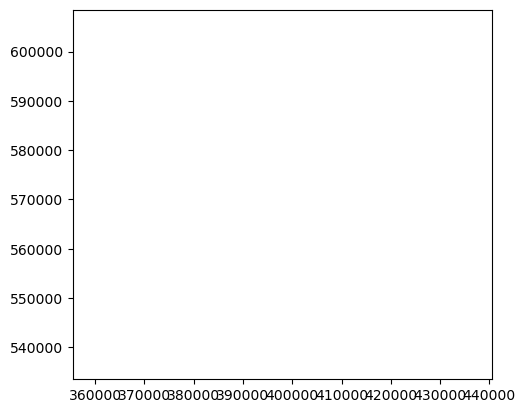

In [55]:
met_flip = np.flip(arrs, axis=1)

radar_at_src = []
for t in range(len(gauges)):
    #radar_t = abs(dates - gauges.index[t]).argmin()
    radar_at_src_t = []
    for xx, yy in zip(g_x, g_y):
        radar_at_src_t.append(met_flip[t, 
                                np.argmin(abs(ys - yy)), 
                                np.argmin(abs(xs - xx))]
                           )
    radar_at_src.append(radar_at_src_t)

    
for xx, yy in zip(g_x, g_y):
    radar_at_src.append(arrs[t, 
                            np.argmin(abs(ys - yy)) - 5: np.argmin(abs(ys - yy)) + 5, 
                            np.argmin(abs(xs - xx)) - 10: np.argmin(abs(xs - xx)) + 10]
                       )
    
    print((xx, yy), (xs[np.argmin(abs(xs - xx))], ys[np.argmin(abs(ys - yy))]),)
    
plt.imshow(arrs[t], extent=[xs.min(), xs.max(), ys.min(), ys.max()], alpha=0.5)

plt.scatter(g_x, g_y, c=radar_at_src)#gauges.iloc[t, 0:-1])
plt.colorbar()

In [59]:
len(radar_at_src), g_x.shape

(1092, (35,))

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.5104166666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0729166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4479166666666667, 0.03125, 0.09375, 0.0, 0.0, 0.0, 0.07291666666666667, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.5625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8333333333333334, 0.19791666666666666, 0.14583333333333334, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5625, 0.0, 0.6979166666666666, 0.11458333333333333, 0.23958333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.5833333333333333, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.125, 0.65625, 0.13541666666666666, 0.21875, 0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.9166666666666666, 0.3333333333333333, 0.0, 0.6145833333333334, 0.11458333333333333, 0.9895833333333334, 0.125, 0.22916666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.4895833333333333, 0.2708333333333333, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.6041666666666666, 1.2291666666666667, 0.3125, 0.5625, 0.6875, 0.0, 0.08333333333333333, 0.0, 0.0, 0.16666666666666666, 0.0625, 0.0625, 0.0, 0.10416666666666667, 1.4791666666666667, 0.5416666666666666, 0.0, 0.59375, 0.20833333333333334, 0.7604166666666666, 0.28125, 0.28125, 0.0625], [0.0, 0.0, 0.0, 0.0, 0.0, 0.4895833333333333, 0.0, 0.19791666666666666, 0.0, 0.16666666666666666, 0.17708333333333334, 1.1354166666666667, 0.3333333333333333, 0.84375, 0.3125, 0.4479166666666667, 0.3541666666666667, 0.0, 0.25, 0.125, 0.0, 0.22916666666666666, 0.0625, 0.0, 0.0, 0.23958333333333334, 1.5208333333333333, 0.53125, 0.0, 0.4583333333333333, 0.375, 0.9166666666666666, 0.3541666666666667, 0.3541666666666667, 0.16666666666666666], [0.21875, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.3541666666666667, 0.0, 0.2604166666666667, 0.3645833333333333, 1.5104166666666667, 0.25, 0.4583333333333333, 0.2708333333333333, 2.0, 0.46875, 0.40625, 0.5833333333333334, 0.5208333333333334, 0.4791666666666667, 0.14583333333333334, 0.0, 0.010416666666666666, 0.0, 0.20833333333333334, 0.6041666666666666, 0.21875, 0.0, 1.03125, 0.4895833333333333, 3.0, 5.708333333333333, 0.07291666666666667, 0.125], [0.3854166666666667, 0.10416666666666667, 0.21875, 0.0, 0.46875, 1.5520833333333333, 0.59375, 0.17708333333333334, 0.0, 0.19791666666666666, 0.3229166666666667, 1.15625, 0.22916666666666666, 0.625, 0.21875, 0.16666666666666666, 0.3958333333333333, 0.3958333333333333, 0.16666666666666666, 0.28125, 0.17708333333333334, 0.0, 0.71875, 0.0, 0.08333333333333333, 0.22916666666666666, 0.14583333333333334, 0.08333333333333333, 0.0, 0.9270833333333334, 0.65625, 0.7291666666666666, 2.59375, 0.16666666666666666, 0.09375], [0.53125, 0.375, 0.25, 0.0, 0.3541666666666667, 1.46875, 0.6875, 0.0, 0.0, 0.3541666666666667, 0.625, 1.1354166666666667, 0.4479166666666667, 0.9479166666666666, 0.3958333333333333, 0.28125, 0.20833333333333334, 0.0, 0.16666666666666666, 0.20833333333333334, 0.0625, 0.125, 1.8958333333333333, 0.020833333333333332, 0.3854166666666667, 0.4166666666666667, 0.34375, 0.14583333333333334, 0.4166666666666667, 0.6354166666666666, 0.6354166666666666, 0.65625, 0.875, 1.8020833333333333, 0.11458333333333333], [1.8020833333333333, 0.3645833333333333, 0.0625, 0.020833333333333332, 0.5208333333333334, 1.4479166666666667, 0.6145833333333334, 0.0, 0.052083333333333336, 0.4791666666666667, 0.2604166666666667, 0.7395833333333334, 2.5, 1.2708333333333333, 0.5208333333333334, 0.5416666666666666, 0.6458333333333334, 0.0, 0.4583333333333333, 0.10416666666666667, 0.0, 0.17708333333333334, 0.2708333333333333, 0.10416666666666667, 0.59375, 0.6145833333333334, 1.0729166666666667, 0.9270833333333334, 0.22916666666666666, 1.6354166666666667, 0.2708333333333333, 0.8854166666666666, 0.9166666666666666, 3.8125, 0.08333333333333333], [0.3958333333333333, 0.5, 0.21875, 0.1875, 0.65625, 1.6979166666666667, 1.0416666666666667, 0.28125, 0.3229166666666667, 0.625, 0.3854166666666667, 0.59375, 1.2916666666666667, 2.2291666666666665, 1.6875, 1.0520833333333333, 1.2083333333333333, 0.34375, 0.8854166666666666, 0.65625, 0.2916666666666667, 0.84375, 0.625, 0.5520833333333334, 0.8020833333333334, 1.6458333333333333, 1.2291666666666667, 0.4791666666666667, 0.625, 1.4479166666666667, 0.3125, 1.0416666666666667, 1.4166666666666667, 0.78125, 0.78125], [1.65625, 0.90625, 0.3541666666666667, 1.4791666666666667, 0.34375, 2.125, 1.09375, 0.9479166666666666, 2.0729166666666665, 0.8541666666666666, 0.5729166666666666, 0.4166666666666667, 1.2291666666666667, 2.5625, 1.4375, 1.2395833333333333, 1.1770833333333333, 2.5729166666666665, 1.1875, 1.2916666666666667, 1.2395833333333333, 0.8958333333333334, 1.09375, 1.4895833333333333, 3.71875, 2.6041666666666665, 2.6354166666666665, 0.8125, 1.15625, 1.625, 1.6041666666666667, 3.1354166666666665, 1.7604166666666667, 1.9583333333333333, 0.8854166666666666], [1.6666666666666667, 0.3645833333333333, 0.2916666666666667, 2.125, 1.0625, 2.6041666666666665, 1.5, 1.5104166666666667, 2.6875, 0.9895833333333334, 0.9479166666666666, 1.21875, 1.21875, 1.7604166666666667, 0.9583333333333334, 0.8958333333333334, 1.1145833333333333, 2.4375, 1.84375, 1.1145833333333333, 1.8854166666666667, 1.8541666666666667, 2.1041666666666665, 1.3020833333333333, 1.28125, 4.447916666666667, 2.6458333333333335, 1.2291666666666667, 2.3958333333333335, 1.5625, 1.65625, 1.5104166666666667, 1.34375, 1.625, 0.7291666666666666], [0.9166666666666666, 1.6875, 0.9479166666666666, 2.875, 1.78125, 3.59375, 2.03125, 1.1458333333333333, 1.7083333333333333, 1.2083333333333333, 2.7291666666666665, 1.9895833333333333, 6.333333333333333, 2.8333333333333335, 0.90625, 1.375, 1.2395833333333333, 1.3645833333333333, 2.1145833333333335, 1.4791666666666667, 1.9791666666666667, 2.25, 2.46875, 1.84375, 1.3958333333333333, 3.6979166666666665, 4.802083333333333, 2.0104166666666665, 1.9166666666666667, 2.4375, 2.1354166666666665, 1.59375, 1.4166666666666667, 1.28125, 2.0520833333333335], [2.1770833333333335, 1.6145833333333333, 1.59375, 1.8020833333333333, 1.09375, 3.4479166666666665, 1.9895833333333333, 2.3541666666666665, 2.4166666666666665, 1.7604166666666667, 1.5104166666666667, 1.9583333333333333, 1.1770833333333333, 4.3125, 1.8229166666666667, 2.0833333333333335, 1.5520833333333333, 1.90625, 2.3229166666666665, 1.5625, 2.9583333333333335, 3.1875, 3.40625, 2.5520833333333335, 2.625, 2.6875, 5.604166666666667, 2.875, 2.0833333333333335, 0.96875, 1.09375, 1.4479166666666667, 1.6875, 0.8958333333333334, 1.9583333333333333], [2.9270833333333335, 1.53125, 4.802083333333333, 2.9270833333333335, 2.0, 3.5625, 2.03125, 4.53125, 2.2916666666666665, 1.40625, 1.3333333333333333, 2.71875, 0.1875, 0.7083333333333334, 0.11458333333333333, 0.9583333333333334, 1.0520833333333333, 4.5625, 0.8645833333333334, 2.4583333333333335, 7.427083333333333, 4.3125, 2.6770833333333335, 3.15625, 1.8854166666666667, 0.3645833333333333, 5.947916666666667, 4.177083333333333, 2.2083333333333335, 0.3958333333333333, 1.1979166666666667, 1.6666666666666667, 0.375, 0.9479166666666666, 2.6041666666666665], [1.65625, 1.7395833333333333, 4.09375, 2.6145833333333335, 5.520833333333333, 5.59375, 2.8125, 7.96875, 2.5, 1.125, 1.0416666666666667, 2.0416666666666665, 0.03125, 0.010416666666666666, 0.0625, 0.11458333333333333, 0.5520833333333334, 7.520833333333333, 0.14583333333333334, 2.65625, 5.28125, 3.3333333333333335, 5.3125, 2.8854166666666665, 1.8854166666666667, 0.125, 3.0729166666666665, 3.1770833333333335, 1.9583333333333333, 0.08333333333333333, 0.7708333333333334, 0.59375, 0.1875, 0.9375, 3.34375], [2.6770833333333335, 5.458333333333333, 4.385416666666667, 2.2604166666666665, 13.53125, 13.15625, 11.4375, 4.260416666666667, 3.6666666666666665, 0.9375, 0.25, 1.71875, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 1.7395833333333333, 0.0, 0.14583333333333334, 4.104166666666667, 10.541666666666666, 6.458333333333333, 7.645833333333333, 0.6145833333333334, 0.010416666666666666, 2.3958333333333335, 5.145833333333333, 3.0104166666666665, 0.0, 0.3958333333333333, 0.4166666666666667, 0.052083333333333336, 0.0625, 5.854166666666667], [2.3125, 7.020833333333333, 2.90625, 5.3125, 2.28125, 1.8958333333333333, 6.791666666666667, 1.8125, 4.510416666666667, 0.3020833333333333, 0.17708333333333334, 0.9375, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.90625, 0.08333333333333333, 0.020833333333333332, 4.479166666666667, 6.625, 3.09375, 6.802083333333333, 2.4270833333333335, 0.03125, 2.1041666666666665, 1.3020833333333333, 2.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 4.15625], [0.96875, 1.8645833333333333, 7.072916666666667, 4.572916666666667, 2.6041666666666665, 0.3645833333333333, 1.5729166666666667, 2.6041666666666665, 5.03125, 0.13541666666666666, 0.020833333333333332, 0.8229166666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.5729166666666666, 0.16666666666666666, 0.2604166666666667, 3.8854166666666665, 3.6979166666666665, 5.229166666666667, 3.3854166666666665, 2.84375, 0.17708333333333334, 1.9791666666666667, 1.03125, 2.5208333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5], [0.22916666666666666, 3.1145833333333335, 7.833333333333333, 2.53125, 2.0, 0.3854166666666667, 2.6354166666666665, 1.0104166666666667, 3.5729166666666665, 0.0, 0.0, 0.2708333333333333, 0.16666666666666666, 0.0, 0.0625, 0.0, 0.0, 0.4583333333333333, 0.21875, 0.34375, 2.2604166666666665, 3.2291666666666665, 3.6354166666666665, 3.625, 2.0833333333333335, 0.4166666666666667, 0.625, 2.125, 5.010416666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0], [0.40625, 1.7395833333333333, 2.5520833333333335, 4.03125, 0.40625, 0.5, 1.03125, 0.22916666666666666, 2.8541666666666665, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.13541666666666666, 0.0, 0.0, 0.375, 0.8125, 0.23958333333333334, 0.3333333333333333, 4.71875, 3.3541666666666665, 4.104166666666667, 1.25, 0.8125, 1.7916666666666667, 1.3958333333333333, 2.78125, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4479166666666665], [0.3020833333333333, 0.625, 2.9375, 1.6979166666666667, 0.28125, 1.71875, 0.6666666666666666, 0.7916666666666666, 2.2291666666666665, 0.0, 0.041666666666666664, 0.0, 0.5208333333333334, 0.0, 0.08333333333333333, 0.0, 0.020833333333333332, 0.4166666666666667, 0.19791666666666666, 0.3645833333333333, 0.20833333333333334, 3.96875, 4.177083333333333, 2.625, 5.385416666666667, 0.53125, 3.4791666666666665, 4.416666666666667, 3.2708333333333335, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2083333333333335], [0.19791666666666666, 0.3645833333333333, 2.8229166666666665, 2.8645833333333335, 0.23958333333333334, 2.0625, 0.4895833333333333, 0.4895833333333333, 3.7604166666666665, 0.0, 0.11458333333333333, 0.0, 0.3541666666666667, 0.9583333333333334, 0.11458333333333333, 0.0, 0.0, 1.0625, 0.6666666666666666, 0.6875, 0.7083333333333334, 4.333333333333333, 3.7083333333333335, 4.729166666666667, 5.34375, 0.7395833333333334, 3.1354166666666665, 2.8333333333333335, 7.510416666666667, 0.15625, 0.0, 0.0, 0.17708333333333334, 0.0, 4.0625], [0.10416666666666667, 0.21875, 3.2291666666666665, 4.302083333333333, 0.3020833333333333, 2.2604166666666665, 0.65625, 2.2083333333333335, 3.71875, 0.0, 0.052083333333333336, 0.08333333333333333, 0.11458333333333333, 0.10416666666666667, 0.34375, 0.07291666666666667, 0.23958333333333334, 1.5, 0.71875, 0.90625, 3.3645833333333335, 3.8020833333333335, 3.8020833333333335, 2.71875, 3.6145833333333335, 1.125, 5.020833333333333, 1.9583333333333333, 4.135416666666667, 0.25, 0.0, 0.0, 0.3125, 0.0, 2.4375], [0.0625, 0.5833333333333334, 1.3020833333333333, 3.8125, 3.53125, 2.5625, 1.625, 5.020833333333333, 2.9895833333333335, 0.0, 0.7083333333333334, 0.0, 1.125, 1.28125, 0.11458333333333333, 0.0625, 0.13541666666666666, 4.6875, 0.3645833333333333, 0.6666666666666666, 4.229166666666667, 4.791666666666667, 1.875, 2.8020833333333335, 3.1145833333333335, 0.4166666666666667, 3.8229166666666665, 1.7708333333333333, 2.5416666666666665, 0.2604166666666667, 0.14583333333333334, 0.3229166666666667, 0.03125, 0.13541666666666666, 3.84375], [0.22916666666666666, 2.9270833333333335, 5.010416666666667, 4.0625, 4.479166666666667, 5.71875, 4.979166666666667, 3.6666666666666665, 5.5, 0.03125, 0.5625, 0.0, 0.13541666666666666, 0.8541666666666666, 0.25, 0.5208333333333334, 0.2916666666666667, 1.3229166666666667, 0.65625, 0.6354166666666666, 4.0625, 2.1979166666666665, 5.552083333333333, 2.9895833333333335, 4.885416666666667, 0.6666666666666666, 2.625, 2.8958333333333335, 4.927083333333333, 0.6875, 0.13541666666666666, 0.020833333333333332, 0.2604166666666667, 0.03125, 3.03125], [1.1354166666666667, 5.5625, 5.447916666666667, 3.5729166666666665, 5.083333333333333, 5.114583333333333, 5.0, 4.791666666666667, 4.427083333333333, 0.08333333333333333, 0.3020833333333333, 0.5416666666666666, 0.0, 0.6041666666666666, 0.10416666666666667, 0.13541666666666666, 0.28125, 4.84375, 0.4166666666666667, 1.4583333333333333, 4.875, 4.145833333333333, 3.8958333333333335, 5.739583333333333, 4.572916666666667, 0.90625, 1.9270833333333333, 1.96875, 6.552083333333333, 0.20833333333333334, 0.16666666666666666, 0.8645833333333334, 0.0625, 0.041666666666666664, 5.385416666666667], [0.9791666666666666, 2.96875, 2.25, 5.114583333333333, 4.895833333333333, 4.916666666666667, 4.5, 4.1875, 8.145833333333334, 0.0, 0.34375, 0.020833333333333332, 0.7083333333333334, 0.7291666666666666, 0.13541666666666666, 0.3854166666666667, 0.14583333333333334, 2.15625, 1.0104166666666667, 2.2083333333333335, 2.75, 5.395833333333333, 2.0, 4.229166666666667, 2.7916666666666665, 1.28125, 0.71875, 2.1979166666666665, 4.0625, 0.010416666666666666, 0.1875, 0.6041666666666666, 0.0, 0.2916666666666667, 3.09375], [2.5520833333333335, 4.520833333333333, 4.416666666666667, 6.09375, 3.6041666666666665, 4.364583333333333, 6.34375, 3.3958333333333335, 5.947916666666667, 0.09375, 0.22916666666666666, 0.8229166666666666, 0.9583333333333334, 0.0625, 0.22916666666666666, 0.21875, 0.03125, 1.9791666666666667, 0.8333333333333334, 1.8125, 1.0104166666666667, 4.104166666666667, 0.8333333333333334, 4.5625, 1.2916666666666667, 0.84375, 0.13541666666666666, 0.4791666666666667, 1.3541666666666667, 0.2708333333333333, 0.46875, 0.08333333333333333, 0.0, 0.11458333333333333, 2.34375], [3.1458333333333335, 2.8854166666666665, 5.052083333333333, 3.25, 3.3958333333333335, 3.1666666666666665, 2.9791666666666665, 2.1875, 2.5625, 0.11458333333333333, 0.10416666666666667, 6.4375, 0.28125, 0.6354166666666666, 0.8229166666666666, 0.020833333333333332, 0.2708333333333333, 2.6875, 0.3645833333333333, 0.8333333333333334, 1.1979166666666667, 0.7604166666666666, 0.3854166666666667, 1.875, 1.1145833333333333, 0.16666666666666666, 0.052083333333333336, 0.125, 0.5520833333333334, 0.22916666666666666, 0.16666666666666666, 0.4583333333333333, 0.0, 0.09375, 0.7708333333333334], [1.0208333333333333, 1.875, 2.34375, 2.5625, 2.3541666666666665, 3.0833333333333335, 2.8854166666666665, 1.1145833333333333, 1.8125, 0.2604166666666667, 0.15625, 0.875, 0.08333333333333333, 0.34375, 0.4166666666666667, 0.34375, 0.1875, 1.2708333333333333, 0.6145833333333334, 1.3958333333333333, 0.16666666666666666, 0.65625, 0.6666666666666666, 0.34375, 0.6041666666666666, 0.2708333333333333, 0.020833333333333332, 0.020833333333333332, 0.16666666666666666, 0.40625, 0.07291666666666667, 0.3645833333333333, 0.052083333333333336, 0.19791666666666666, 0.22916666666666666], [0.40625, 2.71875, 1.0416666666666667, 0.5833333333333334, 0.9895833333333334, 2.4895833333333335, 1.6041666666666667, 0.2604166666666667, 0.75, 2.7708333333333335, 0.21875, 0.5833333333333334, 0.5208333333333334, 0.20833333333333334, 0.15625, 0.15625, 0.4270833333333333, 1.8645833333333333, 0.1875, 1.0729166666666667, 0.020833333333333332, 0.5416666666666666, 0.4375, 0.125, 0.5, 0.11458333333333333, 0.0, 0.010416666666666666, 0.13541666666666666, 0.4895833333333333, 0.34375, 0.052083333333333336, 0.1875, 0.11458333333333333, 0.0625], [0.14583333333333334, 1.7291666666666667, 0.40625, 0.3854166666666667, 0.53125, 2.59375, 0.9270833333333334, 0.3541666666666667, 0.25, 3.9583333333333335, 0.09375, 1.0625, 0.3333333333333333, 0.40625, 0.5104166666666666, 0.13541666666666666, 0.3854166666666667, 0.5729166666666666, 0.13541666666666666, 0.6979166666666666, 0.2916666666666667, 0.08333333333333333, 0.3645833333333333, 0.3020833333333333, 0.2708333333333333, 0.10416666666666667, 0.0, 0.0, 0.041666666666666664, 0.8645833333333334, 0.125, 0.8125, 0.11458333333333333, 0.11458333333333333, 0.17708333333333334], [0.0, 0.9895833333333334, 0.11458333333333333, 0.15625, 0.65625, 2.28125, 1.0104166666666667, 0.4895833333333333, 0.17708333333333334, 3.6666666666666665, 0.11458333333333333, 0.5, 1.1875, 0.20833333333333334, 0.3125, 0.20833333333333334, 0.2916666666666667, 0.6666666666666666, 0.07291666666666667, 0.14583333333333334, 0.19791666666666666, 0.0, 0.09375, 0.3541666666666667, 0.16666666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.4166666666666667, 0.28125, 1.9375, 0.16666666666666666, 0.2916666666666667, 0.3125], [0.07291666666666667, 1.9479166666666667, 0.052083333333333336, 0.20833333333333334, 1.0520833333333333, 1.9375, 1.1354166666666667, 0.6875, 0.2604166666666667, 3.78125, 0.34375, 0.1875, 0.3854166666666667, 0.19791666666666666, 0.10416666666666667, 0.10416666666666667, 0.625, 0.2916666666666667, 0.16666666666666666, 0.625, 0.2604166666666667, 0.010416666666666666, 0.0, 0.28125, 0.052083333333333336, 0.07291666666666667, 0.0, 0.0, 0.0, 0.78125, 0.28125, 1.34375, 0.0, 0.1875, 0.3958333333333333], [0.08333333333333333, 0.625, 0.0, 0.08333333333333333, 0.4791666666666667, 1.9375, 1.2083333333333333, 0.125, 0.11458333333333333, 2.6354166666666665, 0.10416666666666667, 0.3958333333333333, 0.10416666666666667, 0.09375, 0.10416666666666667, 0.13541666666666666, 0.2916666666666667, 0.4479166666666667, 0.14583333333333334, 0.17708333333333334, 0.10416666666666667, 0.0, 0.0, 0.041666666666666664, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.3645833333333333, 0.5833333333333334, 0.78125, 0.3229166666666667, 0.17708333333333334, 0.052083333333333336], [0.46875, 0.3541666666666667, 0.0, 0.0, 0.2708333333333333, 2.0729166666666665, 0.9166666666666666, 0.0, 0.0, 2.5, 0.5104166666666666, 1.6458333333333333, 0.041666666666666664, 0.020833333333333332, 0.03125, 0.041666666666666664, 0.08333333333333333, 0.2604166666666667, 0.15625, 0.22916666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.3645833333333333, 0.3125, 0.25, 0.16666666666666666, 0.125, 0.0], [0.7083333333333334, 0.17708333333333334, 0.0, 0.0, 0.03125, 1.46875, 0.5416666666666666, 0.0, 0.0, 0.7395833333333334, 0.2708333333333333, 1.6041666666666667, 0.16666666666666666, 0.07291666666666667, 0.4583333333333333, 0.2604166666666667, 0.5833333333333334, 0.10416666666666667, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.041666666666666664, 0.5208333333333334, 0.4270833333333333, 0.052083333333333336, 0.13541666666666666, 0.0], [0.5520833333333334, 0.22916666666666666, 0.0, 0.0, 0.0, 0.75, 0.20833333333333334, 0.0, 0.0, 0.5208333333333334, 0.3125, 2.5833333333333335, 0.041666666666666664, 0.010416666666666666, 0.020833333333333332, 0.15625, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.8333333333333334, 0.16666666666666666, 0.0, 0.15625, 0.0], [0.15625, 0.13541666666666666, 0.0, 0.0, 0.0, 0.65625, 0.0, 0.0, 0.0, 0.3645833333333333, 0.8958333333333334, 1.125, 0.0, 0.0, 0.0, 0.0, 0.5, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0], [0.9791666666666666, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 0.0, 0.22916666666666666, 0.2708333333333333, 0.4895833333333333, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0], [0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.22916666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0], [0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9270833333333334, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1770833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.09375, 0.0, 0.0, 1.3541666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.802083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.59375, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.8125, 2.0625, 0.7708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6770833333333334, 0.0, 0.3958333333333333, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 5.09375, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 4.15625, 0.0, 0.052083333333333336, 0.020833333333333332, 1.2604166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.010416666666666666, 4.020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.11458333333333333, 0.0, 0.11458333333333333, 0.0, 1.7291666666666667, 0.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.19791666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.125, 0.0, 0.0, 1.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.53125, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667], [0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.4895833333333333, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.3541666666666667, 2.8854166666666665, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.1875, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.4583333333333333, 0.0, 0.03125, 0.10416666666666667, 0.0, 0.13541666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 1.6979166666666667, 0.052083333333333336, 0.5208333333333334, 0.5104166666666666, 3.5625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.041666666666666664, 0.07291666666666667, 0.08333333333333333, 0.0, 0.125, 0.09375, 0.2916666666666667, 0.71875, 0.0, 0.0, 0.23958333333333334, 0.0, 0.10416666666666667, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7395833333333335, 0.17708333333333334, 0.0, 0.4479166666666667, 3.5208333333333335, 0.0], [0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.14583333333333334, 0.0, 0.5, 0.16666666666666666, 0.15625, 0.041666666666666664, 0.15625, 1.7916666666666667, 0.5208333333333334, 1.0104166666666667, 0.0, 0.0625, 0.3229166666666667, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.6979166666666665, 1.21875, 0.3541666666666667, 0.375, 2.7291666666666665, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.7604166666666666, 0.13541666666666666, 0.5, 0.041666666666666664, 0.19791666666666666, 2.5520833333333335, 0.3854166666666667, 1.0520833333333333, 0.0, 0.07291666666666667, 0.4583333333333333, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 2.5833333333333335, 1.6666666666666667, 0.8020833333333334, 0.20833333333333334, 3.09375, 0.0], [0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.3229166666666667, 0.20833333333333334, 0.11458333333333333, 0.0, 0.6666666666666666, 0.052083333333333336, 1.1041666666666667, 0.3541666666666667, 0.041666666666666664, 1.6666666666666667, 0.07291666666666667, 0.8333333333333334, 0.0, 0.10416666666666667, 0.5520833333333334, 0.0, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.8229166666666666, 1.7395833333333333, 0.4895833333333333, 0.0, 3.5729166666666665, 0.0], [0.15625, 0.09375, 0.0, 0.0, 0.0, 0.2604166666666667, 0.16666666666666666, 0.5104166666666666, 0.0, 0.19791666666666666, 0.34375, 0.9895833333333334, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.21875, 0.125, 0.09375, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.03125, 0.0, 0.0, 1.2604166666666667, 0.0, 0.0, 0.0, 0.0], [0.052083333333333336, 0.15625, 0.09375, 0.0, 0.0625, 0.17708333333333334, 0.2604166666666667, 0.0, 0.0, 0.3854166666666667, 0.14583333333333334, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.25, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.14583333333333334, 0.3020833333333333, 0.0, 0.0, 0.20833333333333334, 0.2604166666666667, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4791666666666667, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3125, 0.3020833333333333, 0.0, 0.0, 0.0, 0.11458333333333333, 0.03125, 0.09375, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.041666666666666664, 0.0, 2.59375, 0.0, 0.0, 0.0, 0.0, 0.0], [0.23958333333333334, 0.14583333333333334, 0.0, 0.0, 0.0, 0.13541666666666666, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0625, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.020833333333333332, 0.16666666666666666, 0.0, 2.96875, 0.0, 0.0, 0.5208333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.19791666666666666, 1.8854166666666667, 0.14583333333333334, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.041666666666666664, 0.0, 2.8645833333333335, 0.0, 0.0, 0.375, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0625, 2.7395833333333335, 0.07291666666666667, 0.010416666666666666, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.020833333333333332, 0.0, 0.0, 2.5416666666666665, 0.0, 0.0625, 0.16666666666666666, 1.2291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.125, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3125, 1.8645833333333333, 0.07291666666666667, 0.3645833333333333, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.17708333333333334, 0.08333333333333333, 0.08333333333333333, 0.0, 1.5520833333333333, 0.5520833333333334, 0.0, 0.125, 1.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0625, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.16666666666666666, 0.2916666666666667, 0.8958333333333334, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.13541666666666666, 0.21875, 0.22916666666666666, 0.0, 1.5520833333333333, 0.15625, 0.20833333333333334, 0.15625, 1.2708333333333333, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.22916666666666666, 0.2916666666666667, 0.0, 0.0, 0.09375, 0.14583333333333334, 0.0, 0.125, 0.15625, 0.08333333333333333, 0.125, 1.2395833333333333, 0.0, 0.14583333333333334, 0.0625, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.125, 0.11458333333333333, 0.28125, 0.0, 0.5833333333333334, 0.3229166666666667, 0.15625, 0.21875, 1.3541666666666667, 0.0], [0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.46875, 0.5, 0.010416666666666666, 0.0, 0.08333333333333333, 0.20833333333333334, 0.14583333333333334, 0.14583333333333334, 0.5520833333333334, 1.7395833333333333, 0.23958333333333334, 0.17708333333333334, 0.03125, 0.041666666666666664, 0.21875, 0.03125, 0.0, 0.3854166666666667, 0.0, 0.0, 0.041666666666666664, 0.4583333333333333, 0.15625, 0.0, 0.75, 0.6041666666666666, 0.5625, 0.3958333333333333, 1.3541666666666667, 0.0], [0.3229166666666667, 0.4791666666666667, 0.020833333333333332, 0.03125, 0.125, 1.09375, 0.9166666666666666, 0.20833333333333334, 0.010416666666666666, 0.1875, 0.21875, 0.0, 0.375, 0.75, 0.3229166666666667, 0.20833333333333334, 0.3229166666666667, 0.10416666666666667, 0.28125, 0.34375, 0.20833333333333334, 0.052083333333333336, 0.2604166666666667, 0.010416666666666666, 0.0, 0.09375, 0.08333333333333333, 0.14583333333333334, 0.020833333333333332, 0.5416666666666666, 0.40625, 0.5729166666666666, 0.20833333333333334, 2.0520833333333335, 0.0], [0.3229166666666667, 0.53125, 0.07291666666666667, 0.0625, 0.59375, 0.8541666666666666, 1.28125, 0.20833333333333334, 0.010416666666666666, 0.17708333333333334, 0.23958333333333334, 0.0, 0.4270833333333333, 0.4895833333333333, 0.3125, 0.11458333333333333, 0.125, 0.7395833333333334, 0.28125, 0.34375, 0.19791666666666666, 0.0625, 0.22916666666666666, 0.010416666666666666, 0.07291666666666667, 0.3645833333333333, 0.15625, 0.10416666666666667, 0.19791666666666666, 0.3020833333333333, 0.5729166666666666, 0.2604166666666667, 0.3020833333333333, 0.8020833333333334, 0.010416666666666666], [0.03125, 0.7916666666666666, 0.13541666666666666, 0.17708333333333334, 0.3229166666666667, 0.6770833333333334, 0.6145833333333334, 0.13541666666666666, 0.08333333333333333, 0.22916666666666666, 0.041666666666666664, 1.0416666666666667, 0.041666666666666664, 0.07291666666666667, 0.10416666666666667, 0.041666666666666664, 0.07291666666666667, 0.22916666666666666, 0.125, 0.3125, 0.25, 0.625, 0.14583333333333334, 0.20833333333333334, 0.010416666666666666, 0.11458333333333333, 0.3333333333333333, 0.13541666666666666, 0.010416666666666666, 0.010416666666666666, 0.041666666666666664, 0.03125, 0.3229166666666667, 0.0, 0.3125], [0.4895833333333333, 0.4583333333333333, 0.3125, 0.2916666666666667, 0.03125, 0.17708333333333334, 0.2916666666666667, 0.11458333333333333, 0.2916666666666667, 0.0, 0.0, 0.375, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.07291666666666667, 0.0, 0.041666666666666664, 0.09375, 0.375, 0.4791666666666667, 0.3854166666666667, 0.14583333333333334, 0.0, 0.19791666666666666, 0.15625, 0.19791666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4270833333333333], [0.6458333333333334, 0.052083333333333336, 0.3333333333333333, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.9479166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.3229166666666667, 0.041666666666666664, 0.3645833333333333, 0.0, 0.052083333333333336, 0.22916666666666666, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667], [0.2708333333333333, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.15625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.3333333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.020833333333333332, 0.03125, 0.0, 0.4791666666666667, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4479166666666667, 0.20833333333333334, 0.0, 0.3125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.2604166666666667, 0.0, 0.4270833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.125, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.28125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.015625, 0.0, 0.046875, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.15625, 0.3020833333333333, 0.1875, 2.15625, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.052083333333333336, 0.0, 0.3020833333333333, 0.03125, 0.010416666666666666, 0.03125, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.2916666666666667, 0.3333333333333333, 0.0, 0.2708333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.22916666666666666, 0.22916666666666666, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.3020833333333333, 0.041666666666666664, 0.0, 0.3229166666666667, 0.4166666666666667, 0.0, 0.0, 0.0, 1.15625, 0.0, 0.010416666666666666, 0.125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 1.4166666666666667, 0.041666666666666664, 0.0, 1.875, 0.19791666666666666, 0.07291666666666667, 0.09375, 0.041666666666666664, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.0, 0.9270833333333334, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.5520833333333334, 0.9895833333333334, 0.14583333333333334, 0.03125, 0.0625, 0.8541666666666666, 0.052083333333333336, 0.0, 0.4166666666666667, 0.08333333333333333, 0.08333333333333333, 0.0, 0.0, 0.23958333333333334, 3.3229166666666665, 0.34375, 0.0, 2.03125, 0.03125, 0.5833333333333334, 0.3020833333333333, 0.9270833333333334, 1.2916666666666667], [1.1770833333333333, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.7395833333333334, 0.71875, 0.5, 0.14583333333333334, 0.09375, 0.0, 0.10416666666666667, 0.0, 0.041666666666666664, 0.9166666666666666, 0.4791666666666667, 1.3125, 0.0, 0.1875, 3.7395833333333335, 1.34375, 0.3020833333333333, 1.9270833333333333, 0.1875, 0.14583333333333334, 1.1354166666666667, 0.2708333333333333, 2.6145833333333335], [1.1875, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.041666666666666664, 0.020833333333333332, 0.6666666666666666, 0.3020833333333333, 0.03125, 0.03125, 0.7083333333333334, 0.6875, 0.3645833333333333, 0.16666666666666666, 0.16666666666666666, 0.020833333333333332, 0.25, 0.13541666666666666, 0.07291666666666667, 0.46875, 3.3645833333333335, 1.0416666666666667, 0.20833333333333334, 0.7916666666666666, 2.375, 0.7083333333333334, 0.5625, 2.875, 0.19791666666666666, 0.8541666666666666, 0.75, 0.25, 0.90625], [1.4270833333333333, 0.1875, 0.0, 0.03125, 0.020833333333333332, 0.6041666666666666, 0.03125, 0.78125, 0.5208333333333334, 0.15625, 0.010416666666666666, 0.08333333333333333, 0.9166666666666666, 1.2083333333333333, 0.3125, 0.09375, 0.19791666666666666, 1.4791666666666667, 0.20833333333333334, 0.13541666666666666, 0.16666666666666666, 0.4166666666666667, 3.3333333333333335, 0.40625, 0.46875, 0.59375, 1.1041666666666667, 0.5104166666666666, 3.8125, 2.2395833333333335, 0.3541666666666667, 0.3958333333333333, 0.3645833333333333, 0.4270833333333333, 1.5833333333333333], [0.2708333333333333, 0.40625, 0.020833333333333332, 0.13541666666666666, 0.052083333333333336, 0.4166666666666667, 0.125, 0.6458333333333334, 0.052083333333333336, 0.5833333333333334, 0.125, 0.1875, 0.6458333333333334, 0.4375, 0.2708333333333333, 0.07291666666666667, 0.2604166666666667, 0.3854166666666667, 0.22916666666666666, 0.19791666666666666, 0.7708333333333334, 1.2916666666666667, 3.34375, 0.53125, 2.90625, 0.5, 0.9270833333333334, 0.8541666666666666, 4.552083333333333, 0.6458333333333334, 0.5520833333333334, 0.4583333333333333, 0.3333333333333333, 2.7083333333333335, 2.2291666666666665], [0.40625, 0.22916666666666666, 0.10416666666666667, 0.25, 0.15625, 0.5208333333333334, 0.10416666666666667, 0.96875, 0.020833333333333332, 1.375, 0.19791666666666666, 0.13541666666666666, 0.7708333333333334, 0.15625, 0.59375, 0.3645833333333333, 0.19791666666666666, 0.3125, 0.21875, 0.2708333333333333, 1.71875, 1.6979166666666667, 2.5416666666666665, 0.3125, 3.53125, 0.34375, 0.53125, 0.53125, 1.1875, 1.2083333333333333, 0.65625, 0.17708333333333334, 0.84375, 1.3333333333333333, 3.1875], [0.53125, 0.3854166666666667, 0.13541666666666666, 0.3125, 0.3125, 0.375, 0.07291666666666667, 0.3541666666666667, 0.25, 3.2083333333333335, 0.09375, 0.6458333333333334, 0.375, 0.125, 0.17708333333333334, 0.13541666666666666, 0.3645833333333333, 0.3229166666666667, 0.125, 0.09375, 0.46875, 1.2395833333333333, 3.5625, 0.5833333333333334, 1.6875, 0.17708333333333334, 0.17708333333333334, 0.3541666666666667, 2.125, 2.875, 0.052083333333333336, 0.09375, 0.5729166666666666, 0.625, 0.6666666666666666], [1.40625, 0.90625, 0.13541666666666666, 0.21875, 0.2708333333333333, 0.34375, 0.14583333333333334, 0.2604166666666667, 0.10416666666666667, 2.5208333333333335, 0.020833333333333332, 2.2083333333333335, 0.20833333333333334, 0.4479166666666667, 2.7916666666666665, 0.09375, 0.2916666666666667, 0.5520833333333334, 0.14583333333333334, 0.13541666666666666, 0.65625, 1.6666666666666667, 2.7083333333333335, 0.3645833333333333, 3.28125, 0.052083333333333336, 0.5520833333333334, 0.07291666666666667, 2.4583333333333335, 3.4375, 0.7916666666666666, 0.3125, 0.46875, 1.4270833333333333, 0.96875], [1.0833333333333333, 2.0729166666666665, 0.375, 0.3958333333333333, 0.125, 0.21875, 0.3020833333333333, 0.5104166666666666, 0.1875, 0.4270833333333333, 0.11458333333333333, 1.9791666666666667, 0.21875, 0.5, 0.3541666666666667, 0.19791666666666666, 0.3125, 0.5416666666666666, 0.16666666666666666, 0.20833333333333334, 0.5729166666666666, 1.5208333333333333, 0.3020833333333333, 0.6770833333333334, 1.7395833333333333, 0.08333333333333333, 0.2916666666666667, 0.07291666666666667, 0.8645833333333334, 0.84375, 0.3229166666666667, 0.4479166666666667, 0.22916666666666666, 0.3645833333333333, 0.6354166666666666], [0.20833333333333334, 0.4583333333333333, 1.0208333333333333, 0.34375, 0.10416666666666667, 0.19791666666666666, 0.23958333333333334, 0.4479166666666667, 0.23958333333333334, 0.22916666666666666, 0.052083333333333336, 0.14583333333333334, 0.17708333333333334, 0.7291666666666666, 0.17708333333333334, 0.15625, 0.041666666666666664, 0.8854166666666666, 0.020833333333333332, 0.14583333333333334, 0.4895833333333333, 1.0208333333333333, 0.19791666666666666, 0.3854166666666667, 0.23958333333333334, 0.0625, 0.2916666666666667, 0.23958333333333334, 0.28125, 0.0, 0.14583333333333334, 0.5729166666666666, 0.0, 1.0, 0.2916666666666667], [0.08333333333333333, 0.22916666666666666, 0.6458333333333334, 0.7395833333333334, 0.11458333333333333, 0.0, 0.0625, 0.17708333333333334, 0.1875, 0.6666666666666666, 0.09375, 0.3020833333333333, 0.052083333333333336, 0.0, 0.020833333333333332, 0.0, 0.0, 0.46875, 0.0, 0.3229166666666667, 0.20833333333333334, 0.7708333333333334, 1.3125, 0.28125, 0.84375, 0.010416666666666666, 0.0, 0.0625, 2.8854166666666665, 0.0, 0.5208333333333334, 0.21875, 0.0, 2.5416666666666665, 0.4895833333333333], [0.4166666666666667, 0.09375, 0.2604166666666667, 0.1875, 0.03125, 0.5, 0.041666666666666664, 0.1875, 0.09375, 0.2708333333333333, 0.11458333333333333, 0.875, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.4270833333333333, 0.0, 0.09375, 0.09375, 0.6145833333333334, 0.5416666666666666, 0.17708333333333334, 1.3333333333333333, 0.0, 0.28125, 0.0, 0.9166666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.40625], [1.3854166666666667, 0.7291666666666666, 0.10416666666666667, 0.0, 0.125, 0.6145833333333334, 0.14583333333333334, 0.10416666666666667, 0.0, 0.3229166666666667, 0.0, 0.3229166666666667, 0.625, 0.4791666666666667, 0.20833333333333334, 0.041666666666666664, 0.0, 0.0625, 0.0, 0.0, 0.08333333333333333, 0.052083333333333336, 0.041666666666666664, 0.052083333333333336, 0.3541666666666667, 0.11458333333333333, 0.3125, 0.0, 0.0625, 0.5625, 0.020833333333333332, 0.2916666666666667, 0.3854166666666667, 0.5, 0.11458333333333333], [0.19791666666666666, 0.6979166666666666, 0.625, 0.03125, 0.03125, 0.4270833333333333, 0.125, 0.0, 0.010416666666666666, 0.11458333333333333, 0.010416666666666666, 0.4479166666666667, 0.22916666666666666, 0.052083333333333336, 0.041666666666666664, 0.03125, 0.13541666666666666, 0.03125, 0.08333333333333333, 0.0, 0.03125, 0.17708333333333334, 0.19791666666666666, 0.09375, 0.052083333333333336, 0.40625, 0.0, 0.0, 0.0, 0.020833333333333332, 0.052083333333333336, 0.4270833333333333, 0.0, 1.09375, 0.14583333333333334], [0.5416666666666666, 0.13541666666666666, 0.96875, 0.041666666666666664, 0.0, 0.20833333333333334, 0.03125, 0.0, 0.0, 0.9375, 0.09375, 0.0, 0.09375, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.28125, 0.0625, 0.0625, 0.0, 0.14583333333333334, 0.0, 0.2916666666666667, 0.0, 0.4583333333333333, 0.0, 0.010416666666666666], [1.2083333333333333, 0.34375, 0.3020833333333333, 0.0, 0.0, 0.0625, 0.13541666666666666, 0.0, 0.0, 0.19791666666666666, 0.0, 0.7395833333333334, 0.8541666666666666, 1.0520833333333333, 0.6354166666666666, 0.041666666666666664, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.15625, 0.0, 0.010416666666666666, 0.03125, 0.5833333333333334, 0.0, 0.052083333333333336, 0.3125, 1.0520833333333333, 0.0], [0.6875, 0.22916666666666666, 0.5833333333333334, 0.0, 0.0, 0.2916666666666667, 0.0625, 0.0, 0.0, 0.5104166666666666, 0.0, 0.03125, 0.7916666666666666, 0.34375, 0.375, 0.125, 0.07291666666666667, 0.0, 0.3854166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.6979166666666666, 0.0, 0.0, 0.0, 1.0104166666666667, 0.0625, 0.2708333333333333, 0.0625, 0.625, 0.0], [0.0, 0.0, 0.59375, 0.10416666666666667, 0.0, 0.0, 0.010416666666666666, 0.0, 0.11458333333333333, 0.7916666666666666, 0.10416666666666667, 0.17708333333333334, 0.0625, 0.010416666666666666, 0.07291666666666667, 0.23958333333333334, 0.020833333333333332, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.14583333333333334, 0.0, 0.0, 0.0, 0.052083333333333336, 0.46875, 0.052083333333333336, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.010416666666666666, 0.34375, 0.020833333333333332, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.125, 0.0625, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.25, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.16666666666666666, 0.041666666666666664, 0.0625, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 0.03125, 0.0625, 1.0208333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.03125, 0.28125, 0.20833333333333334, 0.19791666666666666, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.16666666666666666, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.03125, 0.0, 0.0625, 0.0, 0.0, 0.052083333333333336, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.20833333333333334, 0.20833333333333334, 0.13541666666666666, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.10416666666666667, 0.07291666666666667, 0.2708333333333333, 0.0], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.11458333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.5, 0.03125, 0.10416666666666667, 0.0], [0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.125, 0.010416666666666666, 0.16666666666666666, 0.16666666666666666, 0.052083333333333336, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.375, 0.0, 0.5625, 0.0], [0.03125, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.15625, 0.09375, 0.21875, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.3229166666666667, 0.0, 0.96875, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.11458333333333333, 0.0, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.14583333333333334, 0.0, 0.7708333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.2708333333333333, 0.0, 0.4479166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.10416666666666667, 0.010416666666666666, 1.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.3854166666666667, 0.15625, 0.19791666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.20833333333333334, 0.4270833333333333, 0.07291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.03125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.3125, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3333333333333333, 0.0, 0.4270833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.2916666666666667, 0.0, 0.59375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.25, 0.0, 0.16666666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.15625, 0.041666666666666664, 1.7395833333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3645833333333333, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.125, 1.125, 1.5104166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.09375, 0.10416666666666667, 0.8645833333333334, 0.6041666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.13541666666666666, 0.8541666666666666, 0.8645833333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.020833333333333332, 0.2604166666666667, 0.3229166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.09375, 0.15625, 0.09375, 0.0, 0.041666666666666664, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.010416666666666666, 0.09375, 0.03125, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.4270833333333333, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0625, 0.010416666666666666, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.90625, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.16666666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.14583333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2291666666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3125, 0.15625, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9583333333333334, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.17708333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.8645833333333334, 0.0], [1.2916666666666667, 0.0, 0.0, 0.0, 0.11458333333333333, 0.3020833333333333, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664, 0.07291666666666667, 0.125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 1.3229166666666667, 0.0], [0.3020833333333333, 1.3125, 0.0, 0.0, 1.375, 0.13541666666666666, 2.6979166666666665, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3125, 0.21875, 0.010416666666666666, 0.041666666666666664, 0.0, 0.09375, 0.020833333333333332, 1.84375, 0.20833333333333334, 0.0625, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 6.3125, 0.0, 1.40625, 0.0, 0.0, 0.9375, 0.6666666666666666, 0.0], [1.3645833333333333, 23.979166666666668, 0.0, 0.0, 0.0, 0.5833333333333334, 0.19791666666666666, 0.0, 0.0, 0.8125, 0.4479166666666667, 0.0, 0.375, 2.15625, 0.13541666666666666, 0.6354166666666666, 0.3125, 0.0, 0.0, 0.0625, 0.0, 1.4270833333333333, 0.2916666666666667, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 1.4375, 0.03125, 0.5, 1.875, 0.3333333333333333, 0.0], [1.9791666666666667, 0.0, 0.1875, 0.20833333333333334, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.625, 0.03125, 0.0, 0.46875, 0.875, 0.5520833333333334, 0.6041666666666666, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.4375, 3.6979166666666665, 0.5625, 0.0, 0.0, 0.0, 0.0, 19.052083333333332, 0.75, 0.4479166666666667, 1.2291666666666667, 1.2083333333333333, 0.11458333333333333, 3.6666666666666665], [0.0, 0.0, 5.010416666666667, 26.65625, 0.0, 0.0, 0.0, 0.0, 10.34375, 0.90625, 0.3541666666666667, 0.1875, 1.125, 2.3541666666666665, 1.1145833333333333, 1.3854166666666667, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 7.15625, 0.11458333333333333, 2.21875, 0.09375, 0.0, 0.0, 0.0, 0.20833333333333334, 3.1041666666666665, 0.6354166666666666, 0.6770833333333334, 2.0520833333333335, 0.0, 0.5104166666666666], [0.0, 0.0, 0.14583333333333334, 1.6875, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.22916666666666666, 0.90625, 1.0, 2.2708333333333335, 3.4375, 4.239583333333333, 2.6979166666666665, 1.0104166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 3.2083333333333335, 0.0, 0.0, 0.0, 0.010416666666666666, 1.6770833333333333, 0.59375, 1.4583333333333333, 1.34375, 0.23958333333333334, 0.052083333333333336], [0.03125, 0.0, 1.2604166666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 1.1458333333333333, 1.7395833333333333, 0.8020833333333334, 7.84375, 5.65625, 3.65625, 3.78125, 2.3229166666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.0, 6.510416666666667, 0.9375, 0.7604166666666666, 1.4166666666666667, 0.08333333333333333, 0.0], [0.08333333333333333, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7916666666666666, 2.28125, 1.7083333333333333, 2.0833333333333335, 3.4583333333333335, 5.125, 1.5416666666666667, 2.1875, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.3020833333333333, 0.0, 0.0, 0.0, 7.635416666666667, 2.6666666666666665, 2.375, 2.3958333333333335, 1.0520833333333333, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.0, 0.19791666666666666, 0.041666666666666664, 1.5625, 3.28125, 2.3020833333333335, 9.979166666666666, 1.9791666666666667, 3.5208333333333335, 1.7395833333333333, 1.5208333333333333, 0.34375, 0.46875, 0.3958333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 1.6145833333333333, 0.0, 0.041666666666666664, 0.0, 9.9375, 2.1666666666666665, 1.5520833333333333, 4.65625, 1.6458333333333333, 0.0], [0.052083333333333336, 0.010416666666666666, 0.0, 0.041666666666666664, 0.22916666666666666, 0.5, 0.10416666666666667, 0.2604166666666667, 0.020833333333333332, 0.78125, 2.8645833333333335, 2.8958333333333335, 5.864583333333333, 12.125, 2.2291666666666665, 5.145833333333333, 1.8125, 0.8645833333333334, 3.8229166666666665, 0.9479166666666666, 0.22916666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 6.0, 0.041666666666666664, 0.0, 0.0, 6.145833333333333, 1.9375, 2.8854166666666665, 7.229166666666667, 3.3645833333333335, 0.0], [6.864583333333333, 0.2604166666666667, 0.0, 0.03125, 0.25, 0.4895833333333333, 0.21875, 0.5, 0.0, 2.4583333333333335, 2.0729166666666665, 2.4791666666666665, 2.84375, 1.0, 2.1979166666666665, 1.2708333333333333, 2.8125, 3.8125, 3.3541666666666665, 3.625, 0.15625, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 3.8229166666666665, 0.6041666666666666, 0.10416666666666667, 0.0, 6.625, 4.28125, 5.583333333333333, 2.6979166666666665, 6.125, 0.010416666666666666], [2.5104166666666665, 1.4479166666666667, 0.0, 0.010416666666666666, 0.4270833333333333, 0.90625, 0.59375, 1.125, 0.15625, 8.447916666666666, 4.416666666666667, 3.2708333333333335, 6.114583333333333, 5.354166666666667, 9.145833333333334, 1.6041666666666667, 1.7083333333333333, 4.729166666666667, 0.6458333333333334, 4.020833333333333, 0.17708333333333334, 0.0, 0.125, 0.0, 0.052083333333333336, 3.9270833333333335, 1.1770833333333333, 0.17708333333333334, 0.6770833333333334, 10.458333333333334, 2.75, 0.8125, 2.125, 4.572916666666667, 0.0], [5.0625, 1.0729166666666667, 0.0, 0.08333333333333333, 2.6979166666666665, 3.5416666666666665, 0.5833333333333334, 2.1041666666666665, 0.0625, 2.0416666666666665, 1.2083333333333333, 2.5, 6.395833333333333, 1.7291666666666667, 5.177083333333333, 2.5416666666666665, 2.9791666666666665, 3.3333333333333335, 8.114583333333334, 2.25, 1.4270833333333333, 0.22916666666666666, 0.3229166666666667, 0.020833333333333332, 0.3958333333333333, 6.083333333333333, 0.07291666666666667, 0.2604166666666667, 0.3958333333333333, 3.3541666666666665, 2.6875, 1.71875, 1.2916666666666667, 1.9375, 0.16666666666666666], [4.8125, 4.291666666666667, 0.0, 0.010416666666666666, 1.9166666666666667, 1.5416666666666667, 13.270833333333334, 1.90625, 0.14583333333333334, 2.6666666666666665, 4.666666666666667, 1.3854166666666667, 2.34375, 1.0625, 2.5104166666666665, 0.1875, 2.4479166666666665, 2.78125, 2.3541666666666665, 2.9270833333333335, 0.34375, 0.03125, 0.125, 0.052083333333333336, 0.22916666666666666, 2.6666666666666665, 0.9166666666666666, 0.13541666666666666, 0.4895833333333333, 1.3958333333333333, 6.96875, 1.28125, 0.0625, 1.5833333333333333, 0.0625], [3.6770833333333335, 16.53125, 0.5520833333333334, 0.7395833333333334, 7.28125, 0.96875, 1.1041666666666667, 0.6979166666666666, 0.75, 3.6354166666666665, 9.71875, 5.15625, 0.19791666666666666, 0.020833333333333332, 1.4166666666666667, 0.11458333333333333, 0.3333333333333333, 1.7604166666666667, 1.1979166666666667, 0.6979166666666666, 0.4791666666666667, 0.020833333333333332, 0.6354166666666666, 0.03125, 0.28125, 1.125, 3.3020833333333335, 2.34375, 0.8645833333333334, 0.0, 1.4791666666666667, 0.09375, 0.0, 0.010416666666666666, 0.13541666666666666], [2.4270833333333335, 2.3958333333333335, 30.395833333333332, 8.46875, 0.53125, 0.46875, 0.6354166666666666, 1.6354166666666667, 0.3333333333333333, 0.10416666666666667, 0.7395833333333334, 6.697916666666667, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 1.3125, 0.8125, 1.3229166666666667, 2.1666666666666665, 0.96875, 2.3020833333333335, 0.7604166666666666, 0.010416666666666666, 0.4375, 6.072916666666667, 5.3125, 0.03125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 1.1770833333333333], [2.9791666666666665, 1.1979166666666667, 0.8020833333333334, 0.2604166666666667, 3.03125, 1.3020833333333333, 2.8854166666666665, 4.572916666666667, 0.0625, 0.0, 0.052083333333333336, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9270833333333335, 0.020833333333333332, 1.0208333333333333, 6.208333333333333, 2.9583333333333335, 3.5729166666666665, 1.1666666666666667, 0.03125, 0.0, 6.78125, 6.75, 0.6770833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3229166666666665], [1.9270833333333333, 6.21875, 2.7395833333333335, 0.9270833333333334, 6.333333333333333, 4.90625, 6.479166666666667, 4.729166666666667, 1.0520833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4791666666666667, 0.0, 0.0, 6.59375, 5.354166666666667, 4.697916666666667, 2.5104166666666665, 0.16666666666666666, 0.0, 1.8333333333333333, 4.78125, 2.25, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5104166666666665], [0.4791666666666667, 6.927083333333333, 5.302083333333333, 3.7083333333333335, 3.4895833333333335, 1.71875, 7.895833333333333, 0.4895833333333333, 4.927083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6458333333333334, 0.0, 0.0, 3.3958333333333335, 4.697916666666667, 3.7291666666666665, 4.864583333333333, 4.885416666666667, 0.0, 0.0625, 0.9479166666666666, 5.583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 5.447916666666667], [0.0, 1.21875, 4.9375, 6.125, 0.6458333333333334, 0.14583333333333334, 1.5729166666666667, 0.125, 6.177083333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.7083333333333334, 0.4791666666666667, 3.0520833333333335, 3.1458333333333335, 0.0, 0.0, 0.0, 2.4583333333333335, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 1.4583333333333333], [0.0, 0.11458333333333333, 3.1770833333333335, 2.8333333333333335, 0.0, 0.0, 0.052083333333333336, 0.0, 1.8645833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.2604166666666667, 3.0208333333333335, 0.0, 0.0, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25], [0.0, 0.0, 1.21875, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.875, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.46875, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.7604166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.22916666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.84375, 5.114583333333333, 3.28125, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6354166666666667, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.010416666666666666, 0.1875, 0.8541666666666666, 1.6666666666666667, 1.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.583333333333333, 0.041666666666666664, 0.0, 0.78125, 2.8541666666666665, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6979166666666666, 0.0, 2.6041666666666665, 9.5625, 1.5, 3.3125, 1.09375, 0.010416666666666666, 0.0, 1.9479166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0, 5.510416666666667, 2.3229166666666665, 0.0, 3.6145833333333335, 1.9166666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8854166666666666, 0.4791666666666667, 1.9895833333333333, 3.9375, 2.0, 3.1458333333333335, 0.7604166666666666, 0.0, 14.135416666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1041666666666667, 0.0, 0.0, 0.0, 8.416666666666666, 1.8854166666666667, 0.34375, 4.520833333333333, 1.2291666666666667, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59375, 0.22916666666666666, 2.90625, 2.8020833333333335, 4.1875, 2.75, 1.8541666666666667, 0.0, 0.46875, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6145833333333334, 0.020833333333333332, 0.0, 0.0, 5.395833333333333, 0.6875, 0.9791666666666666, 1.15625, 1.9375, 0.0], [0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.125, 0.0, 0.0, 0.20833333333333334, 0.0, 1.0, 0.4375, 1.0729166666666667, 0.375, 0.8020833333333334, 0.4479166666666667, 0.3958333333333333, 0.22916666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667, 0.041666666666666664, 0.11458333333333333, 0.0, 0.3125, 0.6145833333333334, 2.8125, 1.1875, 0.21875, 0.0], [0.11458333333333333, 0.0, 0.0, 0.0, 0.052083333333333336, 0.3333333333333333, 0.0, 0.10416666666666667, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 1.6979166666666667, 0.3854166666666667, 0.3333333333333333, 1.3958333333333333, 1.4583333333333333, 0.0, 0.09375, 0.0, 0.0, 0.010416666666666666, 1.0833333333333333, 0.020833333333333332, 0.0, 0.0, 0.21875, 0.15625, 0.3020833333333333, 1.59375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7708333333333334, 0.6041666666666666, 0.020833333333333332, 0.6875, 0.03125, 0.6041666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.11458333333333333, 0.13541666666666666, 0.0, 0.0, 0.15625, 0.020833333333333332, 0.0, 0.0, 3.34375], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.010416666666666666, 0.125, 0.03125, 2.4895833333333335, 0.0, 0.7604166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.4895833333333333], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1041666666666667, 0.0, 0.0, 0.0, 0.3645833333333333, 0.0, 1.6979166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.08333333333333333, 0.0], [0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3645833333333333, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.03125, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5729166666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8125, 0.0, 0.0, 2.6354166666666665, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.19791666666666666, 5.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3333333333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.875, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8958333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.020833333333333332, 0.6770833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 1.4270833333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.010416666666666666, 0.6354166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6354166666666667, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.010416666666666666, 1.0833333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5208333333333334, 0.0, 0.0, 0.3645833333333333, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3541666666666667, 0.2604166666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.10416666666666667, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4375, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.125, 0.14583333333333334], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.3125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 1.5208333333333333, 0.0, 0.3854166666666667, 0.0, 0.07291666666666667], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.03125, 0.0, 0.0, 0.08333333333333333, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.4270833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4479166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.15625, 0.0, 0.0, 0.0, 0.0, 0.78125, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125], [0.0, 0.0, 0.0, 0.0, 0.0, 1.2395833333333333, 3.2604166666666665, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.5208333333333334, 1.53125, 0.3645833333333333, 0.020833333333333332, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.6770833333333334, 0.0, 0.3333333333333333, 0.0625, 0.5729166666666666, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.875, 0.0], [0.0, 0.0, 0.0, 0.625, 0.0, 0.6875, 0.0, 0.0, 1.0416666666666667, 0.0, 0.10416666666666667, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.0, 0.0, 0.0], [0.0, 0.34375, 0.0, 0.5104166666666666, 0.0, 1.0208333333333333, 0.0, 0.0, 0.20833333333333334, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.125, 0.0], [0.0, 0.53125, 0.020833333333333332, 0.0, 0.052083333333333336, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6354166666666666, 0.0, 0.0, 7.760416666666667, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2395833333333333, 0.71875, 0.0, 2.59375, 0.0], [0.0, 0.0, 0.4375, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.6041666666666666, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4791666666666667, 0.5104166666666666, 0.0, 3.4791666666666665, 0.0], [0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0625, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.3541666666666667, 0.0, 0.2916666666666667, 0.0], [0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.17708333333333334, 0.0, 0.07291666666666667, 0.0], [0.2604166666666667, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 1.0104166666666667, 0.0], [0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.17708333333333334, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3854166666666667, 0.052083333333333336, 0.0, 0.0, 0.0], [0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0729166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.010416666666666666, 0.375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.03125, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.03125, 0.4270833333333333, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.75, 0.0, 0.0], [0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.15625, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.625, 0.03125, 0.0625, 0.0, 0.0, 0.0, 0.8958333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.020833333333333332, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0], [0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0], [0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0], [0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3541666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.07291666666666667, 0.23958333333333334, 0.34375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0208333333333333, 0.0, 0.0, 0.19791666666666666, 3.3020833333333335, 0.0], [0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.3125, 0.0, 0.0, 0.010416666666666666, 0.1875, 0.3333333333333333, 0.5, 1.0729166666666667, 0.0, 0.21875, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 1.5520833333333333, 0.5, 0.0, 0.25, 1.9166666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.11458333333333333, 0.0, 0.0, 0.5625, 0.3333333333333333, 0.0, 0.5, 0.5, 0.6458333333333334, 0.5, 1.1354166666666667, 0.0, 0.20833333333333334, 0.2604166666666667, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.11458333333333333, 0.052083333333333336, 0.0, 0.0, 1.4375, 0.4583333333333333, 0.17708333333333334, 0.21875, 0.7916666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84375, 0.5, 0.08333333333333333, 0.4583333333333333, 0.5208333333333334, 0.3229166666666667, 0.3229166666666667, 0.78125, 0.0, 0.3333333333333333, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.17708333333333334, 0.052083333333333336, 0.0, 2.25, 0.13541666666666666, 0.9583333333333334, 1.03125, 0.5833333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.041666666666666664, 0.0, 0.0, 0.5729166666666666, 0.2708333333333333, 0.2604166666666667, 1.09375, 1.5104166666666667, 1.03125, 0.9375, 0.8541666666666666, 0.020833333333333332, 0.3645833333333333, 0.4270833333333333, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.5729166666666666, 0.375, 0.21875, 0.0, 2.71875, 0.4895833333333333, 0.5104166666666666, 0.375, 0.6041666666666666, 0.0], [0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.010416666666666666, 0.0, 0.5520833333333334, 0.19791666666666666, 0.13541666666666666, 0.8854166666666666, 1.0208333333333333, 0.2916666666666667, 0.4166666666666667, 0.7916666666666666, 0.17708333333333334, 0.7916666666666666, 0.3541666666666667, 0.010416666666666666, 0.0, 0.28125, 0.0, 0.0, 1.6875, 0.3854166666666667, 0.40625, 0.0, 2.96875, 0.28125, 0.4270833333333333, 1.4583333333333333, 1.4166666666666667, 0.0], [0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.020833333333333332, 0.0, 0.3333333333333333, 0.3125, 0.2916666666666667, 1.21875, 0.5625, 0.5104166666666666, 0.5104166666666666, 0.3020833333333333, 0.17708333333333334, 0.40625, 0.3854166666666667, 0.010416666666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.4479166666666667, 0.625, 0.15625, 0.0, 2.03125, 0.28125, 0.16666666666666666, 0.7291666666666666, 0.34375, 0.0], [0.10416666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.15625, 0.052083333333333336, 0.09375, 0.0, 0.3333333333333333, 0.22916666666666666, 0.17708333333333334, 0.5833333333333334, 0.5625, 0.21875, 0.1875, 0.16666666666666666, 0.3229166666666667, 0.23958333333333334, 0.17708333333333334, 0.08333333333333333, 0.0, 0.08333333333333333, 0.0, 0.0, 0.59375, 0.8333333333333334, 0.21875, 0.0, 2.0833333333333335, 0.19791666666666666, 0.1875, 0.9166666666666666, 0.3020833333333333, 0.0], [0.17708333333333334, 0.0, 0.0, 0.0, 0.07291666666666667, 0.5, 0.11458333333333333, 0.125, 0.0, 0.4479166666666667, 0.4583333333333333, 0.5520833333333334, 0.6145833333333334, 0.4583333333333333, 0.2916666666666667, 0.25, 0.11458333333333333, 0.1875, 0.08333333333333333, 0.19791666666666666, 0.08333333333333333, 0.0, 0.03125, 0.0, 0.0, 0.4270833333333333, 0.3645833333333333, 0.125, 0.0, 1.7291666666666667, 0.2916666666666667, 0.14583333333333334, 0.4166666666666667, 0.4791666666666667, 0.0], [0.11458333333333333, 0.020833333333333332, 0.0, 0.0, 0.125, 1.09375, 0.3854166666666667, 0.23958333333333334, 0.0, 0.875, 0.65625, 0.19791666666666666, 0.375, 0.19791666666666666, 0.875, 0.08333333333333333, 0.11458333333333333, 0.28125, 0.125, 0.13541666666666666, 0.16666666666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.34375, 0.3020833333333333, 0.14583333333333334, 0.0, 0.75, 0.6041666666666666, 0.07291666666666667, 0.17708333333333334, 2.71875, 0.0], [0.125, 0.10416666666666667, 0.0, 0.0, 0.20833333333333334, 0.2708333333333333, 0.3229166666666667, 0.20833333333333334, 0.0, 0.2916666666666667, 0.5625, 0.09375, 0.10416666666666667, 0.09375, 2.34375, 0.17708333333333334, 0.22916666666666666, 0.90625, 0.07291666666666667, 0.3229166666666667, 0.3229166666666667, 0.17708333333333334, 0.14583333333333334, 0.0, 0.0, 0.14583333333333334, 0.3333333333333333, 0.19791666666666666, 0.0, 0.5625, 0.28125, 0.14583333333333334, 0.3333333333333333, 0.9375, 0.0], [0.09375, 0.052083333333333336, 0.0, 0.0, 0.09375, 0.052083333333333336, 0.07291666666666667, 0.65625, 0.0, 0.21875, 0.25, 0.13541666666666666, 0.65625, 0.020833333333333332, 1.71875, 0.3333333333333333, 0.22916666666666666, 0.5833333333333334, 0.11458333333333333, 0.28125, 0.5416666666666666, 0.3854166666666667, 0.13541666666666666, 0.052083333333333336, 0.0, 0.21875, 0.3645833333333333, 0.3229166666666667, 0.020833333333333332, 0.052083333333333336, 0.14583333333333334, 0.3541666666666667, 0.4583333333333333, 1.1354166666666667, 0.125], [0.10416666666666667, 0.0, 0.0625, 0.03125, 0.03125, 0.0625, 0.09375, 0.052083333333333336, 0.0, 0.5104166666666666, 0.10416666666666667, 0.13541666666666666, 0.010416666666666666, 0.125, 1.625, 0.11458333333333333, 0.4479166666666667, 0.20833333333333334, 0.4375, 0.16666666666666666, 0.041666666666666664, 0.4270833333333333, 0.5833333333333334, 0.052083333333333336, 0.020833333333333332, 0.20833333333333334, 0.22916666666666666, 0.17708333333333334, 0.4479166666666667, 0.9270833333333334, 0.19791666666666666, 0.21875, 0.3020833333333333, 0.5520833333333334, 0.20833333333333334], [0.2708333333333333, 0.10416666666666667, 0.0, 0.0, 0.10416666666666667, 0.11458333333333333, 0.09375, 0.03125, 0.0, 0.8854166666666666, 0.375, 0.6354166666666666, 0.2708333333333333, 0.14583333333333334, 1.78125, 0.13541666666666666, 0.28125, 0.34375, 0.2708333333333333, 0.2708333333333333, 0.020833333333333332, 0.0, 0.20833333333333334, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.7291666666666666, 0.08333333333333333, 0.0625, 0.3958333333333333, 1.0, 0.20833333333333334, 0.14583333333333334, 1.0208333333333333, 0.0], [0.3229166666666667, 0.25, 0.020833333333333332, 0.03125, 0.125, 0.1875, 0.3229166666666667, 0.16666666666666666, 0.0625, 0.8125, 0.4791666666666667, 0.2708333333333333, 0.4479166666666667, 0.020833333333333332, 0.0, 0.041666666666666664, 0.0, 0.8645833333333334, 0.21875, 0.6354166666666666, 0.09375, 0.11458333333333333, 0.15625, 0.052083333333333336, 0.010416666666666666, 0.11458333333333333, 0.6666666666666666, 0.22916666666666666, 0.010416666666666666, 0.09375, 0.71875, 0.21875, 0.020833333333333332, 0.125, 0.010416666666666666], [0.28125, 0.16666666666666666, 0.23958333333333334, 0.4375, 0.20833333333333334, 0.17708333333333334, 0.16666666666666666, 0.09375, 0.6041666666666666, 2.0729166666666665, 0.4791666666666667, 1.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9895833333333334, 0.0, 0.11458333333333333, 0.09375, 0.4166666666666667, 0.07291666666666667, 0.11458333333333333, 0.03125, 0.020833333333333332, 0.7916666666666666, 0.6458333333333334, 0.020833333333333332, 0.010416666666666666, 0.23958333333333334, 0.010416666666666666, 0.0, 1.9895833333333333, 0.1875], [1.0104166666666667, 0.2708333333333333, 0.59375, 0.40625, 0.3645833333333333, 0.7395833333333334, 0.25, 0.17708333333333334, 0.19791666666666666, 1.5416666666666667, 0.5833333333333334, 0.5833333333333334, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.8125, 0.03125, 0.07291666666666667, 0.11458333333333333, 0.23958333333333334, 0.15625, 0.125, 0.14583333333333334, 0.0, 0.09375, 0.3958333333333333, 0.16666666666666666, 0.14583333333333334, 0.6354166666666666, 0.8125, 0.3020833333333333, 2.6458333333333335, 0.13541666666666666], [0.3229166666666667, 1.0208333333333333, 0.25, 0.3020833333333333, 1.6354166666666667, 0.5520833333333334, 0.6979166666666666, 0.75, 0.20833333333333334, 0.625, 0.84375, 0.15625, 0.0, 0.03125, 2.8645833333333335, 0.7291666666666666, 0.7916666666666666, 0.8854166666666666, 0.2604166666666667, 0.3125, 0.7083333333333334, 0.8645833333333334, 0.16666666666666666, 0.5625, 0.09375, 0.0, 0.3229166666666667, 0.07291666666666667, 0.08333333333333333, 1.1770833333333333, 1.2395833333333333, 0.59375, 0.34375, 0.20833333333333334, 0.23958333333333334], [0.1875, 0.40625, 0.625, 1.53125, 0.3854166666666667, 0.14583333333333334, 0.28125, 1.6458333333333333, 0.625, 0.21875, 1.0416666666666667, 0.3958333333333333, 0.19791666666666666, 0.16666666666666666, 0.6666666666666666, 0.3125, 0.4583333333333333, 1.78125, 0.6875, 1.2708333333333333, 2.1041666666666665, 4.125, 0.4479166666666667, 1.7083333333333333, 1.3541666666666667, 0.6666666666666666, 0.4583333333333333, 0.3333333333333333, 0.375, 2.84375, 1.1354166666666667, 0.46875, 0.17708333333333334, 0.3333333333333333, 2.5208333333333335], [0.2916666666666667, 0.7291666666666666, 1.3125, 0.40625, 0.23958333333333334, 0.16666666666666666, 0.375, 1.03125, 0.21875, 0.0, 0.16666666666666666, 0.28125, 0.25, 0.6145833333333334, 1.0104166666666667, 0.17708333333333334, 0.21875, 2.8541666666666665, 0.28125, 0.5208333333333334, 1.15625, 1.5833333333333333, 1.3854166666666667, 0.5416666666666666, 2.6875, 0.2604166666666667, 1.9270833333333333, 1.2291666666666667, 1.7395833333333333, 3.3854166666666665, 0.03125, 0.08333333333333333, 0.3020833333333333, 0.052083333333333336, 3.2291666666666665], [0.08333333333333333, 0.16666666666666666, 0.53125, 0.3645833333333333, 0.34375, 0.1875, 0.17708333333333334, 0.23958333333333334, 0.6666666666666666, 0.125, 0.010416666666666666, 0.0, 0.71875, 0.71875, 1.0208333333333333, 0.07291666666666667, 0.0, 0.5520833333333334, 0.625, 0.041666666666666664, 0.6354166666666666, 0.5104166666666666, 1.1770833333333333, 0.4583333333333333, 0.3020833333333333, 0.20833333333333334, 1.0, 0.3541666666666667, 1.6979166666666667, 3.1145833333333335, 0.03125, 0.020833333333333332, 0.8333333333333334, 0.0, 0.3020833333333333], [0.0, 0.0, 0.09375, 0.3229166666666667, 0.07291666666666667, 0.03125, 0.052083333333333336, 0.020833333333333332, 0.3645833333333333, 0.3854166666666667, 0.03125, 0.6354166666666666, 0.7708333333333334, 0.8020833333333334, 0.4479166666666667, 0.052083333333333336, 0.052083333333333336, 0.0, 0.08333333333333333, 0.010416666666666666, 0.07291666666666667, 0.4479166666666667, 0.8958333333333334, 0.25, 0.11458333333333333, 0.2708333333333333, 0.75, 0.28125, 1.0208333333333333, 2.2708333333333335, 0.052083333333333336, 0.010416666666666666, 0.5208333333333334, 1.6666666666666667, 0.0625], [0.22916666666666666, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.10416666666666667, 0.020833333333333332, 0.010416666666666666, 0.020833333333333332, 0.90625, 0.19791666666666666, 1.6666666666666667, 0.20833333333333334, 0.19791666666666666, 1.1770833333333333, 0.22916666666666666, 0.3958333333333333, 0.13541666666666666, 0.020833333333333332, 0.041666666666666664, 0.052083333333333336, 0.0, 0.0, 0.10416666666666667, 0.020833333333333332, 0.625, 0.20833333333333334, 0.020833333333333332, 0.03125, 0.8229166666666666, 2.9583333333333335, 0.78125, 0.65625, 2.9479166666666665, 0.020833333333333332], [0.71875, 0.125, 0.0, 0.0, 0.3645833333333333, 1.0, 0.1875, 0.28125, 0.0, 1.0416666666666667, 0.9479166666666666, 1.1458333333333333, 0.6041666666666666, 0.3229166666666667, 0.28125, 0.08333333333333333, 0.3020833333333333, 0.9791666666666666, 0.20833333333333334, 1.21875, 0.19791666666666666, 0.13541666666666666, 0.0, 0.0, 0.010416666666666666, 0.5729166666666666, 0.09375, 0.0625, 0.0, 2.03125, 2.6875, 0.4583333333333333, 0.3333333333333333, 0.75, 0.0], [0.6979166666666666, 0.5208333333333334, 0.010416666666666666, 0.0, 2.0833333333333335, 1.2395833333333333, 0.5208333333333334, 0.6979166666666666, 0.020833333333333332, 1.0625, 0.6354166666666666, 0.34375, 0.59375, 0.7395833333333334, 0.3541666666666667, 0.17708333333333334, 0.3020833333333333, 3.7708333333333335, 0.375, 2.0104166666666665, 0.7291666666666666, 0.3958333333333333, 0.041666666666666664, 0.0625, 0.0, 0.5833333333333334, 0.22916666666666666, 0.3229166666666667, 0.0, 3.0729166666666665, 1.5104166666666667, 0.15625, 0.78125, 0.15625, 0.052083333333333336], [0.10416666666666667, 0.5416666666666666, 0.125, 0.10416666666666667, 1.4270833333333333, 0.4791666666666667, 0.19791666666666666, 0.9166666666666666, 0.4166666666666667, 0.2604166666666667, 0.7291666666666666, 0.0, 0.3125, 0.16666666666666666, 0.3020833333333333, 0.15625, 0.13541666666666666, 2.4583333333333335, 0.22916666666666666, 0.90625, 0.8125, 0.9479166666666666, 2.0, 0.9375, 0.020833333333333332, 0.4479166666666667, 1.2291666666666667, 2.3854166666666665, 0.125, 0.4166666666666667, 0.17708333333333334, 0.07291666666666667, 0.2604166666666667, 0.020833333333333332, 0.5520833333333334], [0.0, 0.125, 0.34375, 0.46875, 0.25, 0.0, 0.03125, 1.1145833333333333, 0.7395833333333334, 0.9895833333333334, 0.010416666666666666, 0.03125, 0.010416666666666666, 0.15625, 1.2083333333333333, 0.03125, 0.07291666666666667, 1.46875, 0.125, 0.7083333333333334, 0.7395833333333334, 0.9791666666666666, 4.291666666666667, 0.8229166666666666, 0.8125, 0.59375, 1.2291666666666667, 0.9583333333333334, 0.5833333333333334, 0.6875, 0.03125, 0.11458333333333333, 0.10416666666666667, 0.4895833333333333, 0.6666666666666666], [0.1875, 0.0, 0.07291666666666667, 0.10416666666666667, 0.2604166666666667, 0.09375, 0.0, 0.53125, 0.125, 0.75, 0.5416666666666666, 1.34375, 0.052083333333333336, 0.14583333333333334, 0.041666666666666664, 0.15625, 0.17708333333333334, 0.14583333333333334, 0.08333333333333333, 0.08333333333333333, 1.0416666666666667, 1.40625, 0.9583333333333334, 0.6041666666666666, 0.2708333333333333, 0.1875, 0.7083333333333334, 0.4375, 0.6770833333333334, 0.5104166666666666, 0.11458333333333333, 0.20833333333333334, 0.10416666666666667, 0.53125, 0.7395833333333334], [0.46875, 0.0, 0.20833333333333334, 0.11458333333333333, 0.15625, 0.5833333333333334, 0.010416666666666666, 0.20833333333333334, 0.0625, 0.16666666666666666, 0.25, 0.4583333333333333, 0.03125, 0.17708333333333334, 0.041666666666666664, 0.020833333333333332, 0.13541666666666666, 0.28125, 0.010416666666666666, 0.3854166666666667, 0.25, 1.8541666666666667, 0.9375, 1.2708333333333333, 0.6979166666666666, 0.0, 0.6770833333333334, 0.5, 1.09375, 0.4479166666666667, 0.19791666666666666, 0.13541666666666666, 0.13541666666666666, 0.19791666666666666, 1.53125], [1.5520833333333333, 0.20833333333333334, 0.0, 0.20833333333333334, 0.59375, 0.7291666666666666, 0.8854166666666666, 0.4895833333333333, 0.03125, 0.041666666666666664, 0.03125, 0.5208333333333334, 0.041666666666666664, 0.041666666666666664, 0.010416666666666666, 0.0, 0.11458333333333333, 0.2708333333333333, 0.020833333333333332, 0.11458333333333333, 0.9583333333333334, 0.4375, 0.11458333333333333, 0.0625, 1.25, 0.0, 0.6770833333333334, 0.125, 0.4479166666666667, 0.22916666666666666, 0.10416666666666667, 0.07291666666666667, 0.052083333333333336, 0.15625, 0.11458333333333333], [0.2916666666666667, 0.75, 0.1875, 0.23958333333333334, 0.59375, 0.28125, 0.125, 0.3333333333333333, 0.3333333333333333, 0.15625, 0.03125, 0.15625, 0.010416666666666666, 0.09375, 0.03125, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.020833333333333332, 0.6145833333333334, 1.5104166666666667, 0.22916666666666666, 0.59375, 0.020833333333333332, 0.0, 0.041666666666666664, 1.0625, 0.03125, 0.23958333333333334, 0.08333333333333333, 0.17708333333333334, 0.0625, 0.2916666666666667, 0.75], [0.6875, 0.17708333333333334, 0.4166666666666667, 0.5625, 0.020833333333333332, 0.0, 0.23958333333333334, 0.020833333333333332, 0.6458333333333334, 0.09375, 0.041666666666666664, 0.3229166666666667, 0.0, 0.10416666666666667, 0.0, 0.020833333333333332, 0.0625, 0.0625, 0.0, 0.03125, 0.23958333333333334, 1.1979166666666667, 0.0, 0.7395833333333334, 0.34375, 0.0, 0.0, 0.15625, 0.5729166666666666, 0.9166666666666666, 0.13541666666666666, 0.13541666666666666, 0.11458333333333333, 0.20833333333333334, 0.6145833333333334], [0.23958333333333334, 0.7604166666666666, 0.3854166666666667, 0.3333333333333333, 0.010416666666666666, 0.17708333333333334, 0.14583333333333334, 0.010416666666666666, 0.20833333333333334, 0.25, 0.052083333333333336, 0.53125, 0.03125, 0.25, 0.052083333333333336, 0.041666666666666664, 0.0, 0.13541666666666666, 0.0, 0.07291666666666667, 0.041666666666666664, 0.11458333333333333, 0.0, 0.21875, 0.34375, 0.0, 0.0, 0.0, 0.5416666666666666, 1.2708333333333333, 0.09375, 0.0625, 0.09375, 0.1875, 0.25], [0.6770833333333334, 0.5104166666666666, 1.3854166666666667, 0.10416666666666667, 0.052083333333333336, 0.3020833333333333, 0.11458333333333333, 0.03125, 0.03125, 0.3541666666666667, 0.08333333333333333, 0.5416666666666666, 0.08333333333333333, 0.1875, 0.09375, 0.020833333333333332, 0.0, 0.22916666666666666, 0.0, 0.0625, 0.052083333333333336, 0.0, 0.0, 0.010416666666666666, 0.09375, 0.0, 0.0, 0.0, 0.010416666666666666, 0.5729166666666666, 0.0625, 0.052083333333333336, 0.13541666666666666, 0.17708333333333334, 0.0], [0.8645833333333334, 1.3854166666666667, 1.6041666666666667, 0.10416666666666667, 0.07291666666666667, 0.34375, 0.2916666666666667, 0.052083333333333336, 0.020833333333333332, 1.2083333333333333, 0.041666666666666664, 0.3541666666666667, 0.020833333333333332, 0.17708333333333334, 0.0625, 0.010416666666666666, 0.0, 0.07291666666666667, 0.0, 0.07291666666666667, 0.052083333333333336, 0.6875, 0.0, 0.0625, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.53125, 0.0625, 0.07291666666666667, 0.125, 0.16666666666666666, 0.010416666666666666], [0.6041666666666666, 1.78125, 2.1354166666666665, 0.2708333333333333, 0.09375, 0.2916666666666667, 0.5208333333333334, 0.052083333333333336, 0.20833333333333334, 0.7291666666666666, 0.10416666666666667, 0.53125, 0.010416666666666666, 0.1875, 0.09375, 0.03125, 0.09375, 2.0520833333333335, 0.0, 0.0, 0.041666666666666664, 0.40625, 0.0, 0.0625, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.0, 0.2708333333333333, 1.6145833333333333, 0.21875, 0.17708333333333334, 2.2395833333333335, 0.0], [0.3125, 0.8020833333333334, 2.6354166666666665, 0.9791666666666666, 0.2708333333333333, 0.21875, 0.375, 0.2604166666666667, 0.8125, 0.16666666666666666, 0.10416666666666667, 0.3645833333333333, 0.010416666666666666, 0.03125, 0.03125, 0.052083333333333336, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.03125, 0.625, 0.0, 0.11458333333333333, 0.20833333333333334, 0.08333333333333333, 0.0, 0.125, 0.0, 0.2916666666666667, 0.041666666666666664, 1.0833333333333333, 0.09375, 0.19791666666666666, 0.14583333333333334, 0.14583333333333334], [0.5520833333333334, 0.3333333333333333, 1.6875, 1.6145833333333333, 0.4375, 0.5520833333333334, 0.23958333333333334, 0.09375, 0.7916666666666666, 0.8333333333333334, 0.17708333333333334, 0.3854166666666667, 0.0, 0.0, 0.020833333333333332, 0.052083333333333336, 0.010416666666666666, 0.14583333333333334, 0.0, 0.19791666666666666, 0.17708333333333334, 1.0625, 0.09375, 0.4270833333333333, 0.17708333333333334, 0.0, 0.3020833333333333, 0.08333333333333333, 0.28125, 0.125, 0.125, 0.20833333333333334, 0.22916666666666666, 0.20833333333333334, 0.5833333333333334], [0.4375, 0.3958333333333333, 1.2708333333333333, 0.3020833333333333, 0.052083333333333336, 0.5104166666666666, 0.21875, 0.08333333333333333, 0.5104166666666666, 0.6875, 0.34375, 0.6354166666666666, 0.0, 0.08333333333333333, 0.052083333333333336, 0.0625, 0.041666666666666664, 0.09375, 0.0, 0.0, 0.19791666666666666, 0.25, 0.052083333333333336, 0.2708333333333333, 0.3541666666666667, 0.0, 0.3125, 0.25, 0.4895833333333333, 0.23958333333333334, 0.15625, 0.03125, 0.3020833333333333, 0.0, 0.125], [0.3645833333333333, 0.6875, 0.9375, 0.21875, 0.40625, 0.5520833333333334, 0.5625, 0.16666666666666666, 0.5625, 1.2916666666666667, 0.052083333333333336, 0.6354166666666666, 0.010416666666666666, 0.13541666666666666, 0.08333333333333333, 0.0625, 0.041666666666666664, 2.3645833333333335, 0.0, 0.052083333333333336, 0.08333333333333333, 0.5208333333333334, 0.23958333333333334, 0.3333333333333333, 0.4375, 0.0, 0.0, 0.052083333333333336, 0.08333333333333333, 0.2604166666666667, 0.0, 0.0, 0.17708333333333334, 0.03125, 0.3645833333333333], [0.4166666666666667, 1.1875, 0.7708333333333334, 0.46875, 0.5416666666666666, 0.5416666666666666, 0.28125, 0.5833333333333334, 0.23958333333333334, 1.6875, 0.25, 1.4270833333333333, 0.010416666666666666, 0.07291666666666667, 0.09375, 0.041666666666666664, 0.10416666666666667, 1.09375, 0.0, 0.0, 1.125, 1.34375, 0.2708333333333333, 0.65625, 0.34375, 0.010416666666666666, 0.13541666666666666, 0.09375, 0.46875, 3.2916666666666665, 1.625, 0.14583333333333334, 0.10416666666666667, 1.1770833333333333, 0.59375], [0.6770833333333334, 0.6666666666666666, 2.1458333333333335, 0.53125, 0.3125, 0.8854166666666666, 0.3541666666666667, 0.2708333333333333, 0.7916666666666666, 1.96875, 1.2083333333333333, 0.9583333333333334, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.7395833333333334, 1.125, 0.041666666666666664, 0.375, 0.10416666666666667, 1.21875, 0.34375, 0.2708333333333333, 0.4270833333333333, 0.052083333333333336, 0.0, 0.25, 1.3020833333333333, 0.07291666666666667, 0.9791666666666666, 0.4791666666666667, 0.6770833333333334, 2.8020833333333335, 1.1458333333333333], [0.5520833333333334, 1.1041666666666667, 1.3958333333333333, 0.5104166666666666, 1.3958333333333333, 1.0520833333333333, 0.5104166666666666, 0.7395833333333334, 0.16666666666666666, 1.6979166666666667, 0.5208333333333334, 1.2916666666666667, 0.0, 0.5729166666666666, 1.4895833333333333, 0.16666666666666666, 0.375, 1.28125, 0.041666666666666664, 1.0729166666666667, 1.4270833333333333, 0.3958333333333333, 0.0, 0.4270833333333333, 0.3333333333333333, 0.0, 0.5104166666666666, 0.10416666666666667, 0.6145833333333334, 3.6354166666666665, 1.53125, 1.0, 1.09375, 2.9583333333333335, 0.3541666666666667], [0.9270833333333334, 1.2291666666666667, 0.7291666666666666, 0.9375, 1.1770833333333333, 1.0729166666666667, 0.71875, 0.8125, 1.0208333333333333, 1.3645833333333333, 1.8020833333333333, 1.2604166666666667, 0.6458333333333334, 0.6666666666666666, 0.20833333333333334, 0.1875, 0.28125, 1.0416666666666667, 0.14583333333333334, 0.6041666666666666, 0.75, 2.7604166666666665, 0.4895833333333333, 1.4479166666666667, 0.3125, 0.3125, 0.71875, 0.8333333333333334, 0.7291666666666666, 3.5416666666666665, 2.0, 0.22916666666666666, 1.5520833333333333, 1.3125, 1.2291666666666667], [2.5416666666666665, 1.1979166666666667, 0.8333333333333334, 0.46875, 2.5, 1.5833333333333333, 0.8958333333333334, 2.0, 0.8333333333333334, 0.7395833333333334, 0.4166666666666667, 2.8020833333333335, 0.6979166666666666, 0.1875, 1.84375, 0.125, 0.2604166666666667, 2.6458333333333335, 0.17708333333333334, 0.7604166666666666, 1.75, 1.6354166666666667, 1.2291666666666667, 0.9270833333333334, 1.75, 0.4791666666666667, 0.3229166666666667, 1.4583333333333333, 1.25, 0.3229166666666667, 0.28125, 0.2708333333333333, 0.052083333333333336, 1.0104166666666667, 1.125], [1.7708333333333333, 3.0208333333333335, 1.8229166666666667, 0.875, 2.1875, 1.6979166666666667, 1.8854166666666667, 1.15625, 0.3854166666666667, 2.7083333333333335, 0.22916666666666666, 0.3958333333333333, 0.0, 0.9270833333333334, 1.5416666666666667, 0.13541666666666666, 0.19791666666666666, 1.3229166666666667, 0.7395833333333334, 0.84375, 1.7708333333333333, 4.84375, 3.4479166666666665, 2.8541666666666665, 0.7604166666666666, 0.3645833333333333, 0.6458333333333334, 2.3125, 0.8125, 3.1458333333333335, 0.34375, 0.34375, 0.2916666666666667, 0.8541666666666666, 3.4791666666666665], [0.9583333333333334, 3.625, 2.65625, 2.8125, 0.9479166666666666, 1.40625, 2.9166666666666665, 0.46875, 2.6979166666666665, 3.2291666666666665, 0.9583333333333334, 2.40625, 2.4270833333333335, 1.0833333333333333, 1.5104166666666667, 0.40625, 0.4270833333333333, 0.90625, 0.3541666666666667, 0.5104166666666666, 0.7083333333333334, 1.84375, 3.6770833333333335, 2.3229166666666665, 2.3645833333333335, 0.3541666666666667, 0.9895833333333334, 1.125, 3.5729166666666665, 1.0520833333333333, 1.0729166666666667, 0.3645833333333333, 0.14583333333333334, 2.34375, 1.3229166666666667], [1.5520833333333333, 2.0625, 2.5104166666666665, 2.9583333333333335, 1.3229166666666667, 2.6770833333333335, 0.8958333333333334, 0.23958333333333334, 2.875, 1.8125, 1.4270833333333333, 1.7291666666666667, 0.09375, 0.03125, 0.041666666666666664, 0.11458333333333333, 0.375, 0.9375, 0.3020833333333333, 0.2604166666666667, 0.4479166666666667, 2.0208333333333335, 0.9583333333333334, 1.34375, 1.5625, 0.10416666666666667, 1.34375, 1.125, 2.125, 0.11458333333333333, 1.5729166666666667, 0.2708333333333333, 0.09375, 0.7916666666666666, 1.59375], [1.9166666666666667, 2.0104166666666665, 0.8958333333333334, 4.114583333333333, 2.7395833333333335, 2.6354166666666665, 1.2291666666666667, 1.875, 0.90625, 1.8333333333333333, 0.96875, 1.5625, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.03125, 1.9479166666666667, 0.20833333333333334, 0.59375, 1.6770833333333333, 1.8125, 0.4583333333333333, 1.15625, 0.875, 0.0, 2.6770833333333335, 1.0104166666666667, 0.84375, 0.052083333333333336, 1.6354166666666667, 0.0, 0.16666666666666666, 0.0, 0.7916666666666666], [1.2395833333333333, 2.1979166666666665, 0.052083333333333336, 1.0, 1.0, 1.625, 1.0416666666666667, 1.625, 1.2604166666666667, 0.4583333333333333, 0.5416666666666666, 0.3020833333333333, 0.0, 0.08333333333333333, 0.020833333333333332, 0.010416666666666666, 0.0, 1.84375, 0.0, 0.2916666666666667, 1.7395833333333333, 3.65625, 1.03125, 2.5208333333333335, 1.7604166666666667, 0.0, 0.9166666666666666, 0.9479166666666666, 0.6979166666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 2.6666666666666665], [0.3333333333333333, 1.46875, 1.0208333333333333, 1.9895833333333333, 1.40625, 1.1666666666666667, 1.5, 0.3854166666666667, 2.4791666666666665, 0.0, 0.0, 0.11458333333333333, 0.020833333333333332, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.16666666666666666, 0.0, 0.0, 1.46875, 1.4479166666666667, 1.34375, 1.25, 2.0625, 0.0, 0.3854166666666667, 0.7291666666666666, 2.4791666666666665, 0.11458333333333333, 0.052083333333333336, 0.08333333333333333, 0.020833333333333332, 0.09375, 1.5104166666666667], [0.15625, 0.6666666666666666, 0.3645833333333333, 2.2083333333333335, 0.15625, 0.28125, 0.4166666666666667, 0.010416666666666666, 1.7604166666666667, 0.0, 0.03125, 0.0, 0.041666666666666664, 0.052083333333333336, 0.010416666666666666, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.22916666666666666, 4.041666666666667, 1.7708333333333333, 1.8229166666666667, 0.75, 0.0, 0.03125, 0.09375, 2.1145833333333335, 0.08333333333333333, 0.10416666666666667, 0.052083333333333336, 0.2604166666666667, 0.03125, 1.96875], [0.0, 0.3333333333333333, 1.6458333333333333, 1.0520833333333333, 0.0, 0.0, 0.13541666666666666, 0.010416666666666666, 1.03125, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.0, 0.0, 0.0, 0.010416666666666666, 0.8333333333333334, 0.84375, 1.0625, 2.1770833333333335, 0.0, 0.0, 0.22916666666666666, 1.15625, 0.19791666666666666, 0.010416666666666666, 0.09375, 0.28125, 0.052083333333333336, 1.4583333333333333], [0.0, 0.0, 1.3958333333333333, 0.71875, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.020833333333333332, 0.13541666666666666, 0.020833333333333332, 0.020833333333333332, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.4270833333333333, 0.28125, 1.4583333333333333, 0.0, 0.0, 0.03125, 0.5208333333333334, 0.5104166666666666, 0.020833333333333332, 0.0625, 0.10416666666666667, 0.03125, 0.08333333333333333], [0.0, 0.0, 0.16666666666666666, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.22916666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3541666666666667, 0.0, 0.0, 0.0, 0.08333333333333333, 0.4166666666666667, 0.010416666666666666, 0.020833333333333332, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.16666666666666666, 0.010416666666666666, 0.020833333333333332, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0625, 0.020833333333333332, 0.09375, 0.0, 0.0], [0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0625, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.09375, 0.03125, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.020833333333333332, 0.0, 0.14583333333333334, 0.0, 0.0], [0.0, 0.0, 0.010416666666666666, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.23958333333333334, 0.03125, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.375, 0.03125, 0.041666666666666664, 0.28125, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.15625, 0.0, 0.052083333333333336, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.07291666666666667, 0.020833333333333332, 0.20833333333333334, 0.15625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.03125, 0.020833333333333332, 0.13541666666666666, 0.010416666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.07291666666666667, 0.010416666666666666, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.041666666666666664, 0.041666666666666664, 0.10416666666666667, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.21875, 0.041666666666666664, 0.08333333333333333, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.020833333333333332, 0.03125, 0.3020833333333333, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.19791666666666666, 0.020833333333333332, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.020833333333333332, 0.041666666666666664, 0.15625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.14583333333333334, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.11458333333333333, 0.03125, 0.0625, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.15625, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0625, 0.020833333333333332, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0625, 0.010416666666666666, 0.010416666666666666, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.20833333333333334, 0.0, 0.0, 0.0625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.010416666666666666, 0.0, 0.0, 0.23958333333333334, 0.2604166666666667, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.21875, 0.125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.052083333333333336, 0.4479166666666667, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.08333333333333333, 0.020833333333333332, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.041666666666666664, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334], [0.0, 0.09375, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.21875, 0.0, 0.0625, 0.22916666666666666, 0.0625, 0.0, 0.020833333333333332, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.0, 0.0, 0.0], [0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.020833333333333332, 0.375, 0.10416666666666667, 0.11458333333333333, 0.11458333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 0.10416666666666667, 0.0, 0.020833333333333332, 0.041666666666666664, 0.17708333333333334, 0.0, 0.22916666666666666], [0.0, 0.0, 0.0, 0.25, 0.020833333333333332, 0.0, 0.0, 0.2604166666666667, 0.21875, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.3125, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.8333333333333334, 0.020833333333333332, 0.09375, 0.25, 0.041666666666666664, 0.08333333333333333], [0.0, 0.010416666666666666, 0.10416666666666667, 0.4479166666666667, 0.0, 0.0, 0.0, 0.020833333333333332, 1.8958333333333333, 0.4895833333333333, 0.020833333333333332, 0.0, 0.07291666666666667, 0.07291666666666667, 0.010416666666666666, 0.3229166666666667, 0.0625, 0.010416666666666666, 0.020833333333333332, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 1.6979166666666667, 0.08333333333333333, 0.010416666666666666, 0.23958333333333334, 0.11458333333333333, 0.0], [0.0, 0.010416666666666666, 0.041666666666666664, 0.34375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.20833333333333334, 0.19791666666666666, 0.03125, 0.0, 0.010416666666666666, 0.020833333333333332, 0.010416666666666666, 0.052083333333333336, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.375, 0.0, 0.03125, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.5625, 0.19791666666666666, 0.10416666666666667, 0.13541666666666666, 0.1875, 0.0], [0.0, 0.0, 0.03125, 0.08333333333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.4375, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.041666666666666664, 0.07291666666666667, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.8541666666666666, 0.0, 0.5625, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 3.2708333333333335, 0.14583333333333334, 0.10416666666666667, 0.4479166666666667, 1.6770833333333333, 0.010416666666666666], [0.041666666666666664, 0.0, 0.03125, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.125, 0.6354166666666666, 0.13541666666666666, 0.22916666666666666, 0.0, 0.28125, 0.07291666666666667, 0.052083333333333336, 0.020833333333333332, 0.010416666666666666, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 4.90625, 0.3125, 0.11458333333333333, 0.3229166666666667, 0.11458333333333333, 0.0], [0.20833333333333334, 0.03125, 0.0, 0.010416666666666666, 0.16666666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.052083333333333336, 0.0625, 0.08333333333333333, 0.041666666666666664, 1.2916666666666667, 1.0520833333333333, 0.0, 0.0, 0.11458333333333333, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0], [0.03125, 0.375, 0.0, 0.0, 0.6666666666666666, 0.0, 0.11458333333333333, 0.2916666666666667, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.3125, 0.40625, 0.0, 0.020833333333333332, 0.3645833333333333, 0.0, 0.23958333333333334, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.4479166666666667, 0.020833333333333332, 0.0625, 0.0625, 0.07291666666666667, 0.0], [0.0, 0.11458333333333333, 0.14583333333333334, 0.0, 0.08333333333333333, 0.0, 0.0625, 0.14583333333333334, 0.0, 0.8125, 0.0, 0.010416666666666666, 0.052083333333333336, 0.17708333333333334, 0.78125, 0.17708333333333334, 0.0, 0.14583333333333334, 0.0, 0.09375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.052083333333333336, 0.03125, 0.125, 0.0625, 0.0], [0.0, 0.125, 0.1875, 0.0, 0.052083333333333336, 0.0, 0.0, 0.17708333333333334, 0.0, 0.4270833333333333, 0.03125, 0.16666666666666666, 0.041666666666666664, 0.010416666666666666, 0.1875, 0.11458333333333333, 0.03125, 0.0, 0.0, 0.03125, 0.4583333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.041666666666666664, 0.0, 0.22916666666666666, 0.0], [0.010416666666666666, 0.0, 0.21875, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.052083333333333336, 0.15625, 0.041666666666666664, 0.08333333333333333, 1.0833333333333333, 0.1875, 0.0625, 0.010416666666666666, 0.0, 0.19791666666666666, 0.11458333333333333, 0.5416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.3125, 0.10416666666666667, 0.10416666666666667, 0.041666666666666664, 0.4791666666666667, 0.0], [0.041666666666666664, 0.16666666666666666, 0.0625, 0.125, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.16666666666666666, 0.15625, 0.0625, 0.0625, 0.16666666666666666, 0.07291666666666667, 1.96875, 0.17708333333333334, 0.08333333333333333, 0.0625, 0.0, 0.125, 0.13541666666666666, 0.13541666666666666, 0.0, 0.5104166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.125, 0.23958333333333334, 0.0, 0.3645833333333333, 0.0], [0.07291666666666667, 0.125, 0.07291666666666667, 0.3958333333333333, 0.07291666666666667, 0.0, 0.0, 0.46875, 0.2916666666666667, 0.20833333333333334, 0.3333333333333333, 0.13541666666666666, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.020833333333333332, 0.23958333333333334, 0.052083333333333336, 0.16666666666666666, 0.4895833333333333, 0.21875, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3958333333333333, 0.052083333333333336, 0.010416666666666666, 0.5416666666666666, 0.020833333333333332], [0.10416666666666667, 0.17708333333333334, 0.03125, 0.052083333333333336, 0.3229166666666667, 0.0, 0.3958333333333333, 0.11458333333333333, 0.07291666666666667, 0.25, 0.07291666666666667, 0.28125, 0.03125, 0.010416666666666666, 0.0, 0.052083333333333336, 0.052083333333333336, 0.6875, 0.010416666666666666, 0.19791666666666666, 0.3958333333333333, 0.21875, 0.0, 0.17708333333333334, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.3645833333333333, 0.7916666666666666, 1.0104166666666667, 0.07291666666666667], [0.125, 0.17708333333333334, 4.125, 0.03125, 0.0, 0.041666666666666664, 0.020833333333333332, 0.07291666666666667, 0.07291666666666667, 0.53125, 0.19791666666666666, 0.16666666666666666, 0.0, 0.052083333333333336, 0.052083333333333336, 0.23958333333333334, 0.5, 0.7083333333333334, 0.0625, 0.08333333333333333, 0.10416666666666667, 0.0, 0.0, 0.07291666666666667, 0.0, 0.010416666666666666, 1.6041666666666667, 0.28125, 0.0, 0.010416666666666666, 0.4583333333333333, 0.3229166666666667, 1.4583333333333333, 0.46875, 0.0], [0.11458333333333333, 0.19791666666666666, 0.0, 0.2604166666666667, 0.10416666666666667, 0.22916666666666666, 0.0, 0.041666666666666664, 0.08333333333333333, 0.28125, 0.2604166666666667, 0.09375, 0.010416666666666666, 0.46875, 0.21875, 0.8645833333333334, 0.11458333333333333, 0.6354166666666666, 0.0, 0.07291666666666667, 0.020833333333333332, 0.3229166666666667, 0.59375, 0.22916666666666666, 0.020833333333333332, 0.0, 0.40625, 0.2604166666666667, 0.125, 3.2916666666666665, 0.10416666666666667, 0.041666666666666664, 0.14583333333333334, 0.3125, 0.22916666666666666], [0.03125, 0.13541666666666666, 0.03125, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.10416666666666667, 0.0, 0.19791666666666666, 0.09375, 0.041666666666666664, 0.15625, 2.1041666666666665, 1.4479166666666667, 0.052083333333333336, 0.010416666666666666, 0.11458333333333333, 0.0, 0.2708333333333333, 0.010416666666666666, 0.14583333333333334, 0.7291666666666666, 0.13541666666666666, 0.7916666666666666, 0.0625, 0.052083333333333336, 0.0625, 0.7395833333333334, 0.6770833333333334, 0.010416666666666666, 0.0, 0.052083333333333336, 1.2395833333333333, 1.2291666666666667], [0.010416666666666666, 0.19791666666666666, 0.11458333333333333, 0.010416666666666666, 0.16666666666666666, 0.0, 0.0, 0.4270833333333333, 0.010416666666666666, 0.08333333333333333, 0.041666666666666664, 0.03125, 0.2708333333333333, 0.09375, 0.4270833333333333, 0.010416666666666666, 0.0, 0.875, 0.09375, 0.3645833333333333, 0.10416666666666667, 0.0, 0.1875, 0.03125, 2.0208333333333335, 0.052083333333333336, 0.4791666666666667, 0.3333333333333333, 1.0833333333333333, 0.2708333333333333, 0.0, 0.0, 0.0, 0.10416666666666667, 0.15625], [0.07291666666666667, 0.15625, 0.0, 0.13541666666666666, 0.22916666666666666, 0.0, 0.0, 0.3958333333333333, 0.03125, 0.0, 0.010416666666666666, 0.010416666666666666, 0.5, 0.020833333333333332, 0.052083333333333336, 0.0625, 0.0, 0.19791666666666666, 0.28125, 0.16666666666666666, 0.78125, 0.875, 1.8229166666666667, 0.65625, 0.78125, 0.03125, 1.3229166666666667, 2.6875, 1.0520833333333333, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.3541666666666667], [0.041666666666666664, 0.0, 0.052083333333333336, 0.23958333333333334, 0.052083333333333336, 0.0, 0.0, 0.15625, 0.3020833333333333, 1.15625, 0.0, 0.03125, 0.16666666666666666, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.4375, 0.08333333333333333, 3.03125, 0.3229166666666667, 4.614583333333333, 0.28125, 0.0, 0.010416666666666666, 6.3125, 0.0, 0.0, 0.0, 0.0, 1.4270833333333333, 2.3958333333333335], [0.03125, 0.0, 0.125, 0.03125, 0.0, 0.0, 0.0, 0.03125, 0.0625, 1.6354166666666667, 0.010416666666666666, 0.8333333333333334, 0.03125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.010416666666666666, 0.125, 0.0, 0.14583333333333334, 0.07291666666666667, 0.0, 0.20833333333333334, 0.17708333333333334, 0.0, 0.0, 0.0, 0.25, 0.041666666666666664, 0.4583333333333333, 0.25, 0.21875, 1.59375, 0.0], [0.20833333333333334, 0.0, 0.0, 0.6875, 0.0, 0.0, 0.0, 0.07291666666666667, 0.4479166666666667, 0.052083333333333336, 0.15625, 0.22916666666666666, 0.08333333333333333, 0.0625, 0.07291666666666667, 0.08333333333333333, 0.10416666666666667, 0.052083333333333336, 0.0, 0.041666666666666664, 0.08333333333333333, 0.34375, 0.0, 0.5104166666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.5416666666666666, 0.4583333333333333, 1.4479166666666667, 0.17708333333333334, 0.0625], [0.14583333333333334, 0.041666666666666664, 0.0, 0.125, 0.07291666666666667, 0.0, 0.0625, 0.020833333333333332, 0.4270833333333333, 0.0, 0.21875, 0.0, 0.2708333333333333, 0.16666666666666666, 0.6354166666666666, 0.22916666666666666, 0.5208333333333334, 0.11458333333333333, 0.09375, 0.052083333333333336, 0.07291666666666667, 0.052083333333333336, 0.0, 0.21875, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 2.5416666666666665, 0.09375, 0.010416666666666666, 0.3020833333333333, 0.0, 0.21875], [0.03125, 0.3541666666666667, 0.03125, 0.2708333333333333, 0.34375, 0.052083333333333336, 0.07291666666666667, 0.07291666666666667, 0.16666666666666666, 0.0, 0.03125, 0.0, 0.4375, 0.6875, 1.4479166666666667, 0.15625, 0.020833333333333332, 0.08333333333333333, 0.13541666666666666, 0.14583333333333334, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.3854166666666667, 0.0, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664], [0.041666666666666664, 0.3333333333333333, 0.5833333333333334, 0.65625, 0.125, 0.0625, 0.0, 0.09375, 0.3125, 0.0, 0.03125, 0.0, 0.6979166666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.3541666666666667, 0.17708333333333334, 0.3229166666666667, 0.09375, 0.0, 0.0, 0.0625, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.020833333333333332, 0.16666666666666666, 0.23958333333333334, 0.8020833333333334, 0.20833333333333334, 0.0, 0.0, 0.07291666666666667, 0.4166666666666667, 0.0, 0.0, 0.0, 0.23958333333333334, 0.0, 0.08333333333333333, 0.0, 0.0, 0.125, 0.041666666666666664, 0.07291666666666667, 0.23958333333333334, 0.07291666666666667, 0.0, 0.10416666666666667, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.052083333333333336, 0.020833333333333332, 0.041666666666666664, 0.020833333333333332, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.20833333333333334, 0.020833333333333332, 0.052083333333333336, 0.0625, 0.2916666666666667, 0.0, 0.5208333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.125, 0.041666666666666664, 0.041666666666666664, 0.08333333333333333, 0.0, 0.052083333333333336, 0.03125, 0.15625, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.125, 0.0, 0.010416666666666666, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.20833333333333334, 0.041666666666666664, 0.020833333333333332, 0.0, 0.041666666666666664, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.020833333333333332, 0.3229166666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.07291666666666667, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332], [0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.19791666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.10416666666666667, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 1.625, 0.010416666666666666], [0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.9166666666666666, 0.125, 0.2916666666666667, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2916666666666667, 0.0, 0.125, 0.4375, 0.0], [0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.22916666666666666, 0.2916666666666667, 0.0, 0.010416666666666666, 0.052083333333333336, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.3541666666666667, 0.041666666666666664, 0.15625, 0.0, 0.0], [0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.052083333333333336, 0.041666666666666664, 0.020833333333333332, 0.14583333333333334, 0.2916666666666667, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 0.0, 0.0], [0.010416666666666666, 0.13541666666666666, 0.0, 0.0, 0.21875, 0.010416666666666666, 0.0, 0.0, 0.0, 0.4479166666666667, 0.0, 0.0, 0.08333333333333333, 0.08333333333333333, 0.3854166666666667, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.7083333333333334, 0.041666666666666664, 0.16666666666666666, 0.0, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.53125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.03125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.40625, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.041666666666666664, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.5520833333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.3645833333333333, 0.03125, 0.0, 0.0, 0.0, 0.84375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.8541666666666666, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5729166666666667, 0.0], [0.17708333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3958333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34375, 0.0, 0.0, 2.28125, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19791666666666666, 1.59375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.03125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.020833333333333332, 0.0, 0.010416666666666666, 0.0, 0.13541666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0625, 0.0, 0.09375, 0.0], [0.0, 0.125, 0.0, 0.0, 0.0, 0.59375, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22916666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 2.3125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.11458333333333333, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.020833333333333332, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0, 0.0, 0.0625, 0.28125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.09375, 0.0, 0.0, 0.125, 0.0, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0], [0.020833333333333332, 0.0, 0.0, 0.07291666666666667, 0.0, 0.22916666666666666, 0.03125, 0.0, 0.11458333333333333, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0208333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.052083333333333336, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.2604166666666667, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.11458333333333333, 0.09375, 0.0, 0.5, 0.0, 0.0, 0.14583333333333334, 0.0, 0.53125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6458333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4583333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13541666666666666, 0.0, 0.0, 0.041666666666666664, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2708333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.9375, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.020833333333333332, 0.4895833333333333, 0.5833333333333334, 0.10416666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 4.375, 0.0, 0.0, 0.8125, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.0, 0.0, 0.40625, 0.34375, 0.40625, 0.19791666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1875, 0.0, 0.020833333333333332, 0.8333333333333334, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20833333333333334, 0.17708333333333334, 0.1875, 0.375, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8020833333333334, 0.03125, 0.16666666666666666, 0.8645833333333334, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0625, 0.09375, 0.15625, 0.2916666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.17708333333333334, 0.13541666666666666, 1.3854166666666667, 0.5520833333333334, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.25, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3125, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.5625, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.0, 0.22916666666666666, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.3125, 0.07291666666666667, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.052083333333333336, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.4166666666666667, 0.125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.20833333333333334, 0.19791666666666666, 0.041666666666666664, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.020833333333333332, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.010416666666666666, 0.0, 0.0, 0.20833333333333334, 0.041666666666666664, 0.010416666666666666, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.1875, 0.09375, 0.0, 0.020833333333333332, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332], [0.0, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.07291666666666667, 0.052083333333333336, 0.0, 0.07291666666666667, 0.0, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.19791666666666666, 0.4583333333333333, 0.0, 0.15625, 0.0, 0.07291666666666667, 0.5416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.07291666666666667], [0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.0625, 0.020833333333333332, 0.22916666666666666, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.09375, 0.2916666666666667, 0.0, 0.14583333333333334, 0.0625, 0.010416666666666666, 0.20833333333333334, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334], [0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.13541666666666666, 0.0, 0.010416666666666666, 0.041666666666666664, 0.041666666666666664, 0.020833333333333332, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041666666666666664], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21875, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0625, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11458333333333333, 0.020833333333333332], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4166666666666667, 0.0, 0.22916666666666666, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0625, 0.3125, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.10416666666666667, 0.052083333333333336], [0.8645833333333334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332, 0.9166666666666666, 0.052083333333333336, 0.020833333333333332, 0.03125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.0, 0.15625, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.0, 0.0, 0.1875, 0.0], [0.46875, 0.5729166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3125, 0.010416666666666666, 0.7708333333333334, 0.03125, 0.041666666666666664, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0], [0.84375, 0.375, 0.14583333333333334, 0.0, 0.0, 0.5208333333333334, 0.11458333333333333, 0.0, 0.0, 0.09375, 0.041666666666666664, 0.34375, 0.07291666666666667, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.020833333333333332, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0], [1.0625, 0.71875, 0.09375, 0.0, 0.0, 0.19791666666666666, 0.2916666666666667, 0.0, 0.0, 0.0, 0.052083333333333336, 0.07291666666666667, 0.08333333333333333, 0.010416666666666666, 0.020833333333333332, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.0, 0.0, 0.041666666666666664, 0.020833333333333332, 0.0, 0.0, 0.0], [0.8645833333333334, 0.46875, 0.5, 0.0, 0.20833333333333334, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.09375, 0.53125, 0.0, 0.07291666666666667, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.3333333333333333, 0.03125, 0.0, 0.0, 0.020833333333333332, 0.041666666666666664, 0.052083333333333336, 0.20833333333333334, 0.0], [1.2291666666666667, 0.4270833333333333, 0.4166666666666667, 0.020833333333333332, 0.10416666666666667, 0.0, 0.0, 0.010416666666666666, 0.03125, 0.0, 0.03125, 0.375, 0.03125, 0.020833333333333332, 0.0625, 0.052083333333333336, 0.09375, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07291666666666667, 0.4166666666666667, 0.041666666666666664, 0.0, 0.125, 0.0625, 0.28125, 0.2604166666666667, 0.3020833333333333, 0.0], [0.6458333333333334, 1.03125, 0.5729166666666666, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.041666666666666664, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.09375, 0.13541666666666666, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.0, 0.40625, 0.13541666666666666, 0.19791666666666666, 0.46875, 0.3125, 0.0], [0.14583333333333334, 0.5, 0.8541666666666666, 0.0, 0.125, 0.0, 0.0, 0.020833333333333332, 0.0, 0.22916666666666666, 0.0625, 0.16666666666666666, 0.03125, 0.07291666666666667, 0.03125, 0.10416666666666667, 0.2916666666666667, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.052083333333333336, 0.041666666666666664, 0.0, 0.0, 0.5104166666666666, 0.08333333333333333, 0.375, 0.22916666666666666, 2.34375, 0.0], [0.10416666666666667, 0.052083333333333336, 0.34375, 0.010416666666666666, 0.11458333333333333, 0.07291666666666667, 0.0, 0.03125, 0.010416666666666666, 0.2708333333333333, 0.041666666666666664, 0.3020833333333333, 0.0, 0.17708333333333334, 0.125, 0.16666666666666666, 0.5104166666666666, 0.010416666666666666, 0.052083333333333336, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.07291666666666667, 0.17708333333333334, 0.020833333333333332, 0.0, 1.7083333333333333, 1.375, 0.6145833333333334, 0.46875, 2.8541666666666665, 0.0], [0.20833333333333334, 0.0, 0.07291666666666667, 0.010416666666666666, 0.09375, 0.4583333333333333, 0.0, 0.0, 0.020833333333333332, 0.23958333333333334, 0.16666666666666666, 0.19791666666666666, 0.07291666666666667, 0.375, 1.3333333333333333, 0.25, 0.3020833333333333, 1.1979166666666667, 0.03125, 0.5104166666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.010416666666666666, 0.08333333333333333, 0.0, 1.75, 0.6145833333333334, 0.20833333333333334, 1.78125, 1.9375, 0.0], [0.3020833333333333, 0.041666666666666664, 0.0, 0.0, 0.125, 0.0625, 0.020833333333333332, 0.9895833333333334, 0.0, 1.7291666666666667, 0.16666666666666666, 0.3333333333333333, 0.16666666666666666, 0.15625, 1.6666666666666667, 0.041666666666666664, 0.28125, 0.3333333333333333, 0.21875, 0.19791666666666666, 0.6354166666666666, 0.16666666666666666, 0.0, 0.03125, 0.0, 0.5, 0.15625, 0.5729166666666666, 0.03125, 0.6770833333333334, 1.7083333333333333, 0.15625, 0.5208333333333334, 0.5208333333333334, 0.010416666666666666], [0.17708333333333334, 0.125, 0.0, 0.020833333333333332, 0.09375, 0.2708333333333333, 0.052083333333333336, 0.5104166666666666, 0.11458333333333333, 3.625, 1.4479166666666667, 1.5416666666666667, 0.15625, 0.3020833333333333, 1.21875, 0.23958333333333334, 0.3645833333333333, 1.0625, 0.21875, 0.3229166666666667, 0.2916666666666667, 0.625, 0.75, 0.09375, 0.10416666666666667, 0.08333333333333333, 0.2708333333333333, 0.08333333333333333, 0.6979166666666666, 0.8854166666666666, 0.875, 0.1875, 1.1770833333333333, 1.65625, 0.4166666666666667], [1.6770833333333333, 0.6354166666666666, 0.0, 0.0625, 2.6770833333333335, 0.8541666666666666, 0.4479166666666667, 0.78125, 0.03125, 2.71875, 0.84375, 1.875, 0.03125, 0.3125, 0.21875, 0.03125, 0.4479166666666667, 1.28125, 0.13541666666666666, 0.28125, 1.2083333333333333, 0.65625, 0.8645833333333334, 0.09375, 0.23958333333333334, 0.020833333333333332, 1.21875, 1.4375, 0.3958333333333333, 2.96875, 1.7291666666666667, 0.7083333333333334, 0.08333333333333333, 2.6145833333333335, 0.15625], [1.4375, 2.1041666666666665, 0.0625, 0.3541666666666667, 3.3645833333333335, 1.5, 2.25, 1.4791666666666667, 0.3854166666666667, 1.1041666666666667, 1.0416666666666667, 1.2291666666666667, 0.010416666666666666, 0.3645833333333333, 0.34375, 0.13541666666666666, 0.40625, 1.3333333333333333, 0.0, 0.3541666666666667, 1.0520833333333333, 1.03125, 0.78125, 0.22916666666666666, 0.09375, 0.0, 0.4166666666666667, 0.10416666666666667, 0.22916666666666666, 0.2604166666666667, 1.03125, 0.4375, 0.03125, 0.65625, 2.21875], [0.53125, 2.2604166666666665, 1.7291666666666667, 2.6666666666666665, 0.6875, 1.03125, 1.375, 1.6770833333333333, 2.9375, 0.2916666666666667, 0.34375, 0.08333333333333333, 0.23958333333333334, 0.6041666666666666, 0.125, 0.16666666666666666, 0.28125, 1.4270833333333333, 0.041666666666666664, 0.17708333333333334, 3.2916666666666665, 0.46875, 0.16666666666666666, 0.8958333333333334, 1.1770833333333333, 0.03125, 0.0, 0.0625, 0.3333333333333333, 1.4791666666666667, 0.65625, 0.3645833333333333, 0.1875, 0.15625, 0.125], [0.03125, 0.7083333333333334, 0.7604166666666666, 2.4583333333333335, 0.375, 0.08333333333333333, 0.2708333333333333, 0.625, 1.1458333333333333, 0.5520833333333334, 0.34375, 0.052083333333333336, 0.2604166666666667, 0.5625, 0.14583333333333334, 0.5416666666666666, 0.125, 1.0625, 0.07291666666666667, 0.25, 1.5833333333333333, 2.2708333333333335, 0.0, 0.7708333333333334, 0.125, 0.07291666666666667, 0.03125, 0.0, 0.20833333333333334, 1.3020833333333333, 0.40625, 0.2916666666666667, 0.375, 0.17708333333333334, 0.5], [0.03125, 0.3020833333333333, 0.22916666666666666, 1.0416666666666667, 0.9791666666666666, 0.0, 0.03125, 0.34375, 0.5729166666666666, 0.6041666666666666, 0.10416666666666667, 0.28125, 0.4270833333333333, 0.3229166666666667, 0.08333333333333333, 0.13541666666666666, 0.07291666666666667, 0.17708333333333334, 0.13541666666666666, 0.125, 0.875, 0.71875, 0.09375, 0.34375, 0.4270833333333333, 0.08333333333333333, 0.0, 0.0, 0.0, 0.7083333333333334, 0.3958333333333333, 0.19791666666666666, 0.4791666666666667, 0.15625, 0.9791666666666666], [0.0625, 0.11458333333333333, 0.14583333333333334, 0.7916666666666666, 0.19791666666666666, 0.0, 0.08333333333333333, 0.07291666666666667, 0.6666666666666666, 0.28125, 0.08333333333333333, 0.020833333333333332, 0.5, 0.3125, 0.22916666666666666, 0.2708333333333333, 0.0625, 0.22916666666666666, 0.020833333333333332, 0.08333333333333333, 0.53125, 7.427083333333333, 0.010416666666666666, 0.5104166666666666, 0.2708333333333333, 0.0625, 0.020833333333333332, 0.0, 0.25, 0.3020833333333333, 0.19791666666666666, 0.23958333333333334, 0.19791666666666666, 0.3645833333333333, 0.9375], [0.0625, 0.7604166666666666, 0.2916666666666667, 0.3229166666666667, 0.041666666666666664, 0.020833333333333332, 0.052083333333333336, 0.052083333333333336, 4.052083333333333, 0.3020833333333333, 0.0, 0.0, 0.22916666666666666, 0.19791666666666666, 0.19791666666666666, 0.28125, 0.3333333333333333, 0.3333333333333333, 0.13541666666666666, 0.15625, 0.17708333333333334, 1.2916666666666667, 0.0, 8.5, 0.6666666666666666, 0.052083333333333336, 0.020833333333333332, 0.0, 0.052083333333333336, 0.3125, 0.11458333333333333, 0.11458333333333333, 0.17708333333333334, 0.2708333333333333, 0.3125], [0.07291666666666667, 0.09375, 0.14583333333333334, 0.19791666666666666, 0.16666666666666666, 0.0, 0.0, 0.22916666666666666, 0.2604166666666667, 0.020833333333333332, 0.0, 0.03125, 0.34375, 0.21875, 0.13541666666666666, 0.0625, 0.19791666666666666, 0.052083333333333336, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 1.0208333333333333, 0.0, 0.28125, 0.08333333333333333, 0.041666666666666664, 0.0, 0.010416666666666666, 0.020833333333333332, 0.4583333333333333, 0.13541666666666666, 0.08333333333333333, 0.46875, 0.07291666666666667, 0.78125], [0.10416666666666667, 0.03125, 0.5833333333333334, 0.6770833333333334, 0.010416666666666666, 0.0, 0.0, 0.3020833333333333, 0.19791666666666666, 0.4375, 0.052083333333333336, 0.0, 0.34375, 0.23958333333333334, 0.21875, 0.1875, 0.17708333333333334, 0.14583333333333334, 0.07291666666666667, 0.07291666666666667, 0.3020833333333333, 0.4375, 0.125, 0.3020833333333333, 0.0625, 0.0625, 0.0, 0.010416666666666666, 0.125, 0.9270833333333334, 0.020833333333333332, 0.11458333333333333, 0.4270833333333333, 0.16666666666666666, 1.125], [0.020833333333333332, 0.0, 0.2604166666666667, 0.16666666666666666, 0.010416666666666666, 0.0, 0.0, 0.052083333333333336, 0.1875, 0.3958333333333333, 0.041666666666666664, 0.0, 0.2916666666666667, 0.3645833333333333, 0.15625, 0.1875, 0.09375, 0.07291666666666667, 0.125, 0.03125, 0.19791666666666666, 0.5416666666666666, 0.07291666666666667, 0.2604166666666667, 0.13541666666666666, 0.0625, 0.0, 0.0, 0.03125, 1.2604166666666667, 0.09375, 0.14583333333333334, 0.17708333333333334, 0.6041666666666666, 0.53125], [0.20833333333333334, 0.052083333333333336, 0.09375, 0.10416666666666667, 0.08333333333333333, 0.0, 0.0, 0.0, 0.625, 0.13541666666666666, 0.052083333333333336, 0.1875, 0.19791666666666666, 0.40625, 0.11458333333333333, 0.010416666666666666, 0.14583333333333334, 0.041666666666666664, 0.08333333333333333, 0.07291666666666667, 0.041666666666666664, 0.3020833333333333, 0.0, 0.11458333333333333, 0.19791666666666666, 0.13541666666666666, 0.0, 0.11458333333333333, 0.34375, 1.3020833333333333, 0.1875, 0.10416666666666667, 0.14583333333333334, 0.40625, 0.21875], [0.7083333333333334, 0.22916666666666666, 0.052083333333333336, 0.020833333333333332, 0.041666666666666664, 0.0, 0.020833333333333332, 0.0625, 0.0, 0.3333333333333333, 0.041666666666666664, 0.2916666666666667, 0.21875, 0.23958333333333334, 0.07291666666666667, 0.0, 0.09375, 0.22916666666666666, 0.020833333333333332, 0.59375, 0.0, 0.052083333333333336, 0.21875, 0.07291666666666667, 0.22916666666666666, 0.0625, 0.010416666666666666, 0.0, 0.08333333333333333, 0.4166666666666667, 0.125, 0.020833333333333332, 0.0625, 0.0, 0.0625], [1.3125, 1.0208333333333333, 0.9166666666666666, 0.010416666666666666, 0.17708333333333334, 0.10416666666666667, 0.09375, 0.3645833333333333, 0.010416666666666666, 3.8020833333333335, 0.09375, 2.3958333333333335, 0.09375, 0.11458333333333333, 0.0, 0.010416666666666666, 0.14583333333333334, 0.6666666666666666, 0.010416666666666666, 0.010416666666666666, 0.3645833333333333, 0.0, 0.0, 0.010416666666666666, 0.0625, 0.052083333333333336, 0.041666666666666664, 0.0, 0.0, 0.010416666666666666, 0.16666666666666666, 0.3541666666666667, 0.0625, 1.6875, 0.0], [3.8229166666666665, 2.25, 2.7916666666666665, 0.0, 0.1875, 0.9375, 0.8229166666666666, 0.2708333333333333, 0.010416666666666666, 1.6145833333333333, 2.8541666666666665, 2.625, 0.052083333333333336, 0.6145833333333334, 1.5104166666666667, 0.4895833333333333, 0.6041666666666666, 0.020833333333333332, 0.0, 0.020833333333333332, 0.4270833333333333, 0.020833333333333332, 0.0, 0.0625, 0.010416666666666666, 0.0, 0.0625, 0.0, 0.0, 4.583333333333333, 1.6770833333333333, 0.71875, 1.8229166666666667, 5.260416666666667, 0.03125], [0.3125, 5.625, 3.78125, 0.5104166666666666, 1.6041666666666667, 2.6770833333333335, 3.96875, 1.5104166666666667, 0.08333333333333333, 1.1666666666666667, 2.28125, 0.3541666666666667, 1.0, 1.0208333333333333, 1.3958333333333333, 0.6979166666666666, 0.6041666666666666, 2.4166666666666665, 0.8020833333333334, 0.4791666666666667, 0.0625, 0.28125, 0.0, 0.125, 0.11458333333333333, 0.21875, 0.0, 0.0, 0.0, 2.7083333333333335, 2.4479166666666665, 2.1666666666666665, 0.5520833333333334, 2.46875, 0.052083333333333336], [0.8229166666666666, 1.0, 4.635416666666667, 1.7083333333333333, 5.6875, 0.9895833333333334, 0.8541666666666666, 1.8333333333333333, 1.6354166666666667, 1.1041666666666667, 0.8229166666666666, 0.7916666666666666, 0.5520833333333334, 0.3020833333333333, 0.16666666666666666, 0.19791666666666666, 0.3125, 2.125, 1.1354166666666667, 0.25, 3.4479166666666665, 0.3020833333333333, 0.09375, 0.46875, 0.010416666666666666, 0.6354166666666666, 1.03125, 0.5625, 0.0, 2.90625, 0.6458333333333334, 0.7916666666666666, 0.8020833333333334, 0.6875, 0.53125], [1.6979166666666667, 0.90625, 0.7604166666666666, 4.489583333333333, 0.7291666666666666, 0.4895833333333333, 0.21875, 2.3333333333333335, 4.270833333333333, 3.21875, 0.125, 1.4166666666666667, 1.1145833333333333, 0.75, 1.0625, 0.3854166666666667, 0.17708333333333334, 2.3645833333333335, 0.4479166666666667, 0.5, 1.4583333333333333, 4.333333333333333, 0.4895833333333333, 5.885416666666667, 0.052083333333333336, 0.10416666666666667, 1.1875, 0.6458333333333334, 1.4791666666666667, 3.3020833333333335, 0.6354166666666666, 1.6354166666666667, 1.2395833333333333, 4.479166666666667, 1.9375], [1.3333333333333333, 1.9166666666666667, 1.8229166666666667, 0.8229166666666666, 0.4583333333333333, 2.4270833333333335, 1.5416666666666667, 0.23958333333333334, 1.8333333333333333, 1.9479166666666667, 4.010416666666667, 0.4791666666666667, 0.3020833333333333, 1.3333333333333333, 1.0625, 0.3854166666666667, 0.8958333333333334, 1.53125, 0.375, 0.07291666666666667, 1.3541666666666667, 2.0625, 0.4270833333333333, 1.4166666666666667, 1.3229166666666667, 0.7291666666666666, 0.7916666666666666, 0.28125, 1.6979166666666667, 2.3229166666666665, 2.8854166666666665, 1.96875, 3.1145833333333335, 3.6875, 1.15625], [0.23958333333333334, 1.65625, 1.3229166666666667, 1.3645833333333333, 2.3020833333333335, 1.1041666666666667, 0.5729166666666666, 3.96875, 0.6979166666666666, 2.28125, 1.8020833333333333, 0.40625, 0.3645833333333333, 0.8645833333333334, 0.9583333333333334, 0.90625, 0.9791666666666666, 3.40625, 0.8645833333333334, 1.1458333333333333, 1.7708333333333333, 0.5416666666666666, 0.3229166666666667, 0.46875, 0.6354166666666666, 0.19791666666666666, 0.8333333333333334, 0.3020833333333333, 0.3645833333333333, 5.28125, 2.0, 1.46875, 1.875, 4.520833333333333, 1.6041666666666667], [0.010416666666666666, 0.3645833333333333, 0.7708333333333334, 2.2708333333333335, 3.6354166666666665, 2.3645833333333335, 0.9895833333333334, 4.791666666666667, 2.5, 1.3333333333333333, 1.2708333333333333, 0.40625, 1.6041666666666667, 2.96875, 1.3854166666666667, 1.7604166666666667, 2.9375, 2.4583333333333335, 0.7916666666666666, 0.7395833333333334, 6.135416666666667, 2.6979166666666665, 1.7708333333333333, 3.1354166666666665, 0.5729166666666666, 0.3645833333333333, 1.3125, 0.71875, 0.875, 8.9375, 2.7083333333333335, 1.5625, 3.0, 3.1354166666666665, 3.0416666666666665], [0.0625, 0.0625, 1.0416666666666667, 1.71875, 2.2708333333333335, 0.4375, 0.4895833333333333, 2.4479166666666665, 2.6979166666666665, 0.4895833333333333, 1.7916666666666667, 0.6354166666666666, 1.7291666666666667, 1.2916666666666667, 1.0625, 0.17708333333333334, 0.4895833333333333, 2.15625, 0.5729166666666666, 1.8229166666666667, 1.7604166666666667, 5.708333333333333, 1.2395833333333333, 5.885416666666667, 2.9166666666666665, 2.28125, 0.5729166666666666, 1.5, 3.1458333333333335, 3.1875, 2.84375, 0.9375, 0.4583333333333333, 5.708333333333333, 4.15625], [1.4791666666666667, 0.14583333333333334, 0.17708333333333334, 1.8541666666666667, 1.3333333333333333, 0.2916666666666667, 0.6354166666666666, 1.8645833333333333, 2.5625, 1.2395833333333333, 1.75, 0.10416666666666667, 3.0833333333333335, 0.6458333333333334, 5.625, 0.1875, 0.4791666666666667, 0.96875, 1.1979166666666667, 0.6145833333333334, 1.8229166666666667, 3.25, 2.8333333333333335, 2.90625, 3.3541666666666665, 1.03125, 0.6770833333333334, 0.84375, 3.8229166666666665, 0.96875, 4.427083333333333, 0.3854166666666667, 0.7291666666666666, 2.53125, 1.8541666666666667], [0.21875, 2.0208333333333335, 0.6354166666666666, 1.0520833333333333, 0.2916666666666667, 0.2708333333333333, 0.21875, 2.46875, 1.8125, 2.1145833333333335, 1.1354166666666667, 0.4166666666666667, 0.052083333333333336, 0.19791666666666666, 0.4479166666666667, 0.125, 0.13541666666666666, 0.5416666666666666, 0.8125, 0.3020833333333333, 2.0104166666666665, 2.7916666666666665, 2.4270833333333335, 2.21875, 4.0625, 0.0, 0.71875, 1.75, 2.5520833333333335, 0.53125, 1.4375, 0.13541666666666666, 0.3333333333333333, 0.14583333333333334, 2.875], [0.59375, 0.07291666666666667, 0.3645833333333333, 0.11458333333333333, 0.96875, 0.5833333333333334, 0.17708333333333334, 1.59375, 0.34375, 0.59375, 0.15625, 0.5208333333333334, 0.020833333333333332, 0.22916666666666666, 0.125, 0.59375, 0.4791666666666667, 0.16666666666666666, 0.052083333333333336, 0.0625, 1.7916666666666667, 2.46875, 1.4479166666666667, 6.322916666666667, 2.1666666666666665, 0.010416666666666666, 0.041666666666666664, 0.59375, 5.0625, 0.875, 0.041666666666666664, 0.20833333333333334, 1.0625, 1.0208333333333333, 1.09375], [0.4270833333333333, 0.2916666666666667, 0.3229166666666667, 0.375, 1.09375, 0.7291666666666666, 0.4895833333333333, 0.125, 0.9270833333333334, 2.9791666666666665, 2.8854166666666665, 0.46875, 0.125, 0.5104166666666666, 0.10416666666666667, 0.3645833333333333, 0.3333333333333333, 0.10416666666666667, 0.010416666666666666, 0.07291666666666667, 0.23958333333333334, 1.4791666666666667, 0.14583333333333334, 6.083333333333333, 1.2395833333333333, 0.0, 0.010416666666666666, 1.2604166666666667, 0.53125, 1.75, 0.8229166666666666, 0.3020833333333333, 0.4791666666666667, 1.5416666666666667, 0.4791666666666667], [0.21875, 0.3229166666666667, 0.4270833333333333, 0.6145833333333334, 0.5729166666666666, 0.6458333333333334, 0.71875, 0.0625, 0.8958333333333334, 1.1979166666666667, 0.15625, 1.2395833333333333, 0.1875, 0.3541666666666667, 0.22916666666666666, 0.20833333333333334, 0.15625, 0.14583333333333334, 0.010416666666666666, 0.09375, 0.07291666666666667, 0.08333333333333333, 0.4166666666666667, 0.8125, 0.90625, 0.020833333333333332, 0.0, 0.28125, 0.5104166666666666, 1.5104166666666667, 0.19791666666666666, 0.8958333333333334, 2.0, 1.8541666666666667, 0.3958333333333333], [0.8958333333333334, 0.34375, 0.21875, 0.9895833333333334, 2.0416666666666665, 0.59375, 0.3333333333333333, 0.14583333333333334, 0.6979166666666666, 3.0104166666666665, 0.75, 0.0, 0.13541666666666666, 0.625, 0.6145833333333334, 1.7708333333333333, 0.4166666666666667, 0.23958333333333334, 0.010416666666666666, 0.020833333333333332, 0.6770833333333334, 0.25, 0.23958333333333334, 0.010416666666666666, 0.03125, 0.0, 0.0, 0.21875, 0.4270833333333333, 1.6458333333333333, 1.3645833333333333, 0.6041666666666666, 2.3020833333333335, 2.3958333333333335, 0.14583333333333334], [0.3020833333333333, 0.9375, 0.0625, 0.8229166666666666, 0.7604166666666666, 1.0104166666666667, 0.14583333333333334, 0.09375, 2.9270833333333335, 0.5520833333333334, 0.3541666666666667, 0.7916666666666666, 0.3541666666666667, 0.96875, 0.3020833333333333, 0.9270833333333334, 0.1875, 1.46875, 0.3645833333333333, 0.16666666666666666, 0.2916666666666667, 0.3020833333333333, 0.1875, 0.84375, 0.1875, 0.052083333333333336, 0.07291666666666667, 0.03125, 0.0625, 1.5, 0.3645833333333333, 0.34375, 1.2395833333333333, 0.03125, 0.53125], [0.9270833333333334, 0.0625, 0.13541666666666666, 0.6458333333333334, 0.8645833333333334, 1.15625, 0.59375, 0.65625, 0.2916666666666667, 0.22916666666666666, 0.052083333333333336, 0.5520833333333334, 0.4895833333333333, 0.5625, 0.1875, 0.14583333333333334, 0.07291666666666667, 0.041666666666666664, 0.041666666666666664, 0.03125, 0.4479166666666667, 0.052083333333333336, 0.0, 0.09375, 0.0625, 0.052083333333333336, 0.010416666666666666, 0.3333333333333333, 0.0, 1.6875, 0.03125, 0.4375, 0.4791666666666667, 0.0, 0.2604166666666667], [0.25, 0.7395833333333334, 1.46875, 1.3020833333333333, 0.13541666666666666, 0.28125, 1.8333333333333333, 0.5729166666666666, 2.2916666666666665, 0.4583333333333333, 0.0, 0.09375, 0.3020833333333333, 0.5, 0.17708333333333334, 0.125, 0.08333333333333333, 0.09375, 0.041666666666666664, 0.0, 0.15625, 0.7083333333333334, 0.07291666666666667, 1.8958333333333333, 0.0, 0.08333333333333333, 0.125, 0.15625, 0.0, 1.2604166666666667, 0.17708333333333334, 0.07291666666666667, 0.4270833333333333, 0.08333333333333333, 1.5416666666666667], [0.020833333333333332, 0.8958333333333334, 0.7916666666666666, 0.7708333333333334, 0.0, 0.0, 0.3645833333333333, 0.09375, 0.3958333333333333, 0.07291666666666667, 0.020833333333333332, 0.0, 0.17708333333333334, 0.4166666666666667, 0.10416666666666667, 0.1875, 0.0, 0.21875, 0.0, 0.0, 0.17708333333333334, 0.0, 0.9270833333333334, 0.10416666666666667, 0.11458333333333333, 0.010416666666666666, 0.0, 0.052083333333333336, 2.0416666666666665, 0.5, 0.041666666666666664, 0.0, 0.07291666666666667, 0.0, 0.11458333333333333], [0.0, 0.13541666666666666, 0.9270833333333334, 0.21875, 0.0, 0.0, 0.0, 0.15625, 0.1875, 0.0, 0.0, 0.0, 0.20833333333333334, 0.4270833333333333, 0.10416666666666667, 0.0, 0.0, 0.020833333333333332, 0.020833333333333332, 0.0, 0.22916666666666666, 0.20833333333333334, 0.20833333333333334, 0.6458333333333334, 0.052083333333333336, 0.03125, 0.0, 0.0, 0.4166666666666667, 0.46875, 0.03125, 0.0, 0.0, 0.71875, 0.22916666666666666], [0.0, 0.0, 0.7916666666666666, 0.125, 0.17708333333333334, 0.0, 0.0, 0.010416666666666666, 0.020833333333333332, 0.0, 0.07291666666666667, 0.0, 0.041666666666666664, 0.3854166666666667, 0.020833333333333332, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.052083333333333336, 0.0, 0.0, 0.020833333333333332, 0.03125, 0.041666666666666664, 0.0, 0.0, 0.041666666666666664, 0.3333333333333333, 1.15625, 0.20833333333333334, 0.041666666666666664, 0.22916666666666666, 0.125], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3229166666666667, 0.0, 0.041666666666666664, 0.3541666666666667, 0.1875, 0.052083333333333336, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.010416666666666666, 0.010416666666666666, 0.0, 0.0, 0.0, 0.6770833333333334, 0.08333333333333333, 0.09375, 0.0, 0.2604166666666667, 0.0], [0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17708333333333334, 0.0, 0.16666666666666666, 0.4479166666666667, 0.0625, 0.0, 0.020833333333333332, 0.020833333333333332, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.0, 0.0, 0.0, 0.6041666666666666, 0.11458333333333333, 0.041666666666666664, 0.0, 0.09375, 0.0], [0.0, 0.0, 0.0, 0.0, 0.15625, 0.03125, 0.0, 0.07291666666666667, 0.0, 0.0, 0.010416666666666666, 0.0, 0.22916666666666666, 0.3229166666666667, 0.052083333333333336, 0.010416666666666666, 0.0, 0.020833333333333332, 0.14583333333333334, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.40625, 0.0, 0.0, 0.0625, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.3333333333333333, 0.14583333333333334, 0.03125, 0.0, 0.0, 0.08333333333333333, 0.0, 0.07291666666666667, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.3020833333333333, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.020833333333333332, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.11458333333333333, 0.16666666666666666, 0.21875, 0.010416666666666666, 0.03125, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052083333333333336, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.041666666666666664, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.0, 0.14583333333333334, 0.0, 0.020833333333333332, 0.010416666666666666, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.11458333333333333, 0.0, 0.07291666666666667, 0.0, 0.0625, 0.0, 0.0, 0.041666666666666664, 0.125, 0.0, 0.020833333333333332, 0.0, 0.0, 0.010416666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10416666666666667, 0.3333333333333333, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010416666666666666, 0.0, 0.0, 0.0, 0.0, 0.46875, 0.0, 0.052083333333333336, 0.10416666666666667, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03125, 0.0, 0.0, 0.20833333333333334, 0.5833333333333334, 0.19791666666666666, 0.08333333333333333, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.0, 0.0, 0.0, 0.3020833333333333, 0.020833333333333332, 0.0, 0.10416666666666667, 0.0, 0.0], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan]]), array([], shape=(10, 0), dtype=float64), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]]), array([], shape=(10, 0), dtype=float64), array([], shape=(10, 0), dtype=float64), array([], shape=(10, 0), dtype=float64), array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]])]

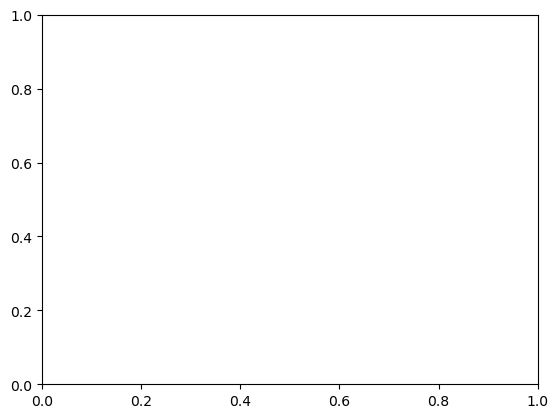

In [56]:
plt.scatter(g_x, g_y, c=radar_at_src)

In [46]:
scores = pd.Series(scores)
scores.index[scores.argmax()]

'Rational'

In [69]:
t = np.argmax(np.nansum(gridded, axis=(1,2)))
time = full_timestamp[t]

met = arrs[t]
gauges = gridded[t]

# creating obs_coordinates
obs_coords = np.array(obs_df[["eastings", "northings"]]).astype(float) # grid_coords[obs_ix]

# creating gauge observations from truth
obs = np.random.random(19) #truth[obs_ix]

# Mean Field Bias Adjustment
mfbadjuster = adjust.AdjustMFB(obs_coords, grid_coords)
mfbadjusted = mfbadjuster(obs, radar)

# Additive Error Model
addadjuster = adjust.AdjustAdd(obs_coords, grid_coords)
addadjusted = addadjuster(obs, radar)

# Multiplicative Error Model
multadjuster = adjust.AdjustMultiply(obs_coords, grid_coords)
multadjusted = multadjuster(obs, radar)

# Helper functions for grid plots
def gridplot(data, title):
    """Quick and dirty helper function to produce a grid plot
    """
    xplot = np.append(xgrid, xgrid[-1] + 1.) - 0.5
    yplot = np.append(ygrid, ygrid[-1] + 1.) - 0.5
    grd = ax.pcolormesh(xplot, yplot, data.reshape(gridshape), vmin=0,
                        vmax=maxval)
    ax.scatter(obs_coords[:, 0], obs_coords[:, 1], c=obs.ravel(),
               marker='s', s=50, vmin=0, vmax=maxval)
    #pl.colorbar(grd, shrink=0.5)
    pl.title(title)
    
# Maximum value (used for normalisation of colorscales)
maxval = np.max(np.concatenate((truth, radar, obs, addadjusted)).ravel())

# open figure
fig = pl.figure(figsize=(10, 6))

# True rainfall
ax = fig.add_subplot(231, aspect='equal')
gridplot(truth, 'True rainfall')

# Unadjusted radar rainfall
ax = fig.add_subplot(232, aspect='equal')
gridplot(radar, 'Radar rainfall')

# Adjusted radar rainfall (MFB)
ax = fig.add_subplot(234, aspect='equal')
gridplot(mfbadjusted, 'Adjusted (MFB)')

# Adjusted radar rainfall (additive)
ax = fig.add_subplot(235, aspect='equal')
gridplot(addadjusted, 'Adjusted (Add.)')

# Adjusted radar rainfall (multiplicative)
ax = fig.add_subplot(236, aspect='equal')
gridplot(multadjusted, 'Adjusted (Mult.)')

pl.tight_layout()

True

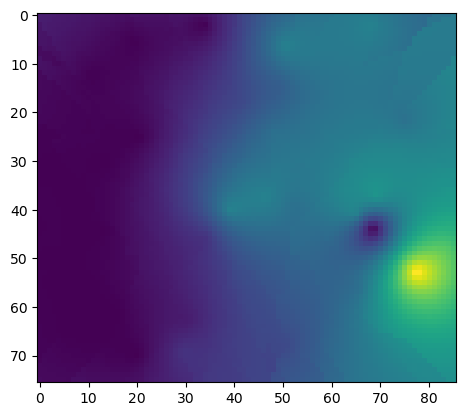

In [14]:
import matplotlib.pyplot as plt
plt.imshow(gridded[56])

In [16]:
len(dates)

1058